In [1]:
!nvidia-smi

Fri Feb 23 19:40:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   46C    P8              21W / 215W |    767MiB /  8192MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
from torchaudio.datasets import IEMOCAP
data_dir = '../data/IEMOCAP/'
val_set = IEMOCAP(root=data_dir, sessions=(1,), utterance_type='scripted')
val_set.get_metadata(n=10)

('Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F023.wav',
 16000,
 'Ses01F_script01_1_F023',
 'fru',
 'Ses01F')

Shape of waveform: torch.Size([1, 49759])
Sample rate: 16000 Hz, emotion label: fru


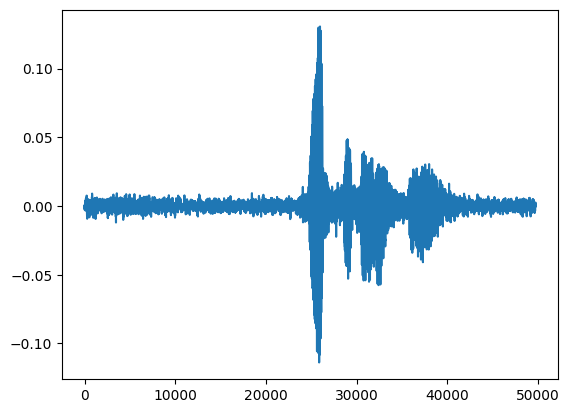

In [7]:
waveform, sample_rate, filename, label, speaker_id = val_set.__getitem__(0)
print("Shape of waveform: {}".format(waveform.size()))
print(f"Sample rate: {sample_rate} Hz, emotion label: {label}")
plt.plot(waveform.t().numpy())

In [8]:
data = IEMOCAP(root=data_dir, 
               sessions=(1,2,5), # use all
               # utterance_type='improve'
              )
all_labels = sorted(list(set(datapoint[3] for datapoint in data)))
print(all_labels)

['ang', 'exc', 'fru', 'hap', 'neu', 'sad']


In [9]:
labels = ['ang', 'neu', 'sad', 'hap']

def label_to_index(word):
    return torch.tensor(labels.index(word), dtype=torch.long)
def index_to_label(index):
    return labels[index]
    
data_x = []
data_y = []
for d in data:
    if d[3] in labels:
        data_x.append(d)
        data_y.append(label_to_index(d[3]))

In [10]:
train_set, test_set = train_test_split(
    data_x, test_size=0.2, random_state=42, stratify=data_y)
print("Train: %i" % len(train_set))
print("Test: %i" % len(test_set))

Train: 2157
Test: 540


In [11]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=16000):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, sample_rate, _, label, *_ in batch:
        length = len(waveform)
        max_length = sample_rate * max_duration_in_second
        offset = max(0, (length - max_length) // 2)
        tensors += [waveform[offset: length-offset]]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 4

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [12]:
data_improv = IEMOCAP(root=data_dir, 
               # sessions=(1,2,), # use all
               utterance_type='improvised'
              )
all_labels_improv = sorted(list(set(datapoint[3] for datapoint in data_improv)))
print(all_labels_improv)
data_improv_x = []
data_improv_y = []
for d in data_improv:
    if d[3] in labels:
        data_improv_x.append(d)
        data_improv_y.append(label_to_index(d[3]))


['ang', 'exc', 'fru', 'hap', 'neu', 'sad']


In [13]:
improv_test_loader = torch.utils.data.DataLoader(
    data_improv_x,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [14]:
from IConNet.nn.model import M18
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m18_iemocap.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M18(config=model_config,
           n_input=1, n_output=len(labels))
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')
print(f'FE parameters: {visualize_model.count_parameters(model.fe_blocks)}')

name: M18
description: FirConv sequential for speech emotion
fe:
  n_block: 2
  n_channel:
  - 64
  - 64
  kernel_size:
  - 127
  - 63
  stride:
  - 2
  - 8
  window_k:
  - 9
  - 9
  mel_resolution: 2
  residual_connection_type: concat
  pooling: false
  filter_type: firwin
  conv_mode: fftconv
  norm_type: LocalResponseNorm
seq:
  n_block: 1
  n_channel: 24
  out_seq_length: 4
  use_context: true
  bidirectional: false
cls:
  n_block: 2
  n_hidden_dim:
  - 320
  - 320
  norm_type: LayerNorm
  dropout: 0.1

M18(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
           

In [15]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [16]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [17]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                                                                                             | 0.001483679525222552/10 [00:00<51:43, 310.35s/it]

Train Epoch: 1 [0/2157 (0%)]	Loss: 1.401123
Mem before-during-after: 1047040 981681152 27681280


  1%|█                                                                                                                                                                             | 0.06083086053412467/10 [00:09<26:44, 161.45s/it]

Train Epoch: 1 [160/2157 (7%)]	Loss: 1.219672
Mem before-during-after: 27681280 1028186624 27681280


  1%|██                                                                                                                                                                            | 0.12017804154302658/10 [00:19<28:43, 174.48s/it]

Train Epoch: 1 [320/2157 (15%)]	Loss: 1.493434
Mem before-during-after: 28729856 1535844352 27681280


  2%|███▏                                                                                                                                                                          | 0.18100890207715103/10 [00:29<23:44, 145.07s/it]

Train Epoch: 1 [480/2157 (22%)]	Loss: 0.910233
Mem before-during-after: 27681280 429026816 27681280


  2%|████▏                                                                                                                                                                          | 0.2388724035608304/10 [00:38<26:56, 165.66s/it]

Train Epoch: 1 [640/2157 (30%)]	Loss: 2.465116
Mem before-during-after: 27681280 1329788928 27681280


  3%|█████▏                                                                                                                                                                         | 0.2982195845697323/10 [00:48<28:25, 175.77s/it]

Train Epoch: 1 [800/2157 (37%)]	Loss: 1.028669
Mem before-during-after: 27681280 1003484160 27681280


  4%|██████▎                                                                                                                                                                        | 0.3575667655786342/10 [00:57<26:13, 163.14s/it]

Train Epoch: 1 [960/2157 (45%)]	Loss: 1.328206
Mem before-during-after: 27681280 892121088 27812352


  4%|███████▎                                                                                                                                                                      | 0.41839762611275866/10 [01:07<26:36, 166.59s/it]

Train Epoch: 1 [1120/2157 (52%)]	Loss: 0.664792
Mem before-during-after: 27681280 1927239168 27681280


  5%|████████▎                                                                                                                                                                     | 0.47774480712166056/10 [01:16<23:55, 150.75s/it]

Train Epoch: 1 [1280/2157 (59%)]	Loss: 0.728977
Mem before-during-after: 27681280 1626763264 27681280


  5%|█████████▎                                                                                                                                                                     | 0.5356083086053399/10 [01:25<28:55, 183.36s/it]

Train Epoch: 1 [1440/2157 (67%)]	Loss: 1.450795
Mem before-during-after: 27681280 1406557696 27681280


  6%|██████████▍                                                                                                                                                                    | 0.5949554896142418/10 [01:35<25:13, 160.96s/it]

Train Epoch: 1 [1600/2157 (74%)]	Loss: 1.315773
Mem before-during-after: 27681280 1283079680 27681280


  7%|███████████▍                                                                                                                                                                   | 0.6543026706231437/10 [01:45<26:04, 167.45s/it]

Train Epoch: 1 [1760/2157 (82%)]	Loss: 2.129206
Mem before-during-after: 27681280 1256005120 27681280


  7%|████████████▍                                                                                                                                                                  | 0.7136498516320456/10 [01:54<27:09, 175.48s/it]

Train Epoch: 1 [1920/2157 (89%)]	Loss: 1.138739
Mem before-during-after: 27681280 2259034624 27681280


  8%|█████████████▌                                                                                                                                                                 | 0.7729970326409475/10 [02:03<27:24, 178.20s/it]

Train Epoch: 1 [2080/2157 (96%)]	Loss: 1.144498
Mem before-during-after: 27681280 1669641216 27681280


 10%|█████████████████▍                                                                                                                                                             | 0.9999999999999973/10 [02:34<19:29, 129.94s/it]


Test Epoch: 1	Accuracy: 246/540 (46%)



 10%|█████████████████▋                                                                                                                                                               | 1.00148367952522/10 [02:34<20:58, 139.90s/it]

Train Epoch: 2 [0/2157 (0%)]	Loss: 0.943025
Mem before-during-after: 27677184 1081147392 27681280


 11%|██████████████████▌                                                                                                                                                            | 1.0608308605341263/10 [02:43<23:04, 154.86s/it]

Train Epoch: 2 [160/2157 (7%)]	Loss: 2.060281
Mem before-during-after: 27681280 795041792 27681280


 11%|███████████████████▌                                                                                                                                                           | 1.1201780415430327/10 [02:52<22:14, 150.28s/it]

Train Epoch: 2 [320/2157 (15%)]	Loss: 0.681185
Mem before-during-after: 27877888 908125696 27681280


 12%|████████████████████▊                                                                                                                                                           | 1.179525222551939/10 [03:01<25:06, 170.75s/it]

Train Epoch: 2 [480/2157 (22%)]	Loss: 0.428116
Mem before-during-after: 27681280 2643421184 27681280


 12%|█████████████████████▋                                                                                                                                                         | 1.2388724035608454/10 [03:10<23:39, 162.08s/it]

Train Epoch: 2 [640/2157 (30%)]	Loss: 0.683247
Mem before-during-after: 28698112 1589614080 27681280


 13%|██████████████████████▋                                                                                                                                                        | 1.2997032640949744/10 [03:19<19:54, 137.25s/it]

Train Epoch: 2 [800/2157 (37%)]	Loss: 2.557585
Mem before-during-after: 27681280 668484608 27681280


 14%|███████████████████████▉                                                                                                                                                        | 1.357566765578658/10 [03:28<22:20, 155.16s/it]

Train Epoch: 2 [960/2157 (45%)]	Loss: 1.204708
Mem before-during-after: 27681280 1678024192 27681280


 14%|████████████████████████▊                                                                                                                                                      | 1.4169139465875644/10 [03:38<28:14, 197.46s/it]

Train Epoch: 2 [1120/2157 (52%)]	Loss: 0.584110
Mem before-during-after: 27681280 3462189568 27681280


 15%|█████████████████████████▊                                                                                                                                                     | 1.4762611275964708/10 [03:47<22:13, 156.42s/it]

Train Epoch: 2 [1280/2157 (59%)]	Loss: 1.227084
Mem before-during-after: 27681280 876096512 27681280


 15%|██████████████████████████▊                                                                                                                                                    | 1.5356083086053771/10 [03:56<20:45, 147.19s/it]

Train Epoch: 2 [1440/2157 (67%)]	Loss: 0.944944
Mem before-during-after: 27681280 1322758144 27681280


 16%|███████████████████████████▉                                                                                                                                                   | 1.5964391691395061/10 [04:05<19:16, 137.63s/it]

Train Epoch: 2 [1600/2157 (74%)]	Loss: 0.613331
Mem before-during-after: 27681280 636866048 27681280


 17%|████████████████████████████▉                                                                                                                                                  | 1.6543026706231898/10 [04:14<21:36, 155.40s/it]

Train Epoch: 2 [1760/2157 (82%)]	Loss: 1.901755
Mem before-during-after: 27681280 730412544 27681280


 17%|██████████████████████████████                                                                                                                                                 | 1.7151335311573188/10 [04:23<20:19, 147.19s/it]

Train Epoch: 2 [1920/2157 (89%)]	Loss: 0.866547
Mem before-during-after: 27681280 743058944 27681280


 18%|███████████████████████████████                                                                                                                                                | 1.7729970326410025/10 [04:32<22:59, 167.63s/it]

Train Epoch: 2 [2080/2157 (96%)]	Loss: 1.066110
Mem before-during-after: 27681280 1243699200 27681280


 20%|███████████████████████████████████                                                                                                                                            | 2.0000000000000693/10 [05:02<16:10, 121.33s/it]


Test Epoch: 2	Accuracy: 246/540 (46%)



 20%|███████████████████████████████████▏                                                                                                                                            | 2.001483679525292/10 [05:02<17:34, 131.86s/it]

Train Epoch: 3 [0/2157 (0%)]	Loss: 0.793134
Mem before-during-after: 27677184 890907136 27681280


 21%|████████████████████████████████████                                                                                                                                           | 2.0608308605341983/10 [05:11<20:50, 157.49s/it]

Train Epoch: 3 [160/2157 (7%)]	Loss: 0.728085
Mem before-during-after: 28500480 1068715008 27681280


 21%|█████████████████████████████████████                                                                                                                                          | 2.1201780415431046/10 [05:20<21:13, 161.63s/it]

Train Epoch: 3 [320/2157 (15%)]	Loss: 0.760525
Mem before-during-after: 27746816 1214697984 27681280


 22%|██████████████████████████████████████▏                                                                                                                                        | 2.1810089020772336/10 [05:29<17:51, 137.08s/it]

Train Epoch: 3 [480/2157 (22%)]	Loss: 2.034249
Mem before-during-after: 27681280 477231616 27681280


 22%|███████████████████████████████████████▏                                                                                                                                       | 2.2388724035609173/10 [05:38<21:40, 167.52s/it]

Train Epoch: 3 [640/2157 (30%)]	Loss: 1.020975
Mem before-during-after: 27681280 1630285312 27771392


 23%|████████████████████████████████████████▏                                                                                                                                      | 2.2982195845698237/10 [05:48<21:04, 164.23s/it]

Train Epoch: 3 [800/2157 (37%)]	Loss: 1.629465
Mem before-during-after: 27681280 876913152 27681280


 24%|█████████████████████████████████████████▋                                                                                                                                       | 2.35756676557873/10 [05:57<20:07, 158.02s/it]

Train Epoch: 3 [960/2157 (45%)]	Loss: 1.590451
Mem before-during-after: 27681280 1383413248 27681280


 24%|██████████████████████████████████████████▎                                                                                                                                    | 2.4169139465876364/10 [06:06<19:25, 153.69s/it]

Train Epoch: 3 [1120/2157 (52%)]	Loss: 1.116995
Mem before-during-after: 27681280 869999104 27681280


 25%|███████████████████████████████████████████▎                                                                                                                                   | 2.4777448071217654/10 [06:15<18:24, 146.84s/it]

Train Epoch: 3 [1280/2157 (59%)]	Loss: 1.030118
Mem before-during-after: 27681280 1002992640 27681280


 25%|████████████████████████████████████████████▋                                                                                                                                   | 2.535608308605449/10 [06:23<18:52, 151.74s/it]

Train Epoch: 3 [1440/2157 (67%)]	Loss: 3.495611
Mem before-during-after: 27681280 895460864 27681280


 26%|█████████████████████████████████████████████▋                                                                                                                                  | 2.596439169139578/10 [06:33<18:14, 147.78s/it]

Train Epoch: 3 [1600/2157 (74%)]	Loss: 2.860019
Mem before-during-after: 27681280 773437952 27681280


 27%|██████████████████████████████████████████████▍                                                                                                                                | 2.6557863501484844/10 [06:42<16:24, 134.01s/it]

Train Epoch: 3 [1760/2157 (82%)]	Loss: 1.069154
Mem before-during-after: 27681280 813705216 28598784


 27%|███████████████████████████████████████████████▌                                                                                                                               | 2.7151335311573908/10 [06:51<18:13, 150.09s/it]

Train Epoch: 3 [1920/2157 (89%)]	Loss: 1.249697
Mem before-during-after: 27681280 696418304 27716096


 28%|████████████████████████████████████████████████▌                                                                                                                              | 2.7729970326410744/10 [07:00<19:10, 159.18s/it]

Train Epoch: 3 [2080/2157 (96%)]	Loss: 0.937268
Mem before-during-after: 27681280 1672744960 27681280


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 3.000000000000141/10 [07:30<16:41, 143.02s/it]


Test Epoch: 3	Accuracy: 278/540 (51%)



 30%|████████████████████████████████████████████████████▌                                                                                                                          | 3.0029673590505865/10 [07:30<17:01, 146.04s/it]

Train Epoch: 4 [0/2157 (0%)]	Loss: 0.583953
Mem before-during-after: 27677184 1553960960 27681280


 31%|█████████████████████████████████████████████████████▌                                                                                                                         | 3.0608308605342702/10 [07:39<20:02, 173.25s/it]

Train Epoch: 4 [160/2157 (7%)]	Loss: 1.362644
Mem before-during-after: 27681280 2259034624 27681280


 31%|██████████████████████████████████████████████████████▌                                                                                                                        | 3.1201780415431766/10 [07:48<19:38, 171.29s/it]

Train Epoch: 4 [320/2157 (15%)]	Loss: 1.169589
Mem before-during-after: 27681280 1052445696 27681280


 32%|███████████████████████████████████████████████████████▉                                                                                                                        | 3.179525222552083/10 [07:57<17:04, 150.19s/it]

Train Epoch: 4 [480/2157 (22%)]	Loss: 0.771902
Mem before-during-after: 27681280 1160849920 27681280


 32%|█████████████████████████████████████████████████████████                                                                                                                       | 3.240356083086212/10 [08:07<17:32, 155.69s/it]

Train Epoch: 4 [640/2157 (30%)]	Loss: 1.328634
Mem before-during-after: 27681280 1471027712 27681280


 33%|█████████████████████████████████████████████████████████▋                                                                                                                     | 3.2982195845698956/10 [08:15<17:31, 156.85s/it]

Train Epoch: 4 [800/2157 (37%)]	Loss: 1.133410
Mem before-during-after: 27681280 1099531776 27681280


 34%|███████████████████████████████████████████████████████████                                                                                                                     | 3.357566765578802/10 [08:24<15:54, 143.67s/it]

Train Epoch: 4 [960/2157 (45%)]	Loss: 1.298286
Mem before-during-after: 27681280 944153088 27681280


 34%|████████████████████████████████████████████████████████████▏                                                                                                                   | 3.418397626112931/10 [08:34<15:44, 143.55s/it]

Train Epoch: 4 [1120/2157 (52%)]	Loss: 0.711561
Mem before-during-after: 27681280 924705792 27681280


 35%|████████████████████████████████████████████████████████████▊                                                                                                                  | 3.4777448071218373/10 [08:43<15:25, 141.97s/it]

Train Epoch: 4 [1280/2157 (59%)]	Loss: 1.346228
Mem before-during-after: 27681280 776066048 27681280


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                 | 3.535608308605521/10 [08:51<15:45, 146.23s/it]

Train Epoch: 4 [1440/2157 (67%)]	Loss: 1.357560
Mem before-during-after: 27681280 1114700288 27681280


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                | 3.5949554896144273/10 [09:00<16:46, 157.13s/it]

Train Epoch: 4 [1600/2157 (74%)]	Loss: 1.127433
Mem before-during-after: 27681280 1538238464 27681280


 37%|███████████████████████████████████████████████████████████████▉                                                                                                               | 3.6543026706233337/10 [09:09<15:54, 150.46s/it]

Train Epoch: 4 [1760/2157 (82%)]	Loss: 0.873372
Mem before-during-after: 27681280 600691712 27681280


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                               | 3.71364985163224/10 [09:18<17:47, 169.76s/it]

Train Epoch: 4 [1920/2157 (89%)]	Loss: 1.280675
Mem before-during-after: 27681280 1421565952 27681280


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                             | 3.774480712166369/10 [09:27<15:39, 150.86s/it]

Train Epoch: 4 [2080/2157 (96%)]	Loss: 0.544183
Mem before-during-after: 27681280 864095232 27681280


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 4.000000000000213/10 [09:56<12:07, 121.30s/it]


Test Epoch: 4	Accuracy: 296/540 (55%)



 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 4.001483679525435/10 [09:56<13:14, 132.47s/it]

Train Epoch: 5 [0/2157 (0%)]	Loss: 0.449642
Mem before-during-after: 27677184 859025408 27681280


 41%|███████████████████████████████████████████████████████████████████████▍                                                                                                        | 4.062314540059546/10 [10:06<14:30, 146.66s/it]

Train Epoch: 5 [160/2157 (7%)]	Loss: 0.458169
Mem before-during-after: 27681280 1119415808 27681280


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                       | 4.121661721068435/10 [10:15<14:28, 147.82s/it]

Train Epoch: 5 [320/2157 (15%)]	Loss: 1.235266
Mem before-during-after: 27681280 1373891584 27681280


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                      | 4.179525222552101/10 [10:23<15:49, 163.12s/it]

Train Epoch: 5 [480/2157 (22%)]	Loss: 0.930161
Mem before-during-after: 27681280 516047360 27681280


 42%|███████████████████████████████████████████████████████████████████████████                                                                                                      | 4.23887240356099/10 [10:32<14:06, 146.89s/it]

Train Epoch: 5 [640/2157 (30%)]	Loss: 0.594260
Mem before-during-after: 27681280 1019444224 27681280


 43%|███████████████████████████████████████████████████████████████████████████▏                                                                                                   | 4.2997032640951005/10 [10:41<13:46, 144.99s/it]

Train Epoch: 5 [800/2157 (37%)]	Loss: 0.765421
Mem before-during-after: 27902464 583595520 27681280


 44%|████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 4.357566765578767/10 [10:50<14:58, 159.16s/it]

Train Epoch: 5 [960/2157 (45%)]	Loss: 1.488281
Mem before-during-after: 27681280 1163313152 27681280


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 4.418397626112878/10 [10:59<13:14, 142.28s/it]

Train Epoch: 5 [1120/2157 (52%)]	Loss: 0.767782
Mem before-during-after: 28467712 599597056 27681280


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 4.476261127596544/10 [11:08<14:35, 158.58s/it]

Train Epoch: 5 [1280/2157 (59%)]	Loss: 1.209694
Mem before-during-after: 27681280 727484928 27681280


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                | 4.537091988130655/10 [11:17<13:11, 144.80s/it]

Train Epoch: 5 [1440/2157 (67%)]	Loss: 1.262307
Mem before-during-after: 27681280 907006976 27681280


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 4.596439169139543/10 [11:26<12:51, 142.78s/it]

Train Epoch: 5 [1600/2157 (74%)]	Loss: 0.756597
Mem before-during-after: 27681280 513243136 27681280


 47%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 4.655786350148432/10 [11:35<13:43, 154.14s/it]

Train Epoch: 5 [1760/2157 (82%)]	Loss: 1.412754
Mem before-during-after: 27681280 623426560 27681280


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 4.713649851632098/10 [11:44<13:08, 149.11s/it]

Train Epoch: 5 [1920/2157 (89%)]	Loss: 1.520856
Mem before-during-after: 27681280 1098667008 27681280


 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                            | 4.772997032640987/10 [11:53<13:48, 158.52s/it]

Train Epoch: 5 [2080/2157 (96%)]	Loss: 0.694914
Mem before-during-after: 27681280 1703877632 27681280


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 4.999999999999986/10 [12:22<09:50, 118.03s/it]


Test Epoch: 5	Accuracy: 270/540 (50%)



 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5.001483679525208/10 [12:22<12:43, 152.82s/it]

Train Epoch: 6 [0/2157 (0%)]	Loss: 1.361566
Mem before-during-after: 27677184 3134046720 27681280


 51%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 5.060830860534097/10 [12:31<12:38, 153.63s/it]

Train Epoch: 6 [160/2157 (7%)]	Loss: 1.026323
Mem before-during-after: 27681280 1837881344 27681280


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 5.120178041542985/10 [12:40<12:15, 150.71s/it]

Train Epoch: 6 [320/2157 (15%)]	Loss: 0.917375
Mem before-during-after: 27681280 383790592 27681280


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 5.179525222551874/10 [12:49<12:40, 157.82s/it]

Train Epoch: 6 [480/2157 (22%)]	Loss: 2.474785
Mem before-during-after: 27681280 580473856 27681280


 52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 5.238872403560762/10 [12:58<12:06, 152.67s/it]

Train Epoch: 6 [640/2157 (30%)]	Loss: 0.870374
Mem before-during-after: 27681280 1469769216 27681280


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 5.299703264094873/10 [13:07<11:10, 142.58s/it]

Train Epoch: 6 [800/2157 (37%)]	Loss: 0.987755
Mem before-during-after: 27681280 789128704 27681280


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 5.359050445103762/10 [13:16<11:17, 146.07s/it]

Train Epoch: 6 [960/2157 (45%)]	Loss: 0.992700
Mem before-during-after: 27681280 1103054848 27681280


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 5.41839762611265/10 [13:25<10:32, 138.08s/it]

Train Epoch: 6 [1120/2157 (52%)]	Loss: 1.747588
Mem before-during-after: 27681280 986806784 27681280


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 5.476261127596317/10 [13:34<12:12, 161.86s/it]

Train Epoch: 6 [1280/2157 (59%)]	Loss: 0.883750
Mem before-during-after: 27681280 619569664 27681280


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 5.535608308605205/10 [13:43<11:07, 149.59s/it]

Train Epoch: 6 [1440/2157 (67%)]	Loss: 1.481266
Mem before-during-after: 27681280 1079370240 27681280


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 5.596439169139316/10 [13:52<11:07, 151.62s/it]

Train Epoch: 6 [1600/2157 (74%)]	Loss: 1.478341
Mem before-during-after: 27681280 991307776 27681280


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 5.654302670622982/10 [14:01<11:35, 160.02s/it]

Train Epoch: 6 [1760/2157 (82%)]	Loss: 1.569699
Mem before-during-after: 27681280 1798594560 27681280


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 5.713649851631871/10 [14:10<12:06, 169.51s/it]

Train Epoch: 6 [1920/2157 (89%)]	Loss: 1.703178
Mem before-during-after: 27681280 1306156032 27681280


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 5.77299703264076/10 [14:19<10:29, 148.88s/it]

Train Epoch: 6 [2080/2157 (96%)]	Loss: 1.188813
Mem before-during-after: 27681280 1310112768 28205568


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 6.001483679524981/10 [14:48<08:23, 125.96s/it]


Test Epoch: 6	Accuracy: 299/540 (55%)

Train Epoch: 7 [0/2157 (0%)]	Loss: 0.917162
Mem before-during-after: 27677184 699253760 27681280


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 6.060830860533869/10 [14:57<09:52, 150.32s/it]

Train Epoch: 7 [160/2157 (7%)]	Loss: 1.247268
Mem before-during-after: 27681280 518007296 27681280


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 6.120178041542758/10 [15:07<14:36, 225.81s/it]

Train Epoch: 7 [320/2157 (15%)]	Loss: 0.909291
Mem before-during-after: 27681280 1587677184 27681280


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 6.179525222551646/10 [15:17<09:50, 154.57s/it]

Train Epoch: 7 [480/2157 (22%)]	Loss: 1.275551
Mem before-during-after: 27681280 1298947584 27681280


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 6.238872403560535/10 [15:26<09:28, 151.19s/it]

Train Epoch: 7 [640/2157 (30%)]	Loss: 0.551817
Mem before-during-after: 27681280 902816768 27681280


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 6.2982195845694235/10 [15:35<10:04, 163.22s/it]

Train Epoch: 7 [800/2157 (37%)]	Loss: 1.018106
Mem before-during-after: 27681280 1582400512 27681280


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 6.357566765578312/10 [15:44<09:48, 161.51s/it]

Train Epoch: 7 [960/2157 (45%)]	Loss: 1.181451
Mem before-during-after: 27681280 1141243392 27681280


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 6.418397626112423/10 [15:53<09:02, 151.39s/it]

Train Epoch: 7 [1120/2157 (52%)]	Loss: 1.414535
Mem before-during-after: 27681280 425551360 27681280


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 6.476261127596089/10 [16:02<08:55, 151.88s/it]

Train Epoch: 7 [1280/2157 (59%)]	Loss: 1.851881
Mem before-during-after: 27681280 970678784 27681280


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 6.5370919881302/10 [16:11<08:20, 144.54s/it]

Train Epoch: 7 [1440/2157 (67%)]	Loss: 0.379374
Mem before-during-after: 27681280 1418440192 27681280


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 6.5949554896138665/10 [16:20<08:33, 150.86s/it]

Train Epoch: 7 [1600/2157 (74%)]	Loss: 0.651895
Mem before-during-after: 27681280 649542144 27681280


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 6.654302670622755/10 [16:29<08:32, 153.19s/it]

Train Epoch: 7 [1760/2157 (82%)]	Loss: 0.821804
Mem before-during-after: 27681280 1193299456 27681280


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 6.713649851631644/10 [16:38<07:59, 145.87s/it]

Train Epoch: 7 [1920/2157 (89%)]	Loss: 0.964294
Mem before-during-after: 27681280 1065075200 28230144


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 6.772997032640532/10 [16:48<08:55, 165.98s/it]

Train Epoch: 7 [2080/2157 (96%)]	Loss: 0.409655
Mem before-during-after: 27681280 1215522816 27681280


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 6.999999999999531/10 [17:16<06:00, 120.26s/it]


Test Epoch: 7	Accuracy: 270/540 (50%)



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 7.001483679524753/10 [17:17<06:57, 139.40s/it]

Train Epoch: 8 [0/2157 (0%)]	Loss: 2.195887
Mem before-during-after: 27677184 1844337664 28631552


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 7.060830860533642/10 [17:25<07:27, 152.19s/it]

Train Epoch: 8 [160/2157 (7%)]	Loss: 2.294909
Mem before-during-after: 27681280 1310543360 27681280


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 7.12017804154253/10 [17:35<07:40, 159.83s/it]

Train Epoch: 8 [320/2157 (15%)]	Loss: 0.953994
Mem before-during-after: 27681280 652593664 27681280


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 7.179525222551419/10 [17:45<07:46, 165.41s/it]

Train Epoch: 8 [480/2157 (22%)]	Loss: 0.497384
Mem before-during-after: 28598784 1794684416 27681280


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 7.24035608308553/10 [17:54<06:53, 149.72s/it]

Train Epoch: 8 [640/2157 (30%)]	Loss: 0.566308
Mem before-during-after: 28729856 346423296 27681280


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 7.298219584569196/10 [18:03<07:36, 168.85s/it]

Train Epoch: 8 [800/2157 (37%)]	Loss: 1.935423
Mem before-during-after: 27681280 1630955520 27681280


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 7.357566765578085/10 [18:12<07:26, 169.05s/it]

Train Epoch: 8 [960/2157 (45%)]	Loss: 3.211979
Mem before-during-after: 27681280 1351897600 27681280


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 7.416913946586973/10 [18:21<06:50, 158.93s/it]

Train Epoch: 8 [1120/2157 (52%)]	Loss: 0.858406
Mem before-during-after: 27681280 822953472 27681280


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7.477744807121084/10 [18:30<05:52, 139.86s/it]

Train Epoch: 8 [1280/2157 (59%)]	Loss: 0.578331
Mem before-during-after: 27681280 520070144 27681280


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7.5356083086047505/10 [18:39<06:29, 157.85s/it]

Train Epoch: 8 [1440/2157 (67%)]	Loss: 1.187119
Mem before-during-after: 27681280 1126363136 27681280


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7.596439169138861/10 [18:48<06:10, 153.95s/it]

Train Epoch: 8 [1600/2157 (74%)]	Loss: 0.318920
Mem before-during-after: 27681280 1276559360 28434944


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7.654302670622528/10 [18:56<06:08, 156.94s/it]

Train Epoch: 8 [1760/2157 (82%)]	Loss: 1.160709
Mem before-during-after: 27681280 1113342976 27681280


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7.7151335311566385/10 [19:05<05:16, 138.31s/it]

Train Epoch: 8 [1920/2157 (89%)]	Loss: 0.875948
Mem before-during-after: 27681280 645782016 27812352


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7.774480712165527/10 [19:15<05:34, 150.28s/it]

Train Epoch: 8 [2080/2157 (96%)]	Loss: 0.495808
Mem before-during-after: 27681280 384205824 27681280


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7.999999999999304/10 [19:43<04:03, 121.87s/it]


Test Epoch: 8	Accuracy: 300/540 (56%)



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 8.001483679524526/10 [19:44<04:43, 142.04s/it]

Train Epoch: 9 [0/2157 (0%)]	Loss: 0.583754
Mem before-during-after: 27677184 1844337664 28631552


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 8.060830860533414/10 [19:53<05:12, 160.96s/it]

Train Epoch: 9 [160/2157 (7%)]	Loss: 1.120098
Mem before-during-after: 27681280 952048128 27681280


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 8.120178041542303/10 [20:02<04:34, 145.80s/it]

Train Epoch: 9 [320/2157 (15%)]	Loss: 1.053389
Mem before-during-after: 27681280 680423424 27681280


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 8.179525222551192/10 [20:11<04:27, 147.02s/it]

Train Epoch: 9 [480/2157 (22%)]	Loss: 0.454704
Mem before-during-after: 27681280 486740480 27681280


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 8.240356083085302/10 [20:20<04:06, 140.02s/it]

Train Epoch: 9 [640/2157 (30%)]	Loss: 0.880801
Mem before-during-after: 27681280 384912896 27681280


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8.299703264094191/10 [20:29<04:22, 154.48s/it]

Train Epoch: 9 [800/2157 (37%)]	Loss: 0.840869
Mem before-during-after: 27681280 702769152 27959808


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 8.35905044510308/10 [20:39<04:33, 166.84s/it]

Train Epoch: 9 [960/2157 (45%)]	Loss: 0.652188
Mem before-during-after: 28140032 1259204608 27681280


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8.416913946586746/10 [20:48<03:40, 139.08s/it]

Train Epoch: 9 [1120/2157 (52%)]	Loss: 1.087366
Mem before-during-after: 27681280 491476992 27681280


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8.476261127595635/10 [20:57<04:14, 166.89s/it]

Train Epoch: 9 [1280/2157 (59%)]	Loss: 1.230242
Mem before-during-after: 27681280 1695970304 27681280


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8.537091988129745/10 [21:06<03:32, 145.40s/it]

Train Epoch: 9 [1440/2157 (67%)]	Loss: 0.239741
Mem before-during-after: 27681280 913528320 27681280


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8.594955489613412/10 [21:15<03:41, 157.31s/it]

Train Epoch: 9 [1600/2157 (74%)]	Loss: 1.713251
Mem before-during-after: 27681280 1632716800 27681280


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8.6543026706223/10 [21:23<03:33, 158.42s/it]

Train Epoch: 9 [1760/2157 (82%)]	Loss: 1.742651
Mem before-during-after: 27681280 1351287808 27681280


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8.715133531156411/10 [21:33<03:09, 147.51s/it]

Train Epoch: 9 [1920/2157 (89%)]	Loss: 1.266453
Mem before-during-after: 27681280 403094528 27681280


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8.772997032640077/10 [21:41<03:25, 167.54s/it]

Train Epoch: 9 [2080/2157 (96%)]	Loss: 0.891593
Mem before-during-after: 27681280 2705871872 27681280


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8.999999999999076/10 [22:11<02:03, 123.35s/it]


Test Epoch: 9	Accuracy: 301/540 (56%)



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 9.001483679524299/10 [22:11<02:12, 132.66s/it]

Train Epoch: 10 [0/2157 (0%)]	Loss: 0.807645
Mem before-during-after: 27677184 1117478400 27681280


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 9.060830860533187/10 [22:20<02:18, 146.99s/it]

Train Epoch: 10 [160/2157 (7%)]	Loss: 0.650745
Mem before-during-after: 28140032 574106112 27681280


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 9.121661721067298/10 [22:29<02:22, 162.60s/it]

Train Epoch: 10 [320/2157 (15%)]	Loss: 1.663997
Mem before-during-after: 27681280 1664344576 27681280


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9.179525222550964/10 [22:38<01:56, 141.51s/it]

Train Epoch: 10 [480/2157 (22%)]	Loss: 0.914523
Mem before-during-after: 27681280 663617024 27681280


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9.238872403559853/10 [22:47<01:59, 157.18s/it]

Train Epoch: 10 [640/2157 (30%)]	Loss: 0.685860
Mem before-during-after: 27681280 911298048 27681280


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9.298219584568741/10 [22:57<02:02, 174.99s/it]

Train Epoch: 10 [800/2157 (37%)]	Loss: 0.848015
Mem before-during-after: 27681280 1579104256 27681280


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9.35756676557763/10 [23:06<01:40, 156.29s/it]

Train Epoch: 10 [960/2157 (45%)]	Loss: 1.339703
Mem before-during-after: 27681280 958452224 27681280


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9.416913946586519/10 [23:15<01:28, 152.17s/it]

Train Epoch: 10 [1120/2157 (52%)]	Loss: 1.301965
Mem before-during-after: 27681280 315042304 28729856


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9.47774480712063/10 [23:24<01:15, 144.35s/it]

Train Epoch: 10 [1280/2157 (59%)]	Loss: 1.958998
Mem before-during-after: 27681280 587820032 27681280


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9.535608308604296/10 [23:33<01:09, 149.08s/it]

Train Epoch: 10 [1440/2157 (67%)]	Loss: 1.126073
Mem before-during-after: 27681280 961347072 27681280


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9.594955489613184/10 [23:43<01:07, 167.29s/it]

Train Epoch: 10 [1600/2157 (74%)]	Loss: 1.989435
Mem before-during-after: 27681280 724671488 28395008


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9.655786350147295/10 [23:52<00:50, 147.53s/it]

Train Epoch: 10 [1760/2157 (82%)]	Loss: 1.286384
Mem before-during-after: 28205568 900624896 27681280


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9.713649851630962/10 [24:01<00:49, 171.13s/it]

Train Epoch: 10 [1920/2157 (89%)]	Loss: 0.333377
Mem before-during-after: 27681280 945418240 28533248


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9.77299703263985/10 [24:11<00:40, 180.11s/it]

Train Epoch: 10 [2080/2157 (96%)]	Loss: 1.851390
Mem before-during-after: 27681280 2059309568 27681280


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.999999999998849/10 [24:40<00:00, 148.00s/it]


Test Epoch: 10	Accuracy: 297/540 (55%)



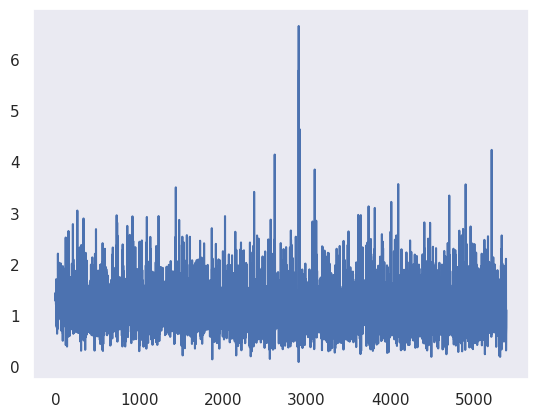

In [18]:
plt.plot(train_losses)

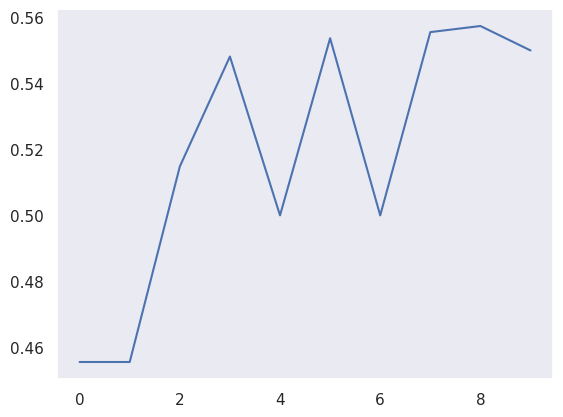

In [19]:
plt.plot(test_accuracy)

In [20]:
model_path = '../iemocap_label4_m18_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [21]:
model_path_prefix = '../models_iemocap4/iemocap_label4_m18_best_'
torch.save(model.state_dict(), f'{model_path_prefix}{n_epoch}epoch.pt')

In [22]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [24]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 297/540 (0.5500)
{'acc_detail': tensor([0.7103, 0.7522, 0.3984, 0.0000], device='cuda:0'),
 'acc_unweighted': tensor(0.4652, device='cuda:0'),
 'acc_weighted': tensor(0.5500, device='cuda:0'),
 'f1s': tensor(0.4351, device='cuda:0'),
 'f1s_detail': tensor([0.6756, 0.6250, 0.4397, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.6441, 0.5346, 0.4904, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.7103, 0.7522, 0.3984, 0.0000], device='cuda:0'),
 'rocauc': tensor([0.8849, 0.6968, 0.7783, 0.6052], device='cuda:0'),
 'uar': tensor(0.4652, device='cuda:0'),
 'wap': tensor(0.4676, device='cuda:0')}


tensor([[ 76,  28,   3,   0],
        [ 20, 170,  36,   0],
        [  3,  74,  51,   0],
        [ 19,  46,  14,   0]], device='cuda:0')

In [25]:
n_epoch = 10
n_epoch2 = 90
# train_losses = []
# test_accuracy = []
best_accuracy = max(test_accuracy)
model_path_prefix = '../models_iemocap4/iemocap_label4_m18_best_'
best_epoch = n_epoch2

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                           | 0.001483679525222552/90 [00:00<4:22:27, 174.98s/it]

Train Epoch: 11 [0/2157 (0%)]	Loss: 1.033631
Mem before-during-after: 25851904 1009466880 27940864


  0%|                                                                                                                                                                            | 0.06083086053412467/90 [00:10<4:25:14, 176.94s/it]

Train Epoch: 11 [160/2157 (7%)]	Loss: 0.614944
Mem before-during-after: 27940864 696678400 27940864


  0%|▏                                                                                                                                                                           | 0.12017804154302658/90 [00:20<4:14:01, 169.58s/it]

Train Epoch: 11 [320/2157 (15%)]	Loss: 0.455609
Mem before-during-after: 27940864 843700736 27940864


  0%|▎                                                                                                                                                                            | 0.1795252225519285/90 [00:30<4:15:16, 170.52s/it]

Train Epoch: 11 [480/2157 (22%)]	Loss: 0.391356
Mem before-during-after: 27940864 1050480640 27940864


  0%|▍                                                                                                                                                                            | 0.2388724035608304/90 [00:40<4:44:57, 190.48s/it]

Train Epoch: 11 [640/2157 (30%)]	Loss: 0.751331
Mem before-during-after: 28530688 1864203264 27940864


  0%|▌                                                                                                                                                                            | 0.2982195845697323/90 [00:50<4:37:23, 185.54s/it]

Train Epoch: 11 [800/2157 (37%)]	Loss: 0.570306
Mem before-during-after: 27940864 1139042816 27940864


  0%|▋                                                                                                                                                                            | 0.3575667655786342/90 [01:00<4:41:49, 188.64s/it]

Train Epoch: 11 [960/2157 (45%)]	Loss: 0.693046
Mem before-during-after: 27940864 475733504 27940864


  0%|▊                                                                                                                                                                            | 0.4169139465875361/90 [01:10<4:16:00, 171.46s/it]

Train Epoch: 11 [1120/2157 (52%)]	Loss: 0.693691
Mem before-during-after: 27940864 944679936 27940864


  1%|▉                                                                                                                                                                             | 0.476261127596438/90 [01:20<4:17:39, 172.68s/it]

Train Epoch: 11 [1280/2157 (59%)]	Loss: 1.046598
Mem before-during-after: 27940864 2706323968 28133376


  1%|█                                                                                                                                                                            | 0.5356083086053399/90 [01:30<4:22:24, 175.99s/it]

Train Epoch: 11 [1440/2157 (67%)]	Loss: 1.390095
Mem before-during-after: 27940864 2084063744 27940864


  1%|█▏                                                                                                                                                                           | 0.5949554896142418/90 [01:40<4:03:04, 163.13s/it]

Train Epoch: 11 [1600/2157 (74%)]	Loss: 0.999280
Mem before-during-after: 27940864 1292522496 27940864


  1%|█▎                                                                                                                                                                           | 0.6543026706231437/90 [01:50<4:48:27, 193.71s/it]

Train Epoch: 11 [1760/2157 (82%)]	Loss: 1.466090
Mem before-during-after: 27940864 1383741952 27940864


  1%|█▎                                                                                                                                                                           | 0.7136498516320456/90 [02:00<3:55:29, 158.25s/it]

Train Epoch: 11 [1920/2157 (89%)]	Loss: 0.920226
Mem before-during-after: 27940864 548567040 27940864


  1%|█▍                                                                                                                                                                           | 0.7729970326409475/90 [02:10<4:04:37, 164.50s/it]

Train Epoch: 11 [2080/2157 (96%)]	Loss: 0.670501
Mem before-during-after: 27940864 1029000704 27940864


  1%|█▉                                                                                                                                                                           | 0.9999999999999973/90 [02:42<3:18:49, 134.04s/it]


Test Epoch: 11	Accuracy: 302/540 (56%)

saved model: ../models_iemocap4/iemocap_label4_m18_best_11epoch.pt


  1%|█▉                                                                                                                                                                             | 1.00148367952522/90 [02:42<3:43:35, 150.74s/it]

Train Epoch: 12 [0/2157 (0%)]	Loss: 0.882895
Mem before-during-after: 27936768 1930530304 27940864


  1%|██                                                                                                                                                                           | 1.0608308605341263/90 [02:52<4:02:07, 163.34s/it]

Train Epoch: 12 [160/2157 (7%)]	Loss: 1.032944
Mem before-during-after: 27940864 1229139456 27940864


  1%|██▏                                                                                                                                                                          | 1.1201780415430327/90 [03:02<4:28:56, 181.55s/it]

Train Epoch: 12 [320/2157 (15%)]	Loss: 1.188398
Mem before-during-after: 27940864 2190323200 27940864


  1%|██▎                                                                                                                                                                           | 1.179525222551939/90 [03:12<4:07:03, 166.90s/it]

Train Epoch: 12 [480/2157 (22%)]	Loss: 1.323422
Mem before-during-after: 27940864 1116898816 27940864


  1%|██▍                                                                                                                                                                          | 1.2388724035608454/90 [03:22<4:39:19, 188.82s/it]

Train Epoch: 12 [640/2157 (30%)]	Loss: 0.359503
Mem before-during-after: 27940864 1241825792 27940864


  1%|██▍                                                                                                                                                                          | 1.2982195845697517/90 [03:32<4:24:15, 178.75s/it]

Train Epoch: 12 [800/2157 (37%)]	Loss: 0.557553
Mem before-during-after: 27940864 1519641088 28203008


  2%|██▌                                                                                                                                                                           | 1.357566765578658/90 [03:42<3:56:27, 160.06s/it]

Train Epoch: 12 [960/2157 (45%)]	Loss: 1.381740
Mem before-during-after: 27940864 860599808 27940864


  2%|██▋                                                                                                                                                                          | 1.4169139465875644/90 [03:52<4:10:10, 169.45s/it]

Train Epoch: 12 [1120/2157 (52%)]	Loss: 1.066557
Mem before-during-after: 27940864 988850688 27940864


  2%|██▊                                                                                                                                                                          | 1.4762611275964708/90 [04:02<4:32:50, 184.93s/it]

Train Epoch: 12 [1280/2157 (59%)]	Loss: 0.864808
Mem before-during-after: 27940864 820401152 27940864


  2%|██▉                                                                                                                                                                          | 1.5356083086053771/90 [04:12<4:28:59, 182.45s/it]

Train Epoch: 12 [1440/2157 (67%)]	Loss: 0.826912
Mem before-during-after: 27940864 1007615488 28923904


  2%|███                                                                                                                                                                          | 1.5949554896142835/90 [04:21<4:15:12, 173.21s/it]

Train Epoch: 12 [1600/2157 (74%)]	Loss: 0.940715
Mem before-during-after: 27940864 1376570880 27940864


  2%|███▏                                                                                                                                                                         | 1.6543026706231898/90 [04:32<4:15:06, 173.26s/it]

Train Epoch: 12 [1760/2157 (82%)]	Loss: 2.037462
Mem before-during-after: 27940864 1350136320 27940864


  2%|███▎                                                                                                                                                                         | 1.7136498516320962/90 [04:41<3:48:36, 155.36s/it]

Train Epoch: 12 [1920/2157 (89%)]	Loss: 1.521745
Mem before-during-after: 27940864 390265856 27940864


  2%|███▍                                                                                                                                                                         | 1.7729970326410025/90 [04:51<4:39:53, 190.35s/it]

Train Epoch: 12 [2080/2157 (96%)]	Loss: 1.029764
Mem before-during-after: 27940864 1176132096 27940864


  2%|███▊                                                                                                                                                                         | 2.0000000000000693/90 [05:24<3:24:21, 139.33s/it]


Test Epoch: 12	Accuracy: 307/540 (57%)

saved model: ../models_iemocap4/iemocap_label4_m18_best_12epoch.pt


  2%|███▊                                                                                                                                                                          | 2.001483679525292/90 [05:24<3:28:15, 142.00s/it]

Train Epoch: 13 [0/2157 (0%)]	Loss: 0.631480
Mem before-during-after: 27936768 599760896 27940864


  2%|███▉                                                                                                                                                                         | 2.0608308605341983/90 [05:34<4:17:40, 175.81s/it]

Train Epoch: 13 [160/2157 (7%)]	Loss: 1.190866
Mem before-during-after: 27940864 1300014080 27940864


  2%|████                                                                                                                                                                         | 2.1201780415431046/90 [05:44<4:12:08, 172.15s/it]

Train Epoch: 13 [320/2157 (15%)]	Loss: 1.604700
Mem before-during-after: 27940864 1534910464 27940864


  2%|████▏                                                                                                                                                                         | 2.179525222552011/90 [05:54<4:13:16, 173.04s/it]

Train Epoch: 13 [480/2157 (22%)]	Loss: 0.789161
Mem before-during-after: 27940864 1971140096 27940864


  2%|████▎                                                                                                                                                                        | 2.2388724035609173/90 [06:04<4:11:02, 171.63s/it]

Train Epoch: 13 [640/2157 (30%)]	Loss: 1.756463
Mem before-during-after: 27940864 584781312 27940864


  3%|████▍                                                                                                                                                                        | 2.2982195845698237/90 [06:14<4:30:36, 185.13s/it]

Train Epoch: 13 [800/2157 (37%)]	Loss: 1.460516
Mem before-during-after: 27940864 2190087680 27940864


  3%|████▌                                                                                                                                                                          | 2.35756676557873/90 [06:24<4:05:33, 168.11s/it]

Train Epoch: 13 [960/2157 (45%)]	Loss: 0.512337
Mem before-during-after: 27940864 1549353472 27940864


  3%|████▋                                                                                                                                                                        | 2.4169139465876364/90 [06:34<4:01:05, 165.16s/it]

Train Epoch: 13 [1120/2157 (52%)]	Loss: 0.828830
Mem before-during-after: 27940864 1117081088 28530688


  3%|████▊                                                                                                                                                                        | 2.4762611275965427/90 [06:44<4:02:38, 166.34s/it]

Train Epoch: 13 [1280/2157 (59%)]	Loss: 0.789656
Mem before-during-after: 27940864 568669184 28465152


  3%|████▉                                                                                                                                                                         | 2.535608308605449/90 [06:54<4:09:46, 171.34s/it]

Train Epoch: 13 [1440/2157 (67%)]	Loss: 1.112950
Mem before-during-after: 28612608 652311552 27940864


  3%|████▉                                                                                                                                                                        | 2.5949554896143554/90 [07:04<3:52:46, 159.80s/it]

Train Epoch: 13 [1600/2157 (74%)]	Loss: 1.390115
Mem before-during-after: 27940864 664424448 27940864


  3%|█████                                                                                                                                                                        | 2.6543026706232618/90 [07:13<3:50:42, 158.48s/it]

Train Epoch: 13 [1760/2157 (82%)]	Loss: 1.467667
Mem before-during-after: 27940864 438980608 27940864


  3%|█████▏                                                                                                                                                                        | 2.713649851632168/90 [07:23<4:08:16, 170.66s/it]

Train Epoch: 13 [1920/2157 (89%)]	Loss: 1.400241
Mem before-during-after: 27940864 1709544960 27940864


  3%|█████▎                                                                                                                                                                       | 2.7729970326410744/90 [07:33<4:00:16, 165.28s/it]

Train Epoch: 13 [2080/2157 (96%)]	Loss: 0.984833
Mem before-during-after: 27940864 723751936 27940864


  3%|█████▊                                                                                                                                                                        | 3.000000000000141/90 [08:06<3:14:02, 133.82s/it]


Test Epoch: 13	Accuracy: 308/540 (57%)

saved model: ../models_iemocap4/iemocap_label4_m18_best_13epoch.pt


  3%|█████▊                                                                                                                                                                        | 3.001483679525364/90 [08:06<3:28:37, 143.89s/it]

Train Epoch: 14 [0/2157 (0%)]	Loss: 0.899583
Mem before-during-after: 27936768 1196437504 27940864


  3%|█████▉                                                                                                                                                                       | 3.0608308605342702/90 [08:16<4:01:48, 166.88s/it]

Train Epoch: 14 [160/2157 (7%)]	Loss: 0.950554
Mem before-during-after: 27940864 544117248 27940864


  3%|█████▉                                                                                                                                                                       | 3.1201780415431766/90 [08:26<4:25:00, 183.02s/it]

Train Epoch: 14 [320/2157 (15%)]	Loss: 1.337281
Mem before-during-after: 27940864 733748736 27940864


  4%|██████▏                                                                                                                                                                       | 3.179525222552083/90 [08:36<4:16:09, 177.02s/it]

Train Epoch: 14 [480/2157 (22%)]	Loss: 0.958056
Mem before-during-after: 27940864 892051456 27940864


  4%|██████▏                                                                                                                                                                      | 3.2388724035609893/90 [08:46<4:11:43, 174.08s/it]

Train Epoch: 14 [640/2157 (30%)]	Loss: 1.619209
Mem before-during-after: 27940864 1385886720 27940864


  4%|██████▎                                                                                                                                                                      | 3.2982195845698956/90 [08:56<4:11:32, 174.08s/it]

Train Epoch: 14 [800/2157 (37%)]	Loss: 0.994081
Mem before-during-after: 27940864 1047412736 27940864


  4%|██████▍                                                                                                                                                                       | 3.357566765578802/90 [09:06<4:30:48, 187.53s/it]

Train Epoch: 14 [960/2157 (45%)]	Loss: 0.981578
Mem before-during-after: 27940864 1471619584 27940864


  4%|██████▌                                                                                                                                                                      | 3.4169139465877083/90 [09:16<4:32:47, 189.03s/it]

Train Epoch: 14 [1120/2157 (52%)]	Loss: 1.086859
Mem before-during-after: 27940864 1255918592 27940864


  4%|██████▋                                                                                                                                                                      | 3.4762611275966147/90 [09:26<4:10:47, 173.91s/it]

Train Epoch: 14 [1280/2157 (59%)]	Loss: 0.370376
Mem before-during-after: 27940864 1864682496 27940864


  4%|██████▊                                                                                                                                                                       | 3.535608308605521/90 [09:36<4:00:05, 166.60s/it]

Train Epoch: 14 [1440/2157 (67%)]	Loss: 2.114076
Mem before-during-after: 27940864 1670200320 27940864


  4%|██████▉                                                                                                                                                                      | 3.5949554896144273/90 [09:46<4:05:57, 170.79s/it]

Train Epoch: 14 [1600/2157 (74%)]	Loss: 0.531705
Mem before-during-after: 28006400 1178803712 27940864


  4%|███████                                                                                                                                                                      | 3.6543026706233337/90 [09:56<3:58:17, 165.59s/it]

Train Epoch: 14 [1760/2157 (82%)]	Loss: 0.508350
Mem before-during-after: 27940864 1058121728 27940864


  4%|███████▏                                                                                                                                                                       | 3.71364985163224/90 [10:05<3:59:30, 166.54s/it]

Train Epoch: 14 [1920/2157 (89%)]	Loss: 0.889017
Mem before-during-after: 27940864 1220052480 28071936


  4%|███████▎                                                                                                                                                                     | 3.7729970326411464/90 [10:15<3:59:43, 166.81s/it]

Train Epoch: 14 [2080/2157 (96%)]	Loss: 0.465607
Mem before-during-after: 27940864 1346725376 27940864


  4%|███████▋                                                                                                                                                                      | 4.000000000000213/90 [10:47<3:12:00, 133.96s/it]


Test Epoch: 14	Accuracy: 308/540 (57%)



  4%|███████▋                                                                                                                                                                      | 4.001483679525435/90 [10:48<3:18:06, 138.22s/it]

Train Epoch: 15 [0/2157 (0%)]	Loss: 0.478520
Mem before-during-after: 27936768 474334208 27940864


  5%|███████▊                                                                                                                                                                      | 4.060830860534324/90 [10:57<4:05:55, 171.70s/it]

Train Epoch: 15 [160/2157 (7%)]	Loss: 0.541749
Mem before-during-after: 27940864 1259451392 27940864


  5%|███████▉                                                                                                                                                                     | 4.1201780415432125/90 [11:08<4:00:51, 168.28s/it]

Train Epoch: 15 [320/2157 (15%)]	Loss: 1.276114
Mem before-during-after: 27940864 829895680 27940864


  5%|████████                                                                                                                                                                      | 4.179525222552101/90 [11:18<4:35:02, 192.29s/it]

Train Epoch: 15 [480/2157 (22%)]	Loss: 1.231780
Mem before-during-after: 27940864 975472640 27940864


  5%|████████▏                                                                                                                                                                      | 4.23887240356099/90 [11:28<3:55:09, 164.52s/it]

Train Epoch: 15 [640/2157 (30%)]	Loss: 2.131040
Mem before-during-after: 27940864 589542912 27940864


  5%|████████▎                                                                                                                                                                     | 4.298219584569878/90 [11:37<3:53:30, 163.48s/it]

Train Epoch: 15 [800/2157 (37%)]	Loss: 1.094802
Mem before-during-after: 27940864 1217585152 27940864


  5%|████████▍                                                                                                                                                                     | 4.357566765578767/90 [11:47<3:48:05, 159.80s/it]

Train Epoch: 15 [960/2157 (45%)]	Loss: 0.731793
Mem before-during-after: 27940864 1087078400 27940864


  5%|████████▍                                                                                                                                                                    | 4.4169139465876555/90 [11:57<4:23:55, 185.03s/it]

Train Epoch: 15 [1120/2157 (52%)]	Loss: 1.107168
Mem before-during-after: 27940864 1729035264 27940864


  5%|████████▋                                                                                                                                                                     | 4.476261127596544/90 [12:07<4:12:11, 176.93s/it]

Train Epoch: 15 [1280/2157 (59%)]	Loss: 0.646577
Mem before-during-after: 27940864 1397496832 27940864


  5%|████████▊                                                                                                                                                                     | 4.535608308605433/90 [12:17<3:53:27, 163.90s/it]

Train Epoch: 15 [1440/2157 (67%)]	Loss: 1.440205
Mem before-during-after: 27940864 578586624 27940864


  5%|████████▉                                                                                                                                                                     | 4.594955489614321/90 [12:27<4:51:43, 204.94s/it]

Train Epoch: 15 [1600/2157 (74%)]	Loss: 0.528159
Mem before-during-after: 27940864 968901632 27940864


  5%|█████████                                                                                                                                                                      | 4.65430267062321/90 [12:37<4:15:14, 179.44s/it]

Train Epoch: 15 [1760/2157 (82%)]	Loss: 1.218911
Mem before-during-after: 27940864 1634601984 27940864


  5%|█████████                                                                                                                                                                     | 4.713649851632098/90 [12:47<3:55:17, 165.53s/it]

Train Epoch: 15 [1920/2157 (89%)]	Loss: 0.503652
Mem before-during-after: 27940864 494433792 27940864


  5%|█████████▏                                                                                                                                                                    | 4.772997032640987/90 [12:57<4:11:16, 176.90s/it]

Train Epoch: 15 [2080/2157 (96%)]	Loss: 0.832123
Mem before-during-after: 27940864 959096320 27940864


  6%|█████████▋                                                                                                                                                                    | 4.999999999999986/90 [13:29<3:30:17, 148.44s/it]


Test Epoch: 15	Accuracy: 310/540 (57%)

saved model: ../models_iemocap4/iemocap_label4_m18_best_15epoch.pt


  6%|█████████▋                                                                                                                                                                    | 5.001483679525208/90 [13:29<4:13:34, 178.99s/it]

Train Epoch: 16 [0/2157 (0%)]	Loss: 0.956402
Mem before-during-after: 27936768 1716744704 27940864


  6%|█████████▊                                                                                                                                                                    | 5.060830860534097/90 [13:40<4:38:26, 196.69s/it]

Train Epoch: 16 [160/2157 (7%)]	Loss: 1.389109
Mem before-during-after: 27940864 1842647040 27940864


  6%|█████████▉                                                                                                                                                                    | 5.120178041542985/90 [13:50<4:25:48, 187.90s/it]

Train Epoch: 16 [320/2157 (15%)]	Loss: 2.471192
Mem before-during-after: 27940864 1255442432 28226560


  6%|██████████                                                                                                                                                                    | 5.179525222551874/90 [14:00<3:55:48, 166.81s/it]

Train Epoch: 16 [480/2157 (22%)]	Loss: 0.912839
Mem before-during-after: 27940864 547017216 28989440


  6%|██████████▏                                                                                                                                                                   | 5.238872403560762/90 [14:09<4:09:31, 176.63s/it]

Train Epoch: 16 [640/2157 (30%)]	Loss: 0.471862
Mem before-during-after: 27940864 2464029184 27940864


  6%|██████████▏                                                                                                                                                                   | 5.298219584569651/90 [14:19<3:45:22, 159.65s/it]

Train Epoch: 16 [800/2157 (37%)]	Loss: 1.216958
Mem before-during-after: 27940864 606612992 27940864


  6%|██████████▎                                                                                                                                                                  | 5.3575667655785395/90 [14:29<3:53:58, 165.86s/it]

Train Epoch: 16 [960/2157 (45%)]	Loss: 1.465430
Mem before-during-after: 27940864 486745088 27940864


  6%|██████████▍                                                                                                                                                                   | 5.416913946587428/90 [14:39<4:07:37, 175.66s/it]

Train Epoch: 16 [1120/2157 (52%)]	Loss: 0.382018
Mem before-during-after: 27940864 1472176128 27940864


  6%|██████████▌                                                                                                                                                                   | 5.476261127596317/90 [14:49<3:56:23, 167.80s/it]

Train Epoch: 16 [1280/2157 (59%)]	Loss: 1.149997
Mem before-during-after: 27940864 646111744 27940864


  6%|██████████▋                                                                                                                                                                   | 5.535608308605205/90 [14:59<3:53:32, 165.90s/it]

Train Epoch: 16 [1440/2157 (67%)]	Loss: 1.710338
Mem before-during-after: 27940864 651963392 27940864


  6%|██████████▊                                                                                                                                                                   | 5.594955489614094/90 [15:08<3:50:34, 163.91s/it]

Train Epoch: 16 [1600/2157 (74%)]	Loss: 1.012067
Mem before-during-after: 27940864 574953984 27940864


  6%|██████████▉                                                                                                                                                                   | 5.654302670622982/90 [15:19<4:18:26, 183.84s/it]

Train Epoch: 16 [1760/2157 (82%)]	Loss: 1.171841
Mem before-during-after: 27940864 1767255040 27940864


  6%|███████████                                                                                                                                                                   | 5.713649851631871/90 [15:29<4:02:27, 172.60s/it]

Train Epoch: 16 [1920/2157 (89%)]	Loss: 1.625474
Mem before-during-after: 27940864 929740800 27940864


  6%|███████████▏                                                                                                                                                                   | 5.77299703264076/90 [15:39<4:20:36, 185.65s/it]

Train Epoch: 16 [2080/2157 (96%)]	Loss: 1.208792
Mem before-during-after: 27940864 983280128 27940864


  7%|███████████▌                                                                                                                                                                  | 5.999999999999758/90 [16:11<3:16:07, 140.09s/it]


Test Epoch: 16	Accuracy: 310/540 (57%)



  7%|███████████▌                                                                                                                                                                  | 6.001483679524981/90 [16:11<3:32:21, 151.69s/it]

Train Epoch: 17 [0/2157 (0%)]	Loss: 0.641236
Mem before-during-after: 27936768 711374336 27940864


  7%|███████████▋                                                                                                                                                                  | 6.060830860533869/90 [16:21<4:32:27, 194.76s/it]

Train Epoch: 17 [160/2157 (7%)]	Loss: 0.672668
Mem before-during-after: 27940864 1478184448 27940864


  7%|███████████▊                                                                                                                                                                  | 6.120178041542758/90 [16:30<3:59:09, 171.07s/it]

Train Epoch: 17 [320/2157 (15%)]	Loss: 0.857759
Mem before-during-after: 27940864 1253037568 27940864


  7%|███████████▉                                                                                                                                                                  | 6.179525222551646/90 [16:40<3:52:34, 166.48s/it]

Train Epoch: 17 [480/2157 (22%)]	Loss: 0.346982
Mem before-during-after: 27940864 881076224 28596224


  7%|████████████                                                                                                                                                                  | 6.238872403560535/90 [16:50<4:13:55, 181.89s/it]

Train Epoch: 17 [640/2157 (30%)]	Loss: 1.148309
Mem before-during-after: 27940864 1733778432 28432384


  7%|████████████                                                                                                                                                                 | 6.2982195845694235/90 [17:00<4:08:55, 178.44s/it]

Train Epoch: 17 [800/2157 (37%)]	Loss: 0.723923
Mem before-during-after: 27940864 710900736 27940864


  7%|████████████▎                                                                                                                                                                 | 6.357566765578312/90 [17:10<4:13:46, 182.05s/it]

Train Epoch: 17 [960/2157 (45%)]	Loss: 0.920377
Mem before-during-after: 27940864 701993984 27940864


  7%|████████████▍                                                                                                                                                                 | 6.416913946587201/90 [17:20<3:58:00, 170.85s/it]

Train Epoch: 17 [1120/2157 (52%)]	Loss: 0.473651
Mem before-during-after: 28727296 1119085056 27940864


  7%|████████████▌                                                                                                                                                                 | 6.476261127596089/90 [17:30<4:06:02, 176.74s/it]

Train Epoch: 17 [1280/2157 (59%)]	Loss: 0.449176
Mem before-during-after: 27940864 1538151424 27940864


  7%|████████████▋                                                                                                                                                                 | 6.535608308604978/90 [17:40<4:06:52, 177.47s/it]

Train Epoch: 17 [1440/2157 (67%)]	Loss: 1.420972
Mem before-during-after: 27940864 1045527552 27940864


  7%|████████████▋                                                                                                                                                                | 6.5949554896138665/90 [17:50<4:07:23, 177.97s/it]

Train Epoch: 17 [1600/2157 (74%)]	Loss: 0.826412
Mem before-during-after: 27940864 1251339264 27940864


  7%|████████████▊                                                                                                                                                                 | 6.654302670622755/90 [18:00<4:04:50, 176.26s/it]

Train Epoch: 17 [1760/2157 (82%)]	Loss: 1.133060
Mem before-during-after: 27940864 624532480 27940864


  7%|████████████▉                                                                                                                                                                 | 6.713649851631644/90 [18:10<4:09:31, 179.76s/it]

Train Epoch: 17 [1920/2157 (89%)]	Loss: 1.368486
Mem before-during-after: 27940864 2164178432 27940864


  8%|█████████████                                                                                                                                                                 | 6.772997032640532/90 [18:20<4:17:57, 185.97s/it]

Train Epoch: 17 [2080/2157 (96%)]	Loss: 0.995793
Mem before-during-after: 27940864 1126114816 27940864


  8%|█████████████▌                                                                                                                                                                | 6.999999999999531/90 [18:52<3:08:39, 136.38s/it]


Test Epoch: 17	Accuracy: 292/540 (54%)



  8%|█████████████▌                                                                                                                                                                | 7.001483679524753/90 [18:52<3:20:42, 145.10s/it]

Train Epoch: 18 [0/2157 (0%)]	Loss: 1.108855
Mem before-during-after: 27936768 860919808 27940864


  8%|█████████████▋                                                                                                                                                                | 7.060830860533642/90 [19:02<3:51:27, 167.44s/it]

Train Epoch: 18 [160/2157 (7%)]	Loss: 1.326681
Mem before-during-after: 27940864 971267072 27940864


  8%|█████████████▊                                                                                                                                                                 | 7.12017804154253/90 [19:13<3:51:52, 167.86s/it]

Train Epoch: 18 [320/2157 (15%)]	Loss: 0.909469
Mem before-during-after: 27940864 816570880 27940864


  8%|█████████████▉                                                                                                                                                                | 7.179525222551419/90 [19:22<3:48:07, 165.26s/it]

Train Epoch: 18 [480/2157 (22%)]	Loss: 0.865685
Mem before-during-after: 27940864 1228007424 27940864


  8%|█████████████▉                                                                                                                                                                | 7.238872403560308/90 [19:33<4:07:49, 179.66s/it]

Train Epoch: 18 [640/2157 (30%)]	Loss: 0.911042
Mem before-during-after: 27940864 941063168 27940864


  8%|██████████████                                                                                                                                                                | 7.298219584569196/90 [19:42<3:54:29, 170.12s/it]

Train Epoch: 18 [800/2157 (37%)]	Loss: 0.486371
Mem before-during-after: 27940864 968898560 27940864


  8%|██████████████▏                                                                                                                                                               | 7.357566765578085/90 [19:52<3:38:57, 158.97s/it]

Train Epoch: 18 [960/2157 (45%)]	Loss: 0.956897
Mem before-during-after: 27940864 902253056 27940864


  8%|██████████████▎                                                                                                                                                               | 7.416913946586973/90 [20:02<3:45:21, 163.73s/it]

Train Epoch: 18 [1120/2157 (52%)]	Loss: 0.359901
Mem before-during-after: 27940864 1213470208 27940864


  8%|██████████████▍                                                                                                                                                               | 7.476261127595862/90 [20:12<3:52:22, 168.95s/it]

Train Epoch: 18 [1280/2157 (59%)]	Loss: 1.196245
Mem before-during-after: 27940864 1287721984 27940864


  8%|██████████████▍                                                                                                                                                              | 7.5356083086047505/90 [20:22<3:43:04, 162.31s/it]

Train Epoch: 18 [1440/2157 (67%)]	Loss: 0.922858
Mem before-during-after: 27940864 921167872 28006400


  8%|██████████████▋                                                                                                                                                               | 7.594955489613639/90 [20:32<4:06:09, 179.23s/it]

Train Epoch: 18 [1600/2157 (74%)]	Loss: 0.887065
Mem before-during-after: 28858368 1994383872 27940864


  9%|██████████████▊                                                                                                                                                               | 7.654302670622528/90 [20:43<4:18:23, 188.28s/it]

Train Epoch: 18 [1760/2157 (82%)]	Loss: 0.577129
Mem before-during-after: 27940864 1115316224 27940864


  9%|██████████████▉                                                                                                                                                               | 7.713649851631416/90 [20:52<4:06:43, 179.91s/it]

Train Epoch: 18 [1920/2157 (89%)]	Loss: 0.827905
Mem before-during-after: 27940864 564209152 27940864


  9%|███████████████                                                                                                                                                               | 7.772997032640305/90 [21:02<3:40:56, 161.22s/it]

Train Epoch: 18 [2080/2157 (96%)]	Loss: 0.667244
Mem before-during-after: 27940864 892775936 27940864


  9%|███████████████▍                                                                                                                                                              | 7.999999999999304/90 [21:34<3:05:19, 135.60s/it]


Test Epoch: 18	Accuracy: 311/540 (58%)

saved model: ../models_iemocap4/iemocap_label4_m18_best_18epoch.pt


  9%|███████████████▍                                                                                                                                                              | 8.001483679524526/90 [21:35<3:28:01, 152.21s/it]

Train Epoch: 19 [0/2157 (0%)]	Loss: 1.446022
Mem before-during-after: 27936768 1933347328 27940864


  9%|███████████████▌                                                                                                                                                              | 8.060830860533414/90 [21:45<4:53:50, 215.16s/it]

Train Epoch: 19 [160/2157 (7%)]	Loss: 0.716563
Mem before-during-after: 27940864 1976378368 27940864


  9%|███████████████▋                                                                                                                                                              | 8.120178041542303/90 [21:55<3:43:46, 163.97s/it]

Train Epoch: 19 [320/2157 (15%)]	Loss: 0.385288
Mem before-during-after: 27940864 920486912 27940864


  9%|███████████████▊                                                                                                                                                              | 8.179525222551192/90 [22:05<4:01:28, 177.07s/it]

Train Epoch: 19 [480/2157 (22%)]	Loss: 0.958533
Mem before-during-after: 28596224 390272512 27940864


  9%|████████████████                                                                                                                                                               | 8.23887240356008/90 [22:15<3:57:50, 174.54s/it]

Train Epoch: 19 [640/2157 (30%)]	Loss: 0.752565
Mem before-during-after: 27940864 1101680128 27940864


  9%|████████████████                                                                                                                                                              | 8.298219584568969/90 [22:25<4:04:47, 179.77s/it]

Train Epoch: 19 [800/2157 (37%)]	Loss: 1.196748
Mem before-during-after: 27940864 894230528 27940864


  9%|████████████████▏                                                                                                                                                             | 8.357566765577857/90 [22:35<3:43:17, 164.10s/it]

Train Epoch: 19 [960/2157 (45%)]	Loss: 1.708468
Mem before-during-after: 27940864 1376141312 27940864


  9%|████████████████▎                                                                                                                                                             | 8.416913946586746/90 [22:45<3:49:41, 168.92s/it]

Train Epoch: 19 [1120/2157 (52%)]	Loss: 1.239771
Mem before-during-after: 27940864 1408542208 27940864


  9%|████████████████▍                                                                                                                                                             | 8.476261127595635/90 [22:55<4:52:33, 215.32s/it]

Train Epoch: 19 [1280/2157 (59%)]	Loss: 1.066954
Mem before-during-after: 27940864 2706194944 27940864


  9%|████████████████▌                                                                                                                                                             | 8.535608308604523/90 [23:05<3:54:48, 172.94s/it]

Train Epoch: 19 [1440/2157 (67%)]	Loss: 0.508724
Mem before-during-after: 28189696 1501418496 27940864


 10%|████████████████▌                                                                                                                                                             | 8.594955489613412/90 [23:15<4:14:40, 187.71s/it]

Train Epoch: 19 [1600/2157 (74%)]	Loss: 0.895879
Mem before-during-after: 27940864 888410112 27940864


 10%|████████████████▉                                                                                                                                                               | 8.6543026706223/90 [23:25<4:08:38, 183.40s/it]

Train Epoch: 19 [1760/2157 (82%)]	Loss: 1.193113
Mem before-during-after: 27940864 1663821824 27940864


 10%|████████████████▊                                                                                                                                                             | 8.713649851631189/90 [23:35<3:49:39, 169.52s/it]

Train Epoch: 19 [1920/2157 (89%)]	Loss: 0.845395
Mem before-during-after: 27940864 1311256064 27940864


 10%|████████████████▉                                                                                                                                                             | 8.772997032640077/90 [23:45<3:47:03, 167.72s/it]

Train Epoch: 19 [2080/2157 (96%)]	Loss: 1.026162
Mem before-during-after: 27940864 419123200 27940864


 10%|█████████████████▍                                                                                                                                                            | 8.999999999999076/90 [24:17<3:01:36, 134.53s/it]


Test Epoch: 19	Accuracy: 308/540 (57%)



 10%|█████████████████▍                                                                                                                                                            | 9.001483679524299/90 [24:17<3:13:48, 143.57s/it]

Train Epoch: 20 [0/2157 (0%)]	Loss: 1.648006
Mem before-during-after: 27936768 1029893120 27940864


 10%|█████████████████▌                                                                                                                                                            | 9.060830860533187/90 [24:27<3:56:20, 175.20s/it]

Train Epoch: 20 [160/2157 (7%)]	Loss: 1.275679
Mem before-during-after: 27940864 566537216 27940864


 10%|█████████████████▋                                                                                                                                                            | 9.120178041542076/90 [24:37<3:45:19, 167.16s/it]

Train Epoch: 20 [320/2157 (15%)]	Loss: 0.400409
Mem before-during-after: 27996160 1406064128 27940864


 10%|█████████████████▋                                                                                                                                                            | 9.179525222550964/90 [24:47<3:37:29, 161.46s/it]

Train Epoch: 20 [480/2157 (22%)]	Loss: 1.025399
Mem before-during-after: 27940864 481463296 27940864


 10%|█████████████████▊                                                                                                                                                            | 9.238872403559853/90 [24:57<3:41:01, 164.21s/it]

Train Epoch: 20 [640/2157 (30%)]	Loss: 0.990938
Mem before-during-after: 27940864 1084567040 27940864


 10%|█████████████████▉                                                                                                                                                            | 9.298219584568741/90 [25:07<3:50:39, 171.49s/it]

Train Epoch: 20 [800/2157 (37%)]	Loss: 1.119703
Mem before-during-after: 27940864 1574625792 27940864


 10%|██████████████████▏                                                                                                                                                            | 9.35756676557763/90 [25:17<3:33:56, 159.18s/it]

Train Epoch: 20 [960/2157 (45%)]	Loss: 0.971410
Mem before-during-after: 27940864 499009024 27940864


 10%|██████████████████▏                                                                                                                                                           | 9.416913946586519/90 [25:27<3:54:51, 174.87s/it]

Train Epoch: 20 [1120/2157 (52%)]	Loss: 0.912482
Mem before-during-after: 27940864 1207422464 28661760


 11%|██████████████████▎                                                                                                                                                           | 9.476261127595407/90 [25:37<3:57:33, 177.02s/it]

Train Epoch: 20 [1280/2157 (59%)]	Loss: 0.997340
Mem before-during-after: 28420096 546984448 27940864


 11%|██████████████████▍                                                                                                                                                           | 9.535608308604296/90 [25:47<3:41:21, 165.06s/it]

Train Epoch: 20 [1440/2157 (67%)]	Loss: 1.890317
Mem before-during-after: 27940864 1013033472 27940864


 11%|██████████████████▌                                                                                                                                                           | 9.596439169138407/90 [25:57<3:30:38, 157.19s/it]

Train Epoch: 20 [1600/2157 (74%)]	Loss: 0.595190
Mem before-during-after: 27940864 766113792 27940864


 11%|██████████████████▋                                                                                                                                                           | 9.654302670622073/90 [26:07<3:47:52, 170.17s/it]

Train Epoch: 20 [1760/2157 (82%)]	Loss: 1.716666
Mem before-during-after: 27940864 766294528 27940864


 11%|██████████████████▊                                                                                                                                                           | 9.713649851630962/90 [26:17<3:42:26, 166.24s/it]

Train Epoch: 20 [1920/2157 (89%)]	Loss: 0.545796
Mem before-during-after: 27940864 1856481792 27940864


 11%|███████████████████                                                                                                                                                            | 9.77299703263985/90 [26:27<4:02:45, 181.55s/it]

Train Epoch: 20 [2080/2157 (96%)]	Loss: 1.519678
Mem before-during-after: 28071936 1701453312 27940864


 11%|███████████████████▎                                                                                                                                                          | 9.999999999998849/90 [26:59<2:58:03, 133.54s/it]


Test Epoch: 20	Accuracy: 308/540 (57%)



 11%|███████████████████▏                                                                                                                                                         | 10.001483679524071/90 [26:59<3:13:40, 145.26s/it]

Train Epoch: 21 [0/2157 (0%)]	Loss: 0.656256
Mem before-during-after: 27936768 1119457280 27940864


 11%|███████████████████▍                                                                                                                                                          | 10.06083086053296/90 [27:09<3:51:38, 173.86s/it]

Train Epoch: 21 [160/2157 (7%)]	Loss: 0.768687
Mem before-during-after: 27940864 1971140096 27940864


 11%|███████████████████▍                                                                                                                                                         | 10.120178041541848/90 [27:19<3:38:06, 163.83s/it]

Train Epoch: 21 [320/2157 (15%)]	Loss: 0.794908
Mem before-during-after: 27940864 889668608 27940864


 11%|███████████████████▌                                                                                                                                                         | 10.179525222550737/90 [27:29<3:49:29, 172.50s/it]

Train Epoch: 21 [480/2157 (22%)]	Loss: 0.992186
Mem before-during-after: 27940864 1257498112 27940864


 11%|███████████████████▋                                                                                                                                                         | 10.238872403559625/90 [27:39<4:04:18, 183.78s/it]

Train Epoch: 21 [640/2157 (30%)]	Loss: 1.304821
Mem before-during-after: 27940864 1550545920 27940864


 11%|███████████████████▊                                                                                                                                                         | 10.298219584568514/90 [27:49<3:37:29, 163.73s/it]

Train Epoch: 21 [800/2157 (37%)]	Loss: 1.136274
Mem before-during-after: 28334080 812913152 27940864


 12%|███████████████████▉                                                                                                                                                         | 10.357566765577403/90 [27:59<3:35:22, 162.26s/it]

Train Epoch: 21 [960/2157 (45%)]	Loss: 1.144742
Mem before-during-after: 27940864 845751296 27940864


 12%|████████████████████                                                                                                                                                         | 10.416913946586291/90 [28:09<4:06:50, 186.11s/it]

Train Epoch: 21 [1120/2157 (52%)]	Loss: 1.549402
Mem before-during-after: 27940864 1756663808 27940864


 12%|████████████████████▎                                                                                                                                                         | 10.47626112759518/90 [28:19<3:51:36, 174.74s/it]

Train Epoch: 21 [1280/2157 (59%)]	Loss: 0.481891
Mem before-during-after: 27940864 531269632 27940864


 12%|████████████████████▎                                                                                                                                                        | 10.535608308604068/90 [28:29<3:29:18, 158.05s/it]

Train Epoch: 21 [1440/2157 (67%)]	Loss: 1.797034
Mem before-during-after: 27940864 613888512 27940864


 12%|████████████████████▎                                                                                                                                                        | 10.594955489612957/90 [28:39<3:44:37, 169.73s/it]

Train Epoch: 21 [1600/2157 (74%)]	Loss: 0.936345
Mem before-during-after: 27940864 444360192 27940864


 12%|████████████████████▍                                                                                                                                                        | 10.654302670621846/90 [28:48<3:46:40, 171.40s/it]

Train Epoch: 21 [1760/2157 (82%)]	Loss: 0.324129
Mem before-during-after: 27940864 517158912 27940864


 12%|████████████████████▌                                                                                                                                                        | 10.713649851630734/90 [28:58<3:50:10, 174.19s/it]

Train Epoch: 21 [1920/2157 (89%)]	Loss: 1.770378
Mem before-during-after: 27940864 921539072 28071936


 12%|████████████████████▋                                                                                                                                                        | 10.772997032639623/90 [29:08<3:43:16, 169.09s/it]

Train Epoch: 21 [2080/2157 (96%)]	Loss: 0.879788
Mem before-during-after: 27940864 1864747008 27940864


 12%|█████████████████████▏                                                                                                                                                       | 10.999999999998622/90 [29:40<2:59:29, 136.32s/it]


Test Epoch: 21	Accuracy: 307/540 (57%)



 12%|█████████████████████▏                                                                                                                                                       | 11.001483679523844/90 [29:41<3:04:36, 140.21s/it]

Train Epoch: 22 [0/2157 (0%)]	Loss: 1.548524
Mem before-during-after: 27936768 478842880 27940864


 12%|█████████████████████▎                                                                                                                                                       | 11.060830860532732/90 [29:51<3:30:20, 159.88s/it]

Train Epoch: 22 [160/2157 (7%)]	Loss: 1.095345
Mem before-during-after: 27940864 626730496 27940864


 12%|█████████████████████▍                                                                                                                                                       | 11.120178041541621/90 [30:01<3:32:50, 161.90s/it]

Train Epoch: 22 [320/2157 (15%)]	Loss: 0.614701
Mem before-during-after: 27940864 633712128 27940864


 12%|█████████████████████▌                                                                                                                                                        | 11.17952522255051/90 [30:11<3:41:02, 168.27s/it]

Train Epoch: 22 [480/2157 (22%)]	Loss: 2.279381
Mem before-during-after: 27940864 581372928 27940864


 12%|█████████████████████▌                                                                                                                                                       | 11.238872403559398/90 [30:21<3:45:29, 171.77s/it]

Train Epoch: 22 [640/2157 (30%)]	Loss: 1.191730
Mem before-during-after: 27940864 1294852096 27940864


 13%|█████████████████████▋                                                                                                                                                       | 11.298219584568287/90 [30:30<3:31:38, 161.35s/it]

Train Epoch: 22 [800/2157 (37%)]	Loss: 1.496078
Mem before-during-after: 27940864 741103104 27940864


 13%|█████████████████████▊                                                                                                                                                       | 11.357566765577175/90 [30:40<3:29:44, 160.03s/it]

Train Epoch: 22 [960/2157 (45%)]	Loss: 0.954752
Mem before-during-after: 27940864 731201024 27940864


 13%|█████████████████████▉                                                                                                                                                       | 11.416913946586064/90 [30:51<3:40:14, 168.16s/it]

Train Epoch: 22 [1120/2157 (52%)]	Loss: 0.665143
Mem before-during-after: 27940864 2250804736 27940864


 13%|██████████████████████                                                                                                                                                       | 11.476261127594952/90 [31:01<3:38:32, 166.99s/it]

Train Epoch: 22 [1280/2157 (59%)]	Loss: 0.808398
Mem before-during-after: 27940864 1149696512 28530688


 13%|██████████████████████▏                                                                                                                                                      | 11.535608308603841/90 [31:10<3:41:14, 169.18s/it]

Train Epoch: 22 [1440/2157 (67%)]	Loss: 1.089146
Mem before-during-after: 28923904 936332800 27940864


 13%|██████████████████████▍                                                                                                                                                       | 11.59495548961273/90 [31:21<3:49:23, 175.54s/it]

Train Epoch: 22 [1600/2157 (74%)]	Loss: 1.143661
Mem before-during-after: 27940864 537112064 27940864


 13%|██████████████████████▍                                                                                                                                                      | 11.654302670621618/90 [31:30<3:50:37, 176.63s/it]

Train Epoch: 22 [1760/2157 (82%)]	Loss: 0.746657
Mem before-during-after: 27940864 915544064 27940864


 13%|██████████████████████▌                                                                                                                                                      | 11.713649851630507/90 [31:40<3:36:36, 166.01s/it]

Train Epoch: 22 [1920/2157 (89%)]	Loss: 2.171686
Mem before-during-after: 27940864 309709824 27940864


 13%|██████████████████████▋                                                                                                                                                      | 11.772997032639395/90 [31:50<3:45:18, 172.81s/it]

Train Epoch: 22 [2080/2157 (96%)]	Loss: 2.198121
Mem before-during-after: 27940864 1238169600 27940864


 13%|███████████████████████                                                                                                                                                      | 11.999999999998394/90 [32:22<2:57:42, 136.69s/it]


Test Epoch: 22	Accuracy: 292/540 (54%)



 13%|███████████████████████                                                                                                                                                      | 12.001483679523616/90 [32:23<3:04:41, 142.08s/it]

Train Epoch: 23 [0/2157 (0%)]	Loss: 1.941293
Mem before-during-after: 27936768 802072064 27940864


 13%|███████████████████████▏                                                                                                                                                     | 12.060830860532505/90 [32:33<4:07:23, 190.45s/it]

Train Epoch: 23 [160/2157 (7%)]	Loss: 1.580615
Mem before-during-after: 27940864 2706906112 27940864


 13%|███████████████████████▎                                                                                                                                                     | 12.120178041541394/90 [32:43<3:30:45, 162.38s/it]

Train Epoch: 23 [320/2157 (15%)]	Loss: 0.819220
Mem before-during-after: 27940864 621580288 27940864


 14%|███████████████████████▍                                                                                                                                                     | 12.179525222550282/90 [32:53<3:22:22, 156.03s/it]

Train Epoch: 23 [480/2157 (22%)]	Loss: 1.345020
Mem before-during-after: 27940864 844191744 27940864


 14%|███████████████████████▋                                                                                                                                                      | 12.23887240355917/90 [33:03<3:38:30, 168.60s/it]

Train Epoch: 23 [640/2157 (30%)]	Loss: 3.084278
Mem before-during-after: 27940864 646160896 27940864


 14%|███████████████████████▊                                                                                                                                                      | 12.29821958456806/90 [33:13<3:39:50, 169.75s/it]

Train Epoch: 23 [800/2157 (37%)]	Loss: 3.549489
Mem before-during-after: 27940864 445475328 27940864


 14%|███████████████████████▊                                                                                                                                                     | 12.357566765576948/90 [33:23<4:09:36, 192.89s/it]

Train Epoch: 23 [960/2157 (45%)]	Loss: 0.659793
Mem before-during-after: 27940864 1488084480 27940864


 14%|███████████████████████▊                                                                                                                                                     | 12.416913946585836/90 [33:33<3:36:31, 167.46s/it]

Train Epoch: 23 [1120/2157 (52%)]	Loss: 1.319781
Mem before-during-after: 27940864 387995136 27940864


 14%|███████████████████████▉                                                                                                                                                     | 12.476261127594725/90 [33:43<3:23:15, 157.31s/it]

Train Epoch: 23 [1280/2157 (59%)]	Loss: 0.849316
Mem before-during-after: 27940864 732873216 27940864


 14%|████████████████████████                                                                                                                                                     | 12.535608308603614/90 [33:52<3:33:29, 165.36s/it]

Train Epoch: 23 [1440/2157 (67%)]	Loss: 0.430895
Mem before-during-after: 27940864 1469235712 28923904


 14%|████████████████████████▏                                                                                                                                                    | 12.594955489612502/90 [34:02<3:34:21, 166.15s/it]

Train Epoch: 23 [1600/2157 (74%)]	Loss: 1.333313
Mem before-during-after: 27940864 1019030016 27940864


 14%|████████████████████████▍                                                                                                                                                     | 12.65430267062139/90 [34:12<3:52:38, 180.47s/it]

Train Epoch: 23 [1760/2157 (82%)]	Loss: 0.526092
Mem before-during-after: 27940864 1039060480 28989440


 14%|████████████████████████▌                                                                                                                                                     | 12.71364985163028/90 [34:22<3:51:44, 179.91s/it]

Train Epoch: 23 [1920/2157 (89%)]	Loss: 0.924851
Mem before-during-after: 27940864 1499615232 27940864


 14%|████████████████████████▌                                                                                                                                                    | 12.772997032639168/90 [34:32<3:40:32, 171.35s/it]

Train Epoch: 23 [2080/2157 (96%)]	Loss: 0.933498
Mem before-during-after: 27940864 977183232 27940864


 14%|████████████████████████▉                                                                                                                                                    | 12.999999999998167/90 [35:05<2:55:29, 136.75s/it]


Test Epoch: 23	Accuracy: 309/540 (57%)



 14%|████████████████████████▉                                                                                                                                                    | 13.001483679523389/90 [35:05<3:01:51, 141.71s/it]

Train Epoch: 24 [0/2157 (0%)]	Loss: 1.862914
Mem before-during-after: 27936768 838105600 27940864


 15%|█████████████████████████                                                                                                                                                    | 13.060830860532278/90 [35:15<3:44:25, 175.01s/it]

Train Epoch: 24 [160/2157 (7%)]	Loss: 0.296650
Mem before-during-after: 27940864 521268736 28792832


 15%|█████████████████████████▏                                                                                                                                                   | 13.120178041541166/90 [35:25<3:25:30, 160.38s/it]

Train Epoch: 24 [320/2157 (15%)]	Loss: 1.242703
Mem before-during-after: 27940864 448253440 27940864


 15%|█████████████████████████▎                                                                                                                                                   | 13.179525222550055/90 [35:35<3:49:51, 179.53s/it]

Train Epoch: 24 [480/2157 (22%)]	Loss: 1.224471
Mem before-during-after: 27940864 904876032 27940864


 15%|█████████████████████████▍                                                                                                                                                   | 13.238872403558943/90 [35:45<3:40:48, 172.59s/it]

Train Epoch: 24 [640/2157 (30%)]	Loss: 0.943487
Mem before-during-after: 27940864 1254790656 27940864


 15%|█████████████████████████▌                                                                                                                                                   | 13.298219584567832/90 [35:55<3:41:57, 173.62s/it]

Train Epoch: 24 [800/2157 (37%)]	Loss: 1.595766
Mem before-during-after: 27940864 1573933568 28631040


 15%|█████████████████████████▊                                                                                                                                                    | 13.35756676557672/90 [36:05<3:39:28, 171.81s/it]

Train Epoch: 24 [960/2157 (45%)]	Loss: 0.770808
Mem before-during-after: 27940864 615800320 28071936


 15%|█████████████████████████▊                                                                                                                                                   | 13.416913946585609/90 [36:15<3:31:35, 165.77s/it]

Train Epoch: 24 [1120/2157 (52%)]	Loss: 0.454150
Mem before-during-after: 27940864 524668416 27940864


 15%|█████████████████████████▉                                                                                                                                                   | 13.476261127594498/90 [36:24<3:42:49, 174.71s/it]

Train Epoch: 24 [1280/2157 (59%)]	Loss: 0.872188
Mem before-during-after: 27940864 1864203264 27940864


 15%|██████████████████████████                                                                                                                                                   | 13.535608308603386/90 [36:35<3:59:36, 188.02s/it]

Train Epoch: 24 [1440/2157 (67%)]	Loss: 0.869802
Mem before-during-after: 27940864 1095623168 27940864


 15%|██████████████████████████▏                                                                                                                                                  | 13.594955489612275/90 [36:44<3:43:23, 175.42s/it]

Train Epoch: 24 [1600/2157 (74%)]	Loss: 1.273834
Mem before-during-after: 28530688 1216316416 27940864


 15%|██████████████████████████▏                                                                                                                                                  | 13.654302670621163/90 [36:54<3:28:13, 163.64s/it]

Train Epoch: 24 [1760/2157 (82%)]	Loss: 1.540581
Mem before-during-after: 27940864 730008576 27940864


 15%|██████████████████████████▎                                                                                                                                                  | 13.713649851630052/90 [37:04<3:24:47, 161.06s/it]

Train Epoch: 24 [1920/2157 (89%)]	Loss: 1.176671
Mem before-during-after: 27940864 534987776 27940864


 15%|██████████████████████████▋                                                                                                                                                   | 13.77299703263894/90 [37:14<3:58:04, 187.39s/it]

Train Epoch: 24 [2080/2157 (96%)]	Loss: 0.686856
Mem before-during-after: 27940864 1716421120 28254208


 16%|███████████████████████████                                                                                                                                                   | 13.99999999999794/90 [37:47<2:54:42, 137.92s/it]


Test Epoch: 24	Accuracy: 315/540 (58%)

saved model: ../models_iemocap4/iemocap_label4_m18_best_24epoch.pt


 16%|██████████████████████████▉                                                                                                                                                  | 14.001483679523162/90 [37:47<3:02:45, 144.28s/it]

Train Epoch: 25 [0/2157 (0%)]	Loss: 0.676012
Mem before-during-after: 27936768 987005952 27940864


 16%|███████████████████████████▏                                                                                                                                                  | 14.06083086053205/90 [37:57<3:35:30, 170.28s/it]

Train Epoch: 25 [160/2157 (7%)]	Loss: 1.416146
Mem before-during-after: 27940864 1881753600 27940864


 16%|███████████████████████████▏                                                                                                                                                 | 14.120178041540939/90 [38:07<3:53:33, 184.68s/it]

Train Epoch: 25 [320/2157 (15%)]	Loss: 1.499884
Mem before-during-after: 27940864 1678017024 27940864


 16%|███████████████████████████▎                                                                                                                                                 | 14.179525222549827/90 [38:17<4:06:56, 195.41s/it]

Train Epoch: 25 [480/2157 (22%)]	Loss: 0.750291
Mem before-during-after: 27940864 3750302720 27940864


 16%|███████████████████████████▎                                                                                                                                                 | 14.238872403558716/90 [38:27<3:35:44, 170.85s/it]

Train Epoch: 25 [640/2157 (30%)]	Loss: 0.691489
Mem before-during-after: 27940864 1054958080 27940864


 16%|███████████████████████████▍                                                                                                                                                 | 14.298219584567605/90 [38:37<3:24:08, 161.80s/it]

Train Epoch: 25 [800/2157 (37%)]	Loss: 0.856331
Mem before-during-after: 27940864 914160128 27940864


 16%|███████████████████████████▌                                                                                                                                                 | 14.357566765576493/90 [38:47<3:29:09, 165.91s/it]

Train Epoch: 25 [960/2157 (45%)]	Loss: 1.302992
Mem before-during-after: 27940864 957956608 27940864


 16%|███████████████████████████▋                                                                                                                                                 | 14.416913946585382/90 [38:57<3:36:48, 172.11s/it]

Train Epoch: 25 [1120/2157 (52%)]	Loss: 1.378215
Mem before-during-after: 27940864 1746611200 27940864


 16%|███████████████████████████▉                                                                                                                                                  | 14.47626112759427/90 [39:07<3:41:59, 176.36s/it]

Train Epoch: 25 [1280/2157 (59%)]	Loss: 1.156361
Mem before-during-after: 27940864 946230784 27940864


 16%|███████████████████████████▉                                                                                                                                                 | 14.535608308603159/90 [39:17<3:29:26, 166.52s/it]

Train Epoch: 25 [1440/2157 (67%)]	Loss: 1.084128
Mem before-during-after: 27940864 765411328 27940864


 16%|████████████████████████████                                                                                                                                                 | 14.594955489612047/90 [39:27<3:33:35, 169.95s/it]

Train Epoch: 25 [1600/2157 (74%)]	Loss: 0.853359
Mem before-during-after: 27940864 1415568384 27940864


 16%|████████████████████████████▏                                                                                                                                                | 14.654302670620936/90 [39:37<3:26:15, 164.25s/it]

Train Epoch: 25 [1760/2157 (82%)]	Loss: 1.418333
Mem before-during-after: 27940864 1145455104 27940864


 16%|████████████████████████████▎                                                                                                                                                | 14.713649851629825/90 [39:47<3:41:16, 176.35s/it]

Train Epoch: 25 [1920/2157 (89%)]	Loss: 1.062594
Mem before-during-after: 27940864 1477942784 27940864


 16%|████████████████████████████▍                                                                                                                                                | 14.772997032638713/90 [39:57<3:32:54, 169.81s/it]

Train Epoch: 25 [2080/2157 (96%)]	Loss: 0.504259
Mem before-during-after: 27940864 707181568 28427776


 17%|████████████████████████████▊                                                                                                                                                | 14.999999999997712/90 [40:29<2:46:54, 133.52s/it]


Test Epoch: 25	Accuracy: 319/540 (59%)

saved model: ../models_iemocap4/iemocap_label4_m18_best_25epoch.pt


 17%|████████████████████████████▊                                                                                                                                                | 15.001483679522934/90 [40:30<2:59:19, 143.47s/it]

Train Epoch: 26 [0/2157 (0%)]	Loss: 0.315623
Mem before-during-after: 27936768 1193280512 27940864


 17%|████████████████████████████▉                                                                                                                                                | 15.060830860531823/90 [40:40<4:10:57, 200.92s/it]

Train Epoch: 26 [160/2157 (7%)]	Loss: 1.405791
Mem before-during-after: 27940864 1256980992 27940864


 17%|█████████████████████████████                                                                                                                                                | 15.120178041540711/90 [40:50<3:42:59, 178.68s/it]

Train Epoch: 26 [320/2157 (15%)]	Loss: 0.779385
Mem before-during-after: 27940864 1005032448 27940864


 17%|█████████████████████████████▌                                                                                                                                                 | 15.1795252225496/90 [41:00<3:41:26, 177.57s/it]

Train Epoch: 26 [480/2157 (22%)]	Loss: 1.660580
Mem before-during-after: 27940864 1633903104 28035072


 17%|█████████████████████████████▎                                                                                                                                               | 15.238872403558489/90 [41:10<3:21:53, 162.03s/it]

Train Epoch: 26 [640/2157 (30%)]	Loss: 1.057592
Mem before-during-after: 27940864 561923072 27940864


 17%|█████████████████████████████▍                                                                                                                                               | 15.298219584567377/90 [41:20<3:44:29, 180.31s/it]

Train Epoch: 26 [800/2157 (37%)]	Loss: 1.281528
Mem before-during-after: 27940864 1222986240 27940864


 17%|█████████████████████████████▌                                                                                                                                               | 15.357566765576266/90 [41:30<3:30:13, 168.98s/it]

Train Epoch: 26 [960/2157 (45%)]	Loss: 0.481205
Mem before-during-after: 27940864 782630912 27940864


 17%|█████████████████████████████▋                                                                                                                                               | 15.416913946585154/90 [41:39<3:30:10, 169.08s/it]

Train Epoch: 26 [1120/2157 (52%)]	Loss: 0.975469
Mem before-during-after: 27940864 848806912 27940864


 17%|█████████████████████████████▋                                                                                                                                               | 15.476261127594043/90 [41:50<3:19:31, 160.64s/it]

Train Epoch: 26 [1280/2157 (59%)]	Loss: 0.464147
Mem before-during-after: 27940864 545824256 27940864


 17%|█████████████████████████████▊                                                                                                                                               | 15.535608308602932/90 [41:59<3:13:29, 155.90s/it]

Train Epoch: 26 [1440/2157 (67%)]	Loss: 0.670296
Mem before-during-after: 27940864 561088000 27940864


 17%|██████████████████████████████▏                                                                                                                                               | 15.59495548961182/90 [42:09<3:13:37, 156.14s/it]

Train Epoch: 26 [1600/2157 (74%)]	Loss: 0.483601
Mem before-during-after: 27940864 855943168 27940864


 17%|██████████████████████████████                                                                                                                                               | 15.654302670620709/90 [42:19<3:49:53, 185.53s/it]

Train Epoch: 26 [1760/2157 (82%)]	Loss: 0.582646
Mem before-during-after: 28137472 1228008448 27940864


 17%|██████████████████████████████▏                                                                                                                                              | 15.713649851629597/90 [42:29<3:50:08, 185.89s/it]

Train Epoch: 26 [1920/2157 (89%)]	Loss: 0.328080
Mem before-during-after: 27940864 2400875520 27940864


 18%|██████████████████████████████▎                                                                                                                                              | 15.772997032638486/90 [42:40<3:32:08, 171.47s/it]

Train Epoch: 26 [2080/2157 (96%)]	Loss: 0.796432
Mem before-during-after: 27940864 1052556800 27940864


 18%|██████████████████████████████▊                                                                                                                                              | 15.999999999997485/90 [43:12<2:50:53, 138.56s/it]


Test Epoch: 26	Accuracy: 319/540 (59%)



 18%|██████████████████████████████▊                                                                                                                                              | 16.001483679522707/90 [43:13<3:03:18, 148.63s/it]

Train Epoch: 27 [0/2157 (0%)]	Loss: 0.830740
Mem before-during-after: 27936768 1148984832 27940864


 18%|██████████████████████████████▊                                                                                                                                              | 16.060830860531595/90 [43:23<3:45:33, 183.03s/it]

Train Epoch: 27 [160/2157 (7%)]	Loss: 1.004757
Mem before-during-after: 27940864 1443012608 27940864


 18%|██████████████████████████████▉                                                                                                                                              | 16.120178041540484/90 [43:32<3:20:16, 162.66s/it]

Train Epoch: 27 [320/2157 (15%)]	Loss: 0.556212
Mem before-during-after: 27940864 1260057600 28624896


 18%|███████████████████████████████                                                                                                                                              | 16.179525222549373/90 [43:42<3:26:03, 167.49s/it]

Train Epoch: 27 [480/2157 (22%)]	Loss: 0.863051
Mem before-during-after: 27940864 1080703488 27940864


 18%|███████████████████████████████▍                                                                                                                                              | 16.23887240355826/90 [43:53<4:04:25, 198.82s/it]

Train Epoch: 27 [640/2157 (30%)]	Loss: 0.642910
Mem before-during-after: 27940864 1038861824 28989440


 18%|███████████████████████████████▌                                                                                                                                              | 16.29821958456715/90 [44:03<3:37:58, 177.45s/it]

Train Epoch: 27 [800/2157 (37%)]	Loss: 1.289239
Mem before-during-after: 27940864 985592320 27940864


 18%|███████████████████████████████▌                                                                                                                                              | 16.35756676557604/90 [44:13<3:17:21, 160.80s/it]

Train Epoch: 27 [960/2157 (45%)]	Loss: 1.047148
Mem before-during-after: 27940864 977922560 27940864


 18%|███████████████████████████████▌                                                                                                                                             | 16.416913946584927/90 [44:23<3:19:29, 162.66s/it]

Train Epoch: 27 [1120/2157 (52%)]	Loss: 1.509328
Mem before-during-after: 27940864 1564666880 27940864


 18%|███████████████████████████████▋                                                                                                                                             | 16.476261127593816/90 [44:33<3:11:12, 156.03s/it]

Train Epoch: 27 [1280/2157 (59%)]	Loss: 0.772953
Mem before-during-after: 27940864 776491520 27940864


 18%|███████████████████████████████▊                                                                                                                                             | 16.535608308602704/90 [44:42<3:27:05, 169.13s/it]

Train Epoch: 27 [1440/2157 (67%)]	Loss: 1.065629
Mem before-during-after: 27940864 744974848 28727296


 18%|███████████████████████████████▉                                                                                                                                             | 16.594955489611593/90 [44:52<3:23:38, 166.46s/it]

Train Epoch: 27 [1600/2157 (74%)]	Loss: 0.583273
Mem before-during-after: 27940864 953428992 27940864


 19%|████████████████████████████████▏                                                                                                                                             | 16.65430267062048/90 [45:02<3:36:13, 176.88s/it]

Train Epoch: 27 [1760/2157 (82%)]	Loss: 1.500149
Mem before-during-after: 27940864 1059767296 27940864


 19%|████████████████████████████████▎                                                                                                                                             | 16.71364985162937/90 [45:12<3:41:12, 181.11s/it]

Train Epoch: 27 [1920/2157 (89%)]	Loss: 1.252254
Mem before-during-after: 27940864 577057792 27940864


 19%|████████████████████████████████▍                                                                                                                                             | 16.77299703263826/90 [45:22<3:29:55, 172.01s/it]

Train Epoch: 27 [2080/2157 (96%)]	Loss: 1.158708
Mem before-during-after: 27940864 921861632 27940864


 19%|████████████████████████████████▋                                                                                                                                            | 16.999999999997257/90 [45:55<2:51:47, 141.20s/it]


Test Epoch: 27	Accuracy: 318/540 (59%)



 19%|████████████████████████████████▊                                                                                                                                             | 17.00148367952248/90 [45:55<2:56:45, 145.28s/it]

Train Epoch: 28 [0/2157 (0%)]	Loss: 0.848077
Mem before-during-after: 27936768 885522944 27940864


 19%|████████████████████████████████▊                                                                                                                                            | 17.060830860531368/90 [46:05<4:00:56, 198.20s/it]

Train Epoch: 28 [160/2157 (7%)]	Loss: 1.955054
Mem before-during-after: 27940864 669220864 27940864


 19%|████████████████████████████████▉                                                                                                                                            | 17.120178041540257/90 [46:15<3:46:38, 186.59s/it]

Train Epoch: 28 [320/2157 (15%)]	Loss: 1.482681
Mem before-during-after: 27940864 1672709632 27940864


 19%|█████████████████████████████████                                                                                                                                            | 17.179525222549145/90 [46:25<3:21:31, 166.04s/it]

Train Epoch: 28 [480/2157 (22%)]	Loss: 0.941803
Mem before-during-after: 28137472 1427932160 27940864


 19%|█████████████████████████████████▏                                                                                                                                           | 17.238872403558034/90 [46:35<3:33:10, 175.79s/it]

Train Epoch: 28 [640/2157 (30%)]	Loss: 1.153490
Mem before-during-after: 27940864 2058993664 27940864


 19%|█████████████████████████████████▎                                                                                                                                           | 17.298219584566922/90 [46:45<3:21:04, 165.95s/it]

Train Epoch: 28 [800/2157 (37%)]	Loss: 0.508357
Mem before-during-after: 27940864 549266944 27940864


 19%|█████████████████████████████████▌                                                                                                                                            | 17.35756676557581/90 [46:55<3:19:19, 164.64s/it]

Train Epoch: 28 [960/2157 (45%)]	Loss: 0.874353
Mem before-during-after: 27940864 952059904 27940864


 19%|█████████████████████████████████▊                                                                                                                                             | 17.4169139465847/90 [47:05<3:31:41, 174.99s/it]

Train Epoch: 28 [1120/2157 (52%)]	Loss: 0.996959
Mem before-during-after: 27940864 1151047168 27940864


 19%|█████████████████████████████████▌                                                                                                                                           | 17.476261127593588/90 [47:15<3:40:32, 182.45s/it]

Train Epoch: 28 [1280/2157 (59%)]	Loss: 0.832465
Mem before-during-after: 27940864 782374912 27940864


 19%|█████████████████████████████████▋                                                                                                                                           | 17.535608308602477/90 [47:25<3:18:33, 164.40s/it]

Train Epoch: 28 [1440/2157 (67%)]	Loss: 1.424397
Mem before-during-after: 27940864 1376206848 27940864


 20%|█████████████████████████████████▊                                                                                                                                           | 17.594955489611365/90 [47:35<3:42:01, 183.99s/it]

Train Epoch: 28 [1600/2157 (74%)]	Loss: 1.257227
Mem before-during-after: 27940864 783796224 27940864


 20%|█████████████████████████████████▉                                                                                                                                           | 17.654302670620254/90 [47:45<3:31:06, 175.08s/it]

Train Epoch: 28 [1760/2157 (82%)]	Loss: 1.501198
Mem before-during-after: 27940864 660087808 27940864


 20%|██████████████████████████████████                                                                                                                                           | 17.713649851629143/90 [47:55<3:17:16, 163.74s/it]

Train Epoch: 28 [1920/2157 (89%)]	Loss: 1.257828
Mem before-during-after: 27940864 1144752640 27940864


 20%|██████████████████████████████████▎                                                                                                                                           | 17.77299703263803/90 [48:05<3:16:41, 163.39s/it]

Train Epoch: 28 [2080/2157 (96%)]	Loss: 0.567908
Mem before-during-after: 27940864 857055232 27940864


 20%|██████████████████████████████████▊                                                                                                                                           | 17.99999999999703/90 [48:37<2:47:53, 139.91s/it]


Test Epoch: 28	Accuracy: 303/540 (56%)



 20%|██████████████████████████████████▌                                                                                                                                          | 18.001483679522252/90 [48:37<3:25:20, 171.11s/it]

Train Epoch: 29 [0/2157 (0%)]	Loss: 0.886295
Mem before-during-after: 27936768 3462345728 27940864


 20%|██████████████████████████████████▉                                                                                                                                           | 18.06083086053114/90 [48:47<3:17:08, 164.42s/it]

Train Epoch: 29 [160/2157 (7%)]	Loss: 1.139999
Mem before-during-after: 27940864 952094720 27940864


 20%|███████████████████████████████████                                                                                                                                           | 18.12017804154003/90 [48:57<3:33:30, 178.22s/it]

Train Epoch: 29 [320/2157 (15%)]	Loss: 0.794959
Mem before-during-after: 28923904 1544784896 27940864


 20%|██████████████████████████████████▉                                                                                                                                          | 18.179525222548918/90 [49:07<3:08:30, 157.49s/it]

Train Epoch: 29 [480/2157 (22%)]	Loss: 0.749089
Mem before-during-after: 27940864 938883072 27940864


 20%|███████████████████████████████████                                                                                                                                          | 18.238872403557806/90 [49:17<3:12:19, 160.81s/it]

Train Epoch: 29 [640/2157 (30%)]	Loss: 0.489523
Mem before-during-after: 27940864 955758080 28203008


 20%|███████████████████████████████████▏                                                                                                                                         | 18.298219584566695/90 [49:27<3:12:07, 160.77s/it]

Train Epoch: 29 [800/2157 (37%)]	Loss: 1.464248
Mem before-during-after: 27940864 1224607744 27940864


 20%|███████████████████████████████████▎                                                                                                                                         | 18.357566765575584/90 [49:37<3:39:14, 183.61s/it]

Train Epoch: 29 [960/2157 (45%)]	Loss: 1.969716
Mem before-during-after: 27940864 1256474112 28661760


 20%|███████████████████████████████████▍                                                                                                                                         | 18.416913946584472/90 [49:47<3:36:36, 181.56s/it]

Train Epoch: 29 [1120/2157 (52%)]	Loss: 1.097826
Mem before-during-after: 27940864 1306699776 28069376


 21%|███████████████████████████████████▋                                                                                                                                          | 18.47626112759336/90 [49:57<3:16:06, 164.51s/it]

Train Epoch: 29 [1280/2157 (59%)]	Loss: 1.153485
Mem before-during-after: 27940864 1119671296 27940864


 21%|███████████████████████████████████▊                                                                                                                                          | 18.53560830860225/90 [50:07<3:26:50, 173.66s/it]

Train Epoch: 29 [1440/2157 (67%)]	Loss: 0.841685
Mem before-during-after: 28497920 638588416 27940864


 21%|███████████████████████████████████▋                                                                                                                                         | 18.594955489611138/90 [50:17<3:32:50, 178.85s/it]

Train Epoch: 29 [1600/2157 (74%)]	Loss: 1.474147
Mem before-during-after: 27940864 2480701440 27940864


 21%|███████████████████████████████████▊                                                                                                                                         | 18.654302670620027/90 [50:27<3:12:15, 161.68s/it]

Train Epoch: 29 [1760/2157 (82%)]	Loss: 0.785679
Mem before-during-after: 27940864 1194259968 27940864


 21%|███████████████████████████████████▉                                                                                                                                         | 18.713649851628915/90 [50:37<3:28:56, 175.86s/it]

Train Epoch: 29 [1920/2157 (89%)]	Loss: 1.231524
Mem before-during-after: 27940864 1433090560 27940864


 21%|████████████████████████████████████                                                                                                                                         | 18.772997032637804/90 [50:46<3:11:17, 161.14s/it]

Train Epoch: 29 [2080/2157 (96%)]	Loss: 0.583886
Mem before-during-after: 27940864 797457408 27940864


 21%|████████████████████████████████████▌                                                                                                                                        | 18.999999999996803/90 [51:19<2:39:39, 134.93s/it]


Test Epoch: 29	Accuracy: 305/540 (56%)



 21%|████████████████████████████████████▌                                                                                                                                        | 19.001483679522025/90 [51:19<2:49:02, 142.86s/it]

Train Epoch: 30 [0/2157 (0%)]	Loss: 0.699782
Mem before-during-after: 27936768 924490240 27940864


 21%|████████████████████████████████████▋                                                                                                                                        | 19.060830860530913/90 [51:29<3:04:52, 156.37s/it]

Train Epoch: 30 [160/2157 (7%)]	Loss: 0.822957
Mem before-during-after: 27940864 567977984 27940864


 21%|████████████████████████████████████▊                                                                                                                                        | 19.120178041539802/90 [51:39<3:21:06, 170.24s/it]

Train Epoch: 30 [320/2157 (15%)]	Loss: 0.686607
Mem before-during-after: 28661760 1516615680 27940864


 21%|█████████████████████████████████████                                                                                                                                         | 19.17952522254869/90 [51:49<3:46:47, 192.13s/it]

Train Epoch: 30 [480/2157 (22%)]	Loss: 0.591118
Mem before-during-after: 27940864 1629882880 27940864


 21%|█████████████████████████████████████▏                                                                                                                                        | 19.23887240355758/90 [51:59<3:44:54, 190.71s/it]

Train Epoch: 30 [640/2157 (30%)]	Loss: 1.167919
Mem before-during-after: 27940864 1602504704 27940864


 21%|█████████████████████████████████████                                                                                                                                        | 19.298219584566468/90 [52:09<3:27:26, 176.05s/it]

Train Epoch: 30 [800/2157 (37%)]	Loss: 0.556358
Mem before-during-after: 28496896 790019072 27940864


 22%|█████████████████████████████████████▏                                                                                                                                       | 19.357566765575356/90 [52:19<3:29:29, 177.93s/it]

Train Epoch: 30 [960/2157 (45%)]	Loss: 0.923342
Mem before-during-after: 28727296 607490048 27940864


 22%|█████████████████████████████████████▎                                                                                                                                       | 19.416913946584245/90 [52:29<3:22:15, 171.93s/it]

Train Epoch: 30 [1120/2157 (52%)]	Loss: 1.504571
Mem before-during-after: 27940864 844899840 27940864


 22%|█████████████████████████████████████▍                                                                                                                                       | 19.476261127593133/90 [52:40<3:13:28, 164.61s/it]

Train Epoch: 30 [1280/2157 (59%)]	Loss: 0.771475
Mem before-during-after: 27940864 1019438592 28006400


 22%|█████████████████████████████████████▌                                                                                                                                       | 19.535608308602022/90 [52:50<3:13:24, 164.68s/it]

Train Epoch: 30 [1440/2157 (67%)]	Loss: 1.047527
Mem before-during-after: 27940864 776220160 27940864


 22%|█████████████████████████████████████▉                                                                                                                                        | 19.59495548961091/90 [53:00<3:34:22, 182.69s/it]

Train Epoch: 30 [1600/2157 (74%)]	Loss: 1.455627
Mem before-during-after: 27948544 1670114304 27940864


 22%|██████████████████████████████████████▏                                                                                                                                        | 19.6543026706198/90 [53:09<3:15:10, 166.47s/it]

Train Epoch: 30 [1760/2157 (82%)]	Loss: 0.356159
Mem before-during-after: 27940864 1014761984 27940864


 22%|█████████████████████████████████████▉                                                                                                                                       | 19.713649851628688/90 [53:19<3:24:29, 174.57s/it]

Train Epoch: 30 [1920/2157 (89%)]	Loss: 0.848000
Mem before-during-after: 28334080 768065536 27940864


 22%|██████████████████████████████████████                                                                                                                                       | 19.772997032637576/90 [53:29<3:28:00, 177.72s/it]

Train Epoch: 30 [2080/2157 (96%)]	Loss: 1.588565
Mem before-during-after: 27940864 1589904384 27940864


 22%|██████████████████████████████████████▍                                                                                                                                      | 19.999999999996575/90 [54:01<2:40:44, 137.78s/it]


Test Epoch: 30	Accuracy: 315/540 (58%)



 22%|██████████████████████████████████████▍                                                                                                                                      | 20.001483679521797/90 [54:02<2:49:17, 145.11s/it]

Train Epoch: 31 [0/2157 (0%)]	Loss: 1.729396
Mem before-during-after: 27936768 1096070656 27940864


 22%|██████████████████████████████████████▌                                                                                                                                      | 20.060830860530686/90 [54:11<3:23:40, 174.73s/it]

Train Epoch: 31 [160/2157 (7%)]	Loss: 1.191357
Mem before-during-after: 27940864 927408128 27940864


 22%|██████████████████████████████████████▋                                                                                                                                      | 20.120178041539575/90 [54:22<3:17:54, 169.92s/it]

Train Epoch: 31 [320/2157 (15%)]	Loss: 1.290677
Mem before-during-after: 27940864 840415744 27940864


 22%|██████████████████████████████████████▊                                                                                                                                      | 20.179525222548463/90 [54:31<3:16:13, 168.63s/it]

Train Epoch: 31 [480/2157 (22%)]	Loss: 1.492584
Mem before-during-after: 27940864 1632818688 27940864


 22%|███████████████████████████████████████▏                                                                                                                                      | 20.23887240355735/90 [54:41<3:10:23, 163.75s/it]

Train Epoch: 31 [640/2157 (30%)]	Loss: 1.324404
Mem before-during-after: 27940864 679884288 27940864


 23%|███████████████████████████████████████▏                                                                                                                                      | 20.29821958456624/90 [54:51<3:33:24, 183.70s/it]

Train Epoch: 31 [800/2157 (37%)]	Loss: 0.913806
Mem before-during-after: 27940864 943721472 27940864


 23%|███████████████████████████████████████▎                                                                                                                                      | 20.35756676557513/90 [55:01<3:12:30, 165.86s/it]

Train Epoch: 31 [960/2157 (45%)]	Loss: 1.001481
Mem before-during-after: 27940864 849663488 27940864


 23%|███████████████████████████████████████▏                                                                                                                                     | 20.416913946584017/90 [55:11<3:19:04, 171.66s/it]

Train Epoch: 31 [1120/2157 (52%)]	Loss: 1.249050
Mem before-during-after: 27940864 622290944 27940864


 23%|███████████████████████████████████████▎                                                                                                                                     | 20.476261127592906/90 [55:21<3:35:49, 186.26s/it]

Train Epoch: 31 [1280/2157 (59%)]	Loss: 1.024336
Mem before-during-after: 27940864 1975006208 27940864


 23%|███████████████████████████████████████▍                                                                                                                                     | 20.535608308601795/90 [55:30<3:10:23, 164.45s/it]

Train Epoch: 31 [1440/2157 (67%)]	Loss: 0.888361
Mem before-during-after: 27940864 1145400320 27940864


 23%|███████████████████████████████████████▌                                                                                                                                     | 20.594955489610683/90 [55:40<3:32:10, 183.42s/it]

Train Epoch: 31 [1600/2157 (74%)]	Loss: 1.382411
Mem before-during-after: 27940864 1412471808 27940864


 23%|███████████████████████████████████████▋                                                                                                                                     | 20.654302670619572/90 [55:50<3:00:33, 156.23s/it]

Train Epoch: 31 [1760/2157 (82%)]	Loss: 0.450514
Mem before-during-after: 27940864 426871808 27940864


 23%|████████████████████████████████████████                                                                                                                                      | 20.71364985162846/90 [56:01<3:44:54, 194.76s/it]

Train Epoch: 31 [1920/2157 (89%)]	Loss: 0.802582
Mem before-during-after: 27940864 1074510336 27940864


 23%|████████████████████████████████████████▏                                                                                                                                     | 20.77299703263735/90 [56:11<3:08:24, 163.29s/it]

Train Epoch: 31 [2080/2157 (96%)]	Loss: 1.507407
Mem before-during-after: 27940864 810931200 27940864


 23%|████████████████████████████████████████▎                                                                                                                                    | 20.999999999996348/90 [56:43<2:36:33, 136.13s/it]


Test Epoch: 31	Accuracy: 306/540 (57%)



 23%|████████████████████████████████████████▌                                                                                                                                     | 21.00148367952157/90 [56:43<2:48:45, 146.75s/it]

Train Epoch: 32 [0/2157 (0%)]	Loss: 0.811916
Mem before-during-after: 27936768 1377121280 27940864


 23%|████████████████████████████████████████▋                                                                                                                                     | 21.06083086053046/90 [56:53<2:56:42, 153.79s/it]

Train Epoch: 32 [160/2157 (7%)]	Loss: 1.034868
Mem before-during-after: 28334080 622703104 27940864


 23%|████████████████████████████████████████▌                                                                                                                                    | 21.120178041539347/90 [57:03<3:06:28, 162.44s/it]

Train Epoch: 32 [320/2157 (15%)]	Loss: 1.089408
Mem before-during-after: 27940864 863648768 27940864


 24%|████████████████████████████████████████▋                                                                                                                                    | 21.179525222548236/90 [57:13<3:08:37, 164.45s/it]

Train Epoch: 32 [480/2157 (22%)]	Loss: 1.510777
Mem before-during-after: 27940864 1351547392 27940864


 24%|████████████████████████████████████████▊                                                                                                                                    | 21.238872403557124/90 [57:24<3:26:42, 180.37s/it]

Train Epoch: 32 [640/2157 (30%)]	Loss: 1.013261
Mem before-during-after: 27940864 1768186880 27940864


 24%|████████████████████████████████████████▉                                                                                                                                    | 21.298219584566013/90 [57:34<3:24:44, 178.80s/it]

Train Epoch: 32 [800/2157 (37%)]	Loss: 1.299479
Mem before-during-after: 27940864 1961520640 27940864


 24%|█████████████████████████████████████████▌                                                                                                                                     | 21.3575667655749/90 [57:44<3:25:27, 179.59s/it]

Train Epoch: 32 [960/2157 (45%)]	Loss: 1.249323
Mem before-during-after: 27961344 474958336 27940864


 24%|█████████████████████████████████████████▍                                                                                                                                    | 21.41691394658379/90 [57:54<3:08:34, 164.98s/it]

Train Epoch: 32 [1120/2157 (52%)]	Loss: 1.190222
Mem before-during-after: 27940864 664479232 27940864


 24%|█████████████████████████████████████████▌                                                                                                                                    | 21.47626112759268/90 [58:04<3:12:18, 168.38s/it]

Train Epoch: 32 [1280/2157 (59%)]	Loss: 1.129315
Mem before-during-after: 27940864 1096385536 27940864


 24%|█████████████████████████████████████████▍                                                                                                                                   | 21.535608308601567/90 [58:13<3:04:28, 161.67s/it]

Train Epoch: 32 [1440/2157 (67%)]	Loss: 0.323213
Mem before-during-after: 27940864 1495639040 27940864


 24%|█████████████████████████████████████████▌                                                                                                                                   | 21.594955489610456/90 [58:23<3:10:09, 166.79s/it]

Train Epoch: 32 [1600/2157 (74%)]	Loss: 0.512876
Mem before-during-after: 27940864 1175870464 27940864


 24%|█████████████████████████████████████████▌                                                                                                                                   | 21.654302670619344/90 [58:33<3:02:25, 160.15s/it]

Train Epoch: 32 [1760/2157 (82%)]	Loss: 0.302384
Mem before-during-after: 27940864 478728192 27940864


 24%|█████████████████████████████████████████▋                                                                                                                                   | 21.713649851628233/90 [58:43<2:58:35, 156.92s/it]

Train Epoch: 32 [1920/2157 (89%)]	Loss: 1.183039
Mem before-during-after: 27940864 750880256 27940864


 24%|██████████████████████████████████████████                                                                                                                                    | 21.77299703263712/90 [58:53<3:18:34, 174.64s/it]

Train Epoch: 32 [2080/2157 (96%)]	Loss: 1.890153
Mem before-during-after: 27940864 1994171904 27940864


 24%|██████████████████████████████████████████▌                                                                                                                                   | 21.99999999999612/90 [59:25<2:34:15, 136.11s/it]


Test Epoch: 32	Accuracy: 323/540 (60%)

saved model: ../models_iemocap4/iemocap_label4_m18_best_32epoch.pt


 24%|██████████████████████████████████████████▎                                                                                                                                  | 22.001483679521343/90 [59:26<2:48:02, 148.28s/it]

Train Epoch: 33 [0/2157 (0%)]	Loss: 0.579993
Mem before-during-after: 27936768 1416502784 27940864


 25%|██████████████████████████████████████████▋                                                                                                                                   | 22.06083086053023/90 [59:36<3:06:44, 164.91s/it]

Train Epoch: 33 [160/2157 (7%)]	Loss: 1.063593
Mem before-during-after: 27940864 595634176 27940864


 25%|██████████████████████████████████████████▊                                                                                                                                   | 22.12017804153912/90 [59:46<3:11:48, 169.54s/it]

Train Epoch: 33 [320/2157 (15%)]	Loss: 2.247985
Mem before-during-after: 27940864 1351514624 27940864


 25%|██████████████████████████████████████████▉                                                                                                                                   | 22.17952522254801/90 [59:56<3:19:39, 176.63s/it]

Train Epoch: 33 [480/2157 (22%)]	Loss: 1.664053
Mem before-during-after: 27940864 776586240 27940864


 25%|██████████████████████████████████████████▎                                                                                                                                | 22.238872403556897/90 [1:00:06<3:13:37, 171.45s/it]

Train Epoch: 33 [640/2157 (30%)]	Loss: 0.946341
Mem before-during-after: 27940864 565213696 27940864


 25%|██████████████████████████████████████████▎                                                                                                                                | 22.298219584565786/90 [1:00:16<3:28:09, 184.48s/it]

Train Epoch: 33 [800/2157 (37%)]	Loss: 1.134807
Mem before-during-after: 27940864 1299653632 27940864


 25%|██████████████████████████████████████████▍                                                                                                                                | 22.357566765574674/90 [1:00:26<3:02:55, 162.26s/it]

Train Epoch: 33 [960/2157 (45%)]	Loss: 1.202564
Mem before-during-after: 27940864 665713152 27940864


 25%|██████████████████████████████████████████▌                                                                                                                                | 22.416913946583563/90 [1:00:36<3:13:07, 171.45s/it]

Train Epoch: 33 [1120/2157 (52%)]	Loss: 0.898239
Mem before-during-after: 27940864 1288994304 27940864


 25%|██████████████████████████████████████████▉                                                                                                                                 | 22.47626112759245/90 [1:00:46<2:57:16, 157.52s/it]

Train Epoch: 33 [1280/2157 (59%)]	Loss: 1.040247
Mem before-during-after: 27940864 666384896 27940864


 25%|███████████████████████████████████████████                                                                                                                                 | 22.53560830860134/90 [1:00:56<3:10:24, 169.34s/it]

Train Epoch: 33 [1440/2157 (67%)]	Loss: 1.463722
Mem before-during-after: 27940864 897507840 27940864


 25%|███████████████████████████████████████████▏                                                                                                                                | 22.59495548961023/90 [1:01:06<3:14:16, 172.93s/it]

Train Epoch: 33 [1600/2157 (74%)]	Loss: 0.998161
Mem before-during-after: 27940864 940177920 27940864


 25%|███████████████████████████████████████████                                                                                                                                | 22.654302670619117/90 [1:01:16<3:17:50, 176.26s/it]

Train Epoch: 33 [1760/2157 (82%)]	Loss: 0.528478
Mem before-during-after: 28989440 344884736 27940864


 25%|███████████████████████████████████████████▏                                                                                                                               | 22.713649851628006/90 [1:01:26<3:20:26, 178.74s/it]

Train Epoch: 33 [1920/2157 (89%)]	Loss: 0.820876
Mem before-during-after: 27940864 1855826432 27940864


 25%|███████████████████████████████████████████▎                                                                                                                               | 22.772997032636894/90 [1:01:35<3:13:44, 172.91s/it]

Train Epoch: 33 [2080/2157 (96%)]	Loss: 0.966582
Mem before-during-after: 27940864 872328704 27940864


 26%|███████████████████████████████████████████▋                                                                                                                               | 22.999999999995893/90 [1:02:08<2:34:44, 138.57s/it]


Test Epoch: 33	Accuracy: 321/540 (59%)



 26%|███████████████████████████████████████████▋                                                                                                                               | 23.001483679521115/90 [1:02:08<2:42:22, 145.42s/it]

Train Epoch: 34 [0/2157 (0%)]	Loss: 0.994545
Mem before-during-after: 27936768 940371968 27940864


 26%|███████████████████████████████████████████▊                                                                                                                               | 23.060830860530004/90 [1:02:18<3:21:26, 180.56s/it]

Train Epoch: 34 [160/2157 (7%)]	Loss: 1.955347
Mem before-during-after: 27940864 1051654656 27940864


 26%|███████████████████████████████████████████▉                                                                                                                               | 23.120178041538892/90 [1:02:28<3:43:57, 200.91s/it]

Train Epoch: 34 [320/2157 (15%)]	Loss: 0.859051
Mem before-during-after: 27940864 668699648 27940864


 26%|████████████████████████████████████████████▎                                                                                                                               | 23.17952522254778/90 [1:02:38<3:14:16, 174.45s/it]

Train Epoch: 34 [480/2157 (22%)]	Loss: 0.932216
Mem before-during-after: 28116992 631077888 28334080


 26%|████████████████████████████████████████████▍                                                                                                                               | 23.23887240355667/90 [1:02:48<3:10:41, 171.37s/it]

Train Epoch: 34 [640/2157 (30%)]	Loss: 0.785253
Mem before-during-after: 27940864 1499440128 27940864


 26%|████████████████████████████████████████████▎                                                                                                                              | 23.298219584565558/90 [1:02:58<3:06:16, 167.56s/it]

Train Epoch: 34 [800/2157 (37%)]	Loss: 0.626556
Mem before-during-after: 27940864 425406464 27940864


 26%|████████████████████████████████████████████▍                                                                                                                              | 23.357566765574447/90 [1:03:08<3:01:40, 163.57s/it]

Train Epoch: 34 [960/2157 (45%)]	Loss: 0.791286
Mem before-during-after: 28481536 491333120 27940864


 26%|████████████████████████████████████████████▍                                                                                                                              | 23.416913946583335/90 [1:03:18<3:03:30, 165.37s/it]

Train Epoch: 34 [1120/2157 (52%)]	Loss: 0.604892
Mem before-during-after: 27940864 958538752 27940864


 26%|████████████████████████████████████████████▌                                                                                                                              | 23.476261127592224/90 [1:03:27<3:05:10, 167.02s/it]

Train Epoch: 34 [1280/2157 (59%)]	Loss: 1.077909
Mem before-during-after: 27940864 588099584 27940864


 26%|████████████████████████████████████████████▋                                                                                                                              | 23.535608308601113/90 [1:03:37<3:07:52, 169.61s/it]

Train Epoch: 34 [1440/2157 (67%)]	Loss: 0.315411
Mem before-during-after: 27940864 1387010048 27940864


 26%|█████████████████████████████████████████████▉                                                                                                                                 | 23.59495548961/90 [1:03:47<3:00:48, 163.37s/it]

Train Epoch: 34 [1600/2157 (74%)]	Loss: 0.784598
Mem before-during-after: 27940864 419621888 27940864


 26%|█████████████████████████████████████████████▏                                                                                                                              | 23.65430267061889/90 [1:03:57<3:07:04, 169.18s/it]

Train Epoch: 34 [1760/2157 (82%)]	Loss: 0.611963
Mem before-during-after: 27940864 481810944 27940864


 26%|█████████████████████████████████████████████▎                                                                                                                              | 23.71364985162778/90 [1:04:07<3:27:52, 188.16s/it]

Train Epoch: 34 [1920/2157 (89%)]	Loss: 1.668049
Mem before-during-after: 28825600 1120253952 28825600


 26%|█████████████████████████████████████████████▏                                                                                                                             | 23.772997032636667/90 [1:04:18<3:10:27, 172.56s/it]

Train Epoch: 34 [2080/2157 (96%)]	Loss: 1.370172
Mem before-during-after: 27940864 453639168 27940864


 27%|█████████████████████████████████████████████▌                                                                                                                             | 23.999999999995666/90 [1:04:50<2:30:03, 136.42s/it]


Test Epoch: 34	Accuracy: 295/540 (55%)



 27%|█████████████████████████████████████████████▌                                                                                                                             | 24.001483679520888/90 [1:04:50<2:40:13, 145.66s/it]

Train Epoch: 35 [0/2157 (0%)]	Loss: 0.942478
Mem before-during-after: 27936768 1040641024 27940864


 27%|█████████████████████████████████████████████▋                                                                                                                             | 24.060830860529776/90 [1:05:00<3:47:04, 206.63s/it]

Train Epoch: 35 [160/2157 (7%)]	Loss: 0.860668
Mem before-during-after: 27940864 888723968 27940864


 27%|█████████████████████████████████████████████▊                                                                                                                             | 24.120178041538665/90 [1:05:10<3:06:49, 170.15s/it]

Train Epoch: 35 [320/2157 (15%)]	Loss: 1.144100
Mem before-during-after: 27940864 1317951488 27940864


 27%|█████████████████████████████████████████████▉                                                                                                                             | 24.179525222547554/90 [1:05:20<3:15:49, 178.51s/it]

Train Epoch: 35 [480/2157 (22%)]	Loss: 1.184505
Mem before-during-after: 27940864 646528512 27940864


 27%|██████████████████████████████████████████████                                                                                                                             | 24.238872403556442/90 [1:05:30<3:14:20, 177.32s/it]

Train Epoch: 35 [640/2157 (30%)]	Loss: 0.595876
Mem before-during-after: 27940864 1066834944 27940864


 27%|██████████████████████████████████████████████▍                                                                                                                             | 24.29821958456533/90 [1:05:39<3:14:15, 177.40s/it]

Train Epoch: 35 [800/2157 (37%)]	Loss: 0.927470
Mem before-during-after: 27940864 752729600 27940864


 27%|██████████████████████████████████████████████▌                                                                                                                             | 24.35756676557422/90 [1:05:49<3:11:04, 174.66s/it]

Train Epoch: 35 [960/2157 (45%)]	Loss: 0.382037
Mem before-during-after: 27940864 1311078400 27940864


 27%|██████████████████████████████████████████████▍                                                                                                                            | 24.416913946583108/90 [1:05:59<3:43:33, 204.53s/it]

Train Epoch: 35 [1120/2157 (52%)]	Loss: 1.173279
Mem before-during-after: 27940864 905029632 27940864


 27%|██████████████████████████████████████████████▌                                                                                                                            | 24.476261127591997/90 [1:06:09<3:20:46, 183.85s/it]

Train Epoch: 35 [1280/2157 (59%)]	Loss: 1.131012
Mem before-during-after: 27940864 1837857792 27940864


 27%|██████████████████████████████████████████████▌                                                                                                                            | 24.535608308600885/90 [1:06:19<3:28:34, 191.16s/it]

Train Epoch: 35 [1440/2157 (67%)]	Loss: 1.641415
Mem before-during-after: 27940864 2350050816 27940864


 27%|██████████████████████████████████████████████▋                                                                                                                            | 24.594955489609774/90 [1:06:29<3:12:09, 176.27s/it]

Train Epoch: 35 [1600/2157 (74%)]	Loss: 1.505400
Mem before-during-after: 27940864 1210622464 27940864


 27%|██████████████████████████████████████████████▊                                                                                                                            | 24.654302670618662/90 [1:06:40<3:02:21, 167.43s/it]

Train Epoch: 35 [1760/2157 (82%)]	Loss: 1.068201
Mem before-during-after: 27940864 1177203200 27940864


 27%|███████████████████████████████████████████████▏                                                                                                                            | 24.71364985162755/90 [1:06:50<3:30:10, 193.15s/it]

Train Epoch: 35 [1920/2157 (89%)]	Loss: 0.664082
Mem before-during-after: 27940864 2400416768 27940864


 28%|███████████████████████████████████████████████▎                                                                                                                            | 24.77299703263644/90 [1:07:00<2:54:42, 160.71s/it]

Train Epoch: 35 [2080/2157 (96%)]	Loss: 1.627973
Mem before-during-after: 27940864 535459840 28203008


 28%|███████████████████████████████████████████████▊                                                                                                                            | 24.99999999999544/90 [1:07:33<2:26:58, 135.67s/it]


Test Epoch: 35	Accuracy: 316/540 (59%)



 28%|███████████████████████████████████████████████▊                                                                                                                            | 25.00148367952066/90 [1:07:33<2:39:42, 147.42s/it]

Train Epoch: 36 [0/2157 (0%)]	Loss: 0.976370
Mem before-during-after: 27936768 971352576 27940864


 28%|███████████████████████████████████████████████▉                                                                                                                            | 25.06083086052955/90 [1:07:43<3:39:35, 202.89s/it]

Train Epoch: 36 [160/2157 (7%)]	Loss: 0.955985
Mem before-during-after: 27940864 1842698240 27940864


 28%|███████████████████████████████████████████████▋                                                                                                                           | 25.120178041538438/90 [1:07:54<2:58:03, 164.67s/it]

Train Epoch: 36 [320/2157 (15%)]	Loss: 1.436590
Mem before-during-after: 27940864 1568631296 27940864


 28%|███████████████████████████████████████████████▊                                                                                                                           | 25.179525222547326/90 [1:08:03<3:08:18, 174.30s/it]

Train Epoch: 36 [480/2157 (22%)]	Loss: 1.869070
Mem before-during-after: 27940864 1407663616 27940864


 28%|███████████████████████████████████████████████▉                                                                                                                           | 25.238872403556215/90 [1:08:13<2:57:00, 164.00s/it]

Train Epoch: 36 [640/2157 (30%)]	Loss: 0.674755
Mem before-during-after: 27940864 951961600 27940864


 28%|████████████████████████████████████████████████                                                                                                                           | 25.298219584565103/90 [1:08:24<3:01:18, 168.13s/it]

Train Epoch: 36 [800/2157 (37%)]	Loss: 0.897582
Mem before-during-after: 27940864 622363648 27940864


 28%|████████████████████████████████████████████████▏                                                                                                                          | 25.357566765573992/90 [1:08:34<3:05:51, 172.50s/it]

Train Epoch: 36 [960/2157 (45%)]	Loss: 0.456355
Mem before-during-after: 27940864 959271936 27940864


 28%|████████████████████████████████████████████████▌                                                                                                                           | 25.41691394658288/90 [1:08:43<2:54:51, 162.46s/it]

Train Epoch: 36 [1120/2157 (52%)]	Loss: 0.368514
Mem before-during-after: 27940864 1018588672 27940864


 28%|████████████████████████████████████████████████▋                                                                                                                           | 25.47626112759177/90 [1:08:53<2:54:43, 162.48s/it]

Train Epoch: 36 [1280/2157 (59%)]	Loss: 1.079503
Mem before-during-after: 27940864 986207744 27940864


 28%|████████████████████████████████████████████████▌                                                                                                                          | 25.535608308600658/90 [1:09:03<3:17:16, 183.61s/it]

Train Epoch: 36 [1440/2157 (67%)]	Loss: 1.107865
Mem before-during-after: 27940864 908610048 27940864


 28%|████████████████████████████████████████████████▋                                                                                                                          | 25.594955489609546/90 [1:09:13<2:56:20, 164.27s/it]

Train Epoch: 36 [1600/2157 (74%)]	Loss: 0.760154
Mem before-during-after: 28071936 855270912 28858368


 29%|████████████████████████████████████████████████▋                                                                                                                          | 25.654302670618435/90 [1:09:23<3:11:03, 178.15s/it]

Train Epoch: 36 [1760/2157 (82%)]	Loss: 1.272592
Mem before-during-after: 27940864 945769472 27940864


 29%|████████████████████████████████████████████████▊                                                                                                                          | 25.713649851627324/90 [1:09:33<2:57:01, 165.22s/it]

Train Epoch: 36 [1920/2157 (89%)]	Loss: 0.981385
Mem before-during-after: 27940864 757043712 27940864


 29%|████████████████████████████████████████████████▉                                                                                                                          | 25.772997032636212/90 [1:09:43<2:56:43, 165.09s/it]

Train Epoch: 36 [2080/2157 (96%)]	Loss: 1.058164
Mem before-during-after: 27940864 818399744 27940864


 29%|█████████████████████████████████████████████████▋                                                                                                                          | 25.99999999999521/90 [1:10:16<2:28:12, 138.94s/it]


Test Epoch: 36	Accuracy: 320/540 (59%)



 29%|█████████████████████████████████████████████████▍                                                                                                                         | 26.001483679520433/90 [1:10:16<2:40:12, 150.20s/it]

Train Epoch: 37 [0/2157 (0%)]	Loss: 1.532783
Mem before-during-after: 27936768 1216274432 27940864


 29%|█████████████████████████████████████████████████▊                                                                                                                          | 26.06083086052932/90 [1:10:26<3:06:33, 175.06s/it]

Train Epoch: 37 [160/2157 (7%)]	Loss: 0.951310
Mem before-during-after: 27940864 1831066624 27940864


 29%|█████████████████████████████████████████████████▉                                                                                                                          | 26.12017804153821/90 [1:10:37<3:15:37, 183.75s/it]

Train Epoch: 37 [320/2157 (15%)]	Loss: 0.687299
Mem before-during-after: 27940864 619042816 27940864


 29%|██████████████████████████████████████████████████▎                                                                                                                          | 26.1795252225471/90 [1:10:47<3:06:53, 175.71s/it]

Train Epoch: 37 [480/2157 (22%)]	Loss: 0.530788
Mem before-during-after: 27940864 1994794496 27940864


 29%|█████████████████████████████████████████████████▊                                                                                                                         | 26.238872403555987/90 [1:10:57<3:24:22, 192.32s/it]

Train Epoch: 37 [640/2157 (30%)]	Loss: 0.735140
Mem before-during-after: 27963392 2643607552 27940864


 29%|█████████████████████████████████████████████████▉                                                                                                                         | 26.298219584564876/90 [1:11:07<3:06:39, 175.81s/it]

Train Epoch: 37 [800/2157 (37%)]	Loss: 0.297514
Mem before-during-after: 27940864 996991488 27940864


 29%|██████████████████████████████████████████████████                                                                                                                         | 26.357566765573765/90 [1:11:17<3:21:13, 189.70s/it]

Train Epoch: 37 [960/2157 (45%)]	Loss: 0.408296
Mem before-during-after: 27940864 2026442752 27940864


 29%|██████████████████████████████████████████████████▏                                                                                                                        | 26.416913946582653/90 [1:11:27<3:00:43, 170.54s/it]

Train Epoch: 37 [1120/2157 (52%)]	Loss: 0.223768
Mem before-during-after: 27940864 1582550528 27940864


 29%|██████████████████████████████████████████████████▎                                                                                                                        | 26.476261127591542/90 [1:11:37<3:20:07, 189.03s/it]

Train Epoch: 37 [1280/2157 (59%)]	Loss: 0.802149
Mem before-during-after: 27940864 3132398592 27940864


 29%|██████████████████████████████████████████████████▋                                                                                                                         | 26.53560830860043/90 [1:11:47<2:59:13, 169.45s/it]

Train Epoch: 37 [1440/2157 (67%)]	Loss: 0.728393
Mem before-during-after: 27940864 792996864 28334080


 30%|██████████████████████████████████████████████████▊                                                                                                                         | 26.59495548960932/90 [1:11:57<2:56:27, 166.98s/it]

Train Epoch: 37 [1600/2157 (74%)]	Loss: 2.242724
Mem before-during-after: 27940864 380789248 27940864


 30%|██████████████████████████████████████████████████▋                                                                                                                        | 26.654302670618208/90 [1:12:07<3:00:29, 170.95s/it]

Train Epoch: 37 [1760/2157 (82%)]	Loss: 2.641003
Mem before-during-after: 27940864 845442048 27940864


 30%|██████████████████████████████████████████████████▊                                                                                                                        | 26.713649851627096/90 [1:12:16<2:52:20, 163.39s/it]

Train Epoch: 37 [1920/2157 (89%)]	Loss: 1.001274
Mem before-during-after: 27940864 844957696 27940864


 30%|██████████████████████████████████████████████████▊                                                                                                                        | 26.772997032635985/90 [1:12:26<2:48:55, 160.30s/it]

Train Epoch: 37 [2080/2157 (96%)]	Loss: 0.593831
Mem before-during-after: 27940864 848360448 27940864


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 26.999999999994984/90 [1:12:58<2:19:14, 132.61s/it]


Test Epoch: 37	Accuracy: 297/540 (55%)



 30%|███████████████████████████████████████████████████▎                                                                                                                       | 27.001483679520206/90 [1:12:59<2:31:26, 144.23s/it]

Train Epoch: 38 [0/2157 (0%)]	Loss: 1.380416
Mem before-during-after: 27936768 1128613376 27940864


 30%|███████████████████████████████████████████████████▍                                                                                                                       | 27.060830860529094/90 [1:13:09<3:10:58, 182.06s/it]

Train Epoch: 38 [160/2157 (7%)]	Loss: 1.074727
Mem before-during-after: 27940864 1463185408 27940864


 30%|███████████████████████████████████████████████████▌                                                                                                                       | 27.120178041537983/90 [1:13:19<2:50:15, 162.46s/it]

Train Epoch: 38 [320/2157 (15%)]	Loss: 1.077477
Mem before-during-after: 27940864 437104128 27940864


 30%|███████████████████████████████████████████████████▉                                                                                                                        | 27.17952522254687/90 [1:13:29<2:47:24, 159.90s/it]

Train Epoch: 38 [480/2157 (22%)]	Loss: 0.986168
Mem before-during-after: 27940864 520482816 28071936


 30%|████████████████████████████████████████████████████                                                                                                                        | 27.23887240355576/90 [1:13:39<2:55:58, 168.24s/it]

Train Epoch: 38 [640/2157 (30%)]	Loss: 1.202482
Mem before-during-after: 27940864 1729256448 27940864


 30%|████████████████████████████████████████████████████▏                                                                                                                       | 27.29821958456465/90 [1:13:48<2:47:05, 159.89s/it]

Train Epoch: 38 [800/2157 (37%)]	Loss: 1.350723
Mem before-during-after: 27940864 547706368 27940864


 30%|███████████████████████████████████████████████████▉                                                                                                                       | 27.357566765573537/90 [1:13:58<2:53:17, 165.98s/it]

Train Epoch: 38 [960/2157 (45%)]	Loss: 1.366710
Mem before-during-after: 27940864 669452800 28029440


 30%|████████████████████████████████████████████████████                                                                                                                       | 27.416913946582426/90 [1:14:08<2:50:50, 163.79s/it]

Train Epoch: 38 [1120/2157 (52%)]	Loss: 0.180293
Mem before-during-after: 27940864 1028573184 27940864


 31%|████████████████████████████████████████████████████▏                                                                                                                      | 27.476261127591314/90 [1:14:18<3:15:35, 187.70s/it]

Train Epoch: 38 [1280/2157 (59%)]	Loss: 1.432883
Mem before-during-after: 28203008 1767828992 27940864


 31%|████████████████████████████████████████████████████▎                                                                                                                      | 27.535608308600203/90 [1:14:28<2:53:00, 166.18s/it]

Train Epoch: 38 [1440/2157 (67%)]	Loss: 0.808274
Mem before-during-after: 27940864 1078237696 27940864


 31%|████████████████████████████████████████████████████▋                                                                                                                       | 27.59495548960909/90 [1:14:38<3:04:01, 176.94s/it]

Train Epoch: 38 [1600/2157 (74%)]	Loss: 2.015489
Mem before-during-after: 27940864 418502656 27940864


 31%|████████████████████████████████████████████████████▊                                                                                                                       | 27.65430267061798/90 [1:14:49<3:13:50, 186.55s/it]

Train Epoch: 38 [1760/2157 (82%)]	Loss: 0.761331
Mem before-during-after: 27940864 1704685056 27940864


 31%|████████████████████████████████████████████████████▉                                                                                                                       | 27.71364985162687/90 [1:14:59<3:00:52, 174.23s/it]

Train Epoch: 38 [1920/2157 (89%)]	Loss: 0.831328
Mem before-during-after: 27940864 1471666688 27940864


 31%|████████████████████████████████████████████████████▊                                                                                                                      | 27.772997032635757/90 [1:15:08<2:53:00, 166.81s/it]

Train Epoch: 38 [2080/2157 (96%)]	Loss: 1.428305
Mem before-during-after: 27940864 1213179392 27940864


 31%|█████████████████████████████████████████████████████▏                                                                                                                     | 27.999999999994756/90 [1:15:41<2:20:55, 136.38s/it]


Test Epoch: 38	Accuracy: 311/540 (58%)



 31%|█████████████████████████████████████████████████████▌                                                                                                                      | 28.00148367951998/90 [1:15:41<2:27:11, 142.45s/it]

Train Epoch: 39 [0/2157 (0%)]	Loss: 1.474916
Mem before-during-after: 27936768 660548608 27940864


 31%|█████████████████████████████████████████████████████▎                                                                                                                     | 28.060830860528867/90 [1:15:51<2:56:52, 171.33s/it]

Train Epoch: 39 [160/2157 (7%)]	Loss: 0.983296
Mem before-during-after: 27940864 608167936 27940864


 31%|█████████████████████████████████████████████████████▍                                                                                                                     | 28.120178041537756/90 [1:16:01<3:03:41, 178.11s/it]

Train Epoch: 39 [320/2157 (15%)]	Loss: 0.830281
Mem before-during-after: 27940864 1337772544 27940864


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 28.179525222546644/90 [1:16:11<2:53:13, 168.12s/it]

Train Epoch: 39 [480/2157 (22%)]	Loss: 0.925914
Mem before-during-after: 27940864 880601088 27940864


 31%|█████████████████████████████████████████████████████▋                                                                                                                     | 28.238872403555533/90 [1:16:21<3:04:35, 179.33s/it]

Train Epoch: 39 [640/2157 (30%)]	Loss: 1.805334
Mem before-during-after: 27940864 557440512 27940864


 31%|██████████████████████████████████████████████████████                                                                                                                      | 28.29821958456442/90 [1:16:31<2:51:06, 166.39s/it]

Train Epoch: 39 [800/2157 (37%)]	Loss: 0.680878
Mem before-during-after: 27940864 956106752 27940864


 32%|██████████████████████████████████████████████████████▏                                                                                                                     | 28.35756676557331/90 [1:16:41<2:58:55, 174.15s/it]

Train Epoch: 39 [960/2157 (45%)]	Loss: 0.749312
Mem before-during-after: 27940864 966586880 27940864


 32%|██████████████████████████████████████████████████████▌                                                                                                                      | 28.4169139465822/90 [1:16:51<2:58:51, 174.26s/it]

Train Epoch: 39 [1120/2157 (52%)]	Loss: 1.379033
Mem before-during-after: 27940864 427334656 27940864


 32%|██████████████████████████████████████████████████████                                                                                                                     | 28.476261127591087/90 [1:17:01<2:44:05, 160.02s/it]

Train Epoch: 39 [1280/2157 (59%)]	Loss: 1.151849
Mem before-during-after: 27940864 1017144320 27940864


 32%|██████████████████████████████████████████████████████▏                                                                                                                    | 28.535608308599976/90 [1:17:12<3:50:36, 225.12s/it]

Train Epoch: 39 [1440/2157 (67%)]	Loss: 0.839427
Mem before-during-after: 27940864 3462111744 27940864


 32%|██████████████████████████████████████████████████████▎                                                                                                                    | 28.594955489608864/90 [1:17:22<2:57:33, 173.50s/it]

Train Epoch: 39 [1600/2157 (74%)]	Loss: 0.832276
Mem before-during-after: 27940864 1216156672 27940864


 32%|██████████████████████████████████████████████████████▍                                                                                                                    | 28.654302670617753/90 [1:17:31<2:53:04, 169.27s/it]

Train Epoch: 39 [1760/2157 (82%)]	Loss: 1.151358
Mem before-during-after: 27940864 549822464 27940864


 32%|██████████████████████████████████████████████████████▊                                                                                                                     | 28.71364985162664/90 [1:17:42<3:16:50, 192.71s/it]

Train Epoch: 39 [1920/2157 (89%)]	Loss: 1.316461
Mem before-during-after: 27940864 1692052992 28760064


 32%|██████████████████████████████████████████████████████▉                                                                                                                     | 28.77299703263553/90 [1:17:52<3:06:15, 182.53s/it]

Train Epoch: 39 [2080/2157 (96%)]	Loss: 0.567092
Mem before-during-after: 27940864 515150848 27940864


 32%|███████████████████████████████████████████████████████▍                                                                                                                    | 28.99999999999453/90 [1:18:25<2:24:15, 141.90s/it]


Test Epoch: 39	Accuracy: 293/540 (54%)



 32%|███████████████████████████████████████████████████████▍                                                                                                                    | 29.00148367951975/90 [1:18:26<2:37:40, 155.09s/it]

Train Epoch: 40 [0/2157 (0%)]	Loss: 0.673774
Mem before-during-after: 27936768 1253337088 27940864


 32%|███████████████████████████████████████████████████████▌                                                                                                                    | 29.06083086052864/90 [1:18:36<3:13:38, 190.66s/it]

Train Epoch: 40 [160/2157 (7%)]	Loss: 1.323604
Mem before-during-after: 27940864 904676864 27940864


 32%|███████████████████████████████████████████████████████▎                                                                                                                   | 29.120178041537528/90 [1:18:47<2:52:43, 170.22s/it]

Train Epoch: 40 [320/2157 (15%)]	Loss: 0.930277
Mem before-during-after: 27940864 872318464 27940864


 32%|███████████████████████████████████████████████████████▍                                                                                                                   | 29.179525222546417/90 [1:18:57<3:05:48, 183.30s/it]

Train Epoch: 40 [480/2157 (22%)]	Loss: 1.089188
Mem before-during-after: 28334080 372627456 27940864


 32%|███████████████████████████████████████████████████████▌                                                                                                                   | 29.238872403555305/90 [1:19:07<3:02:48, 180.52s/it]

Train Epoch: 40 [640/2157 (30%)]	Loss: 1.231019
Mem before-during-after: 27940864 2163381760 28047360


 33%|███████████████████████████████████████████████████████▋                                                                                                                   | 29.298219584564194/90 [1:19:17<2:41:53, 160.03s/it]

Train Epoch: 40 [800/2157 (37%)]	Loss: 0.368863
Mem before-during-after: 27940864 933530112 27940864


 33%|███████████████████████████████████████████████████████▊                                                                                                                   | 29.357566765573083/90 [1:19:28<3:33:33, 211.30s/it]

Train Epoch: 40 [960/2157 (45%)]	Loss: 1.986247
Mem before-during-after: 27940864 1100357632 27940864


 33%|████████████████████████████████████████████████████████▏                                                                                                                   | 29.41691394658197/90 [1:19:38<2:53:48, 172.13s/it]

Train Epoch: 40 [1120/2157 (52%)]	Loss: 1.039650
Mem before-during-after: 27940864 944395776 27940864


 33%|████████████████████████████████████████████████████████▎                                                                                                                   | 29.47626112759086/90 [1:19:48<2:49:05, 167.62s/it]

Train Epoch: 40 [1280/2157 (59%)]	Loss: 1.503998
Mem before-during-after: 27940864 512047616 27940864


 33%|████████████████████████████████████████████████████████▍                                                                                                                   | 29.53560830859975/90 [1:19:58<3:01:40, 180.28s/it]

Train Epoch: 40 [1440/2157 (67%)]	Loss: 1.288650
Mem before-during-after: 27940864 1672009728 27940864


 33%|████████████████████████████████████████████████████████▌                                                                                                                   | 29.59643916913386/90 [1:20:08<2:32:52, 151.85s/it]

Train Epoch: 40 [1600/2157 (74%)]	Loss: 0.219539
Mem before-during-after: 27940864 606340608 27940864


 33%|████████████████████████████████████████████████████████▎                                                                                                                  | 29.654302670617525/90 [1:20:18<2:55:31, 174.52s/it]

Train Epoch: 40 [1760/2157 (82%)]	Loss: 0.915894
Mem before-during-after: 27940864 1793705472 27940864


 33%|████████████████████████████████████████████████████████▍                                                                                                                  | 29.713649851626414/90 [1:20:28<2:44:35, 163.81s/it]

Train Epoch: 40 [1920/2157 (89%)]	Loss: 0.335224
Mem before-during-after: 27940864 830124544 27940864


 33%|████████████████████████████████████████████████████████▌                                                                                                                  | 29.772997032635303/90 [1:20:38<3:11:37, 190.91s/it]

Train Epoch: 40 [2080/2157 (96%)]	Loss: 0.990946
Mem before-during-after: 28253696 1162885120 27940864


 33%|█████████████████████████████████████████████████████████▋                                                                                                                   | 29.9999999999943/90 [1:21:11<2:19:23, 139.39s/it]


Test Epoch: 40	Accuracy: 314/540 (58%)



 33%|█████████████████████████████████████████████████████████                                                                                                                  | 30.001483679519524/90 [1:21:11<2:28:25, 148.44s/it]

Train Epoch: 41 [0/2157 (0%)]	Loss: 0.475426
Mem before-during-after: 27936768 945657344 27940864


 33%|█████████████████████████████████████████████████████████                                                                                                                  | 30.060830860528412/90 [1:21:21<2:36:11, 156.35s/it]

Train Epoch: 41 [160/2157 (7%)]	Loss: 0.963366
Mem before-during-after: 28203008 536031232 27940864


 33%|█████████████████████████████████████████████████████████▉                                                                                                                   | 30.1201780415373/90 [1:21:31<2:48:28, 168.81s/it]

Train Epoch: 41 [320/2157 (15%)]	Loss: 0.349928
Mem before-during-after: 27940864 629304832 27940864


 34%|█████████████████████████████████████████████████████████▋                                                                                                                  | 30.17952522254619/90 [1:21:41<2:53:19, 173.84s/it]

Train Epoch: 41 [480/2157 (22%)]	Loss: 0.863454
Mem before-during-after: 27940864 1272561664 27940864


 34%|█████████████████████████████████████████████████████████▍                                                                                                                 | 30.238872403555078/90 [1:21:51<2:51:26, 172.12s/it]

Train Epoch: 41 [640/2157 (30%)]	Loss: 0.898842
Mem before-during-after: 27940864 1537304064 27940864


 34%|█████████████████████████████████████████████████████████▌                                                                                                                 | 30.298219584563967/90 [1:22:01<2:54:05, 174.97s/it]

Train Epoch: 41 [800/2157 (37%)]	Loss: 0.704635
Mem before-during-after: 27940864 1106743808 27940864


 34%|█████████████████████████████████████████████████████████▋                                                                                                                 | 30.357566765572855/90 [1:22:11<2:49:34, 170.60s/it]

Train Epoch: 41 [960/2157 (45%)]	Loss: 0.899856
Mem before-during-after: 28334080 409659904 27940864


 34%|█████████████████████████████████████████████████████████▊                                                                                                                 | 30.416913946581744/90 [1:22:21<2:37:00, 158.10s/it]

Train Epoch: 41 [1120/2157 (52%)]	Loss: 0.777242
Mem before-during-after: 27940864 485761536 27940864


 34%|█████████████████████████████████████████████████████████▉                                                                                                                 | 30.476261127590632/90 [1:22:31<2:51:13, 172.59s/it]

Train Epoch: 41 [1280/2157 (59%)]	Loss: 0.584199
Mem before-during-after: 27940864 1289335296 27940864


 34%|██████████████████████████████████████████████████████████▎                                                                                                                 | 30.53560830859952/90 [1:22:42<3:09:53, 191.60s/it]

Train Epoch: 41 [1440/2157 (67%)]	Loss: 0.474970
Mem before-during-after: 27940864 1150925312 27940864


 34%|██████████████████████████████████████████████████████████▍                                                                                                                 | 30.59495548960841/90 [1:22:52<2:48:44, 170.43s/it]

Train Epoch: 41 [1600/2157 (74%)]	Loss: 2.241472
Mem before-during-after: 27940864 940387328 27940864


 34%|██████████████████████████████████████████████████████████▏                                                                                                                | 30.654302670617298/90 [1:23:03<2:57:26, 179.40s/it]

Train Epoch: 41 [1760/2157 (82%)]	Loss: 1.158879
Mem before-during-after: 27940864 1143667712 27940864


 34%|██████████████████████████████████████████████████████████▎                                                                                                                | 30.713649851626187/90 [1:23:13<3:04:03, 186.27s/it]

Train Epoch: 41 [1920/2157 (89%)]	Loss: 0.702423
Mem before-during-after: 27940864 481716736 27940864


 34%|██████████████████████████████████████████████████████████▍                                                                                                                | 30.772997032635075/90 [1:23:24<3:41:51, 224.75s/it]

Train Epoch: 41 [2080/2157 (96%)]	Loss: 1.220034
Mem before-during-after: 28596224 3132513280 27940864


 34%|██████████████████████████████████████████████████████████▉                                                                                                                | 30.999999999994074/90 [1:23:58<2:18:20, 140.69s/it]


Test Epoch: 41	Accuracy: 316/540 (59%)



 34%|██████████████████████████████████████████████████████████▉                                                                                                                | 31.001483679519296/90 [1:23:58<2:21:23, 143.80s/it]

Train Epoch: 42 [0/2157 (0%)]	Loss: 0.866971
Mem before-during-after: 27936768 556679168 27940864


 35%|███████████████████████████████████████████████████████████                                                                                                                | 31.060830860528185/90 [1:24:08<2:49:13, 172.27s/it]

Train Epoch: 42 [160/2157 (7%)]	Loss: 1.064449
Mem before-during-after: 28235776 915034624 27940864


 35%|███████████████████████████████████████████████████████████▏                                                                                                               | 31.120178041537073/90 [1:24:18<2:44:20, 167.47s/it]

Train Epoch: 42 [320/2157 (15%)]	Loss: 1.103615
Mem before-during-after: 27940864 1504224768 28118016


 35%|███████████████████████████████████████████████████████████▏                                                                                                               | 31.179525222545962/90 [1:24:28<2:59:14, 182.84s/it]

Train Epoch: 42 [480/2157 (22%)]	Loss: 0.585641
Mem before-during-after: 27940864 1127725568 27940864


 35%|███████████████████████████████████████████████████████████▋                                                                                                                | 31.23887240355485/90 [1:24:39<3:11:54, 195.95s/it]

Train Epoch: 42 [640/2157 (30%)]	Loss: 1.220514
Mem before-during-after: 27940864 944655872 27940864


 35%|███████████████████████████████████████████████████████████▊                                                                                                                | 31.29821958456374/90 [1:24:49<2:59:01, 182.98s/it]

Train Epoch: 42 [800/2157 (37%)]	Loss: 0.632563
Mem before-during-after: 27940864 1695478272 27940864


 35%|███████████████████████████████████████████████████████████▌                                                                                                               | 31.357566765572628/90 [1:24:59<2:50:30, 174.46s/it]

Train Epoch: 42 [960/2157 (45%)]	Loss: 0.909805
Mem before-during-after: 27940864 906665472 27940864


 35%|███████████████████████████████████████████████████████████▋                                                                                                               | 31.416913946581516/90 [1:25:09<3:01:51, 186.26s/it]

Train Epoch: 42 [1120/2157 (52%)]	Loss: 0.587539
Mem before-during-after: 27940864 1257595904 27940864


 35%|███████████████████████████████████████████████████████████▊                                                                                                               | 31.476261127590405/90 [1:25:19<2:49:54, 174.19s/it]

Train Epoch: 42 [1280/2157 (59%)]	Loss: 1.499545
Mem before-during-after: 27940864 696321024 27940864


 35%|███████████████████████████████████████████████████████████▉                                                                                                               | 31.535608308599294/90 [1:25:29<2:28:53, 152.81s/it]

Train Epoch: 42 [1440/2157 (67%)]	Loss: 0.701896
Mem before-during-after: 28227072 445829632 27940864


 35%|████████████████████████████████████████████████████████████                                                                                                               | 31.594955489608182/90 [1:25:39<2:49:42, 174.34s/it]

Train Epoch: 42 [1600/2157 (74%)]	Loss: 1.911850
Mem before-during-after: 27940864 333505536 27940864


 35%|████████████████████████████████████████████████████████████▍                                                                                                               | 31.65430267061707/90 [1:25:50<2:51:18, 176.17s/it]

Train Epoch: 42 [1760/2157 (82%)]	Loss: 0.949048
Mem before-during-after: 27940864 603184128 27940864


 35%|████████████████████████████████████████████████████████████▌                                                                                                               | 31.71364985162596/90 [1:26:00<2:49:26, 174.41s/it]

Train Epoch: 42 [1920/2157 (89%)]	Loss: 0.811638
Mem before-during-after: 27940864 713918464 27940864


 35%|████████████████████████████████████████████████████████████▎                                                                                                              | 31.772997032634848/90 [1:26:10<2:44:56, 169.96s/it]

Train Epoch: 42 [2080/2157 (96%)]	Loss: 1.077016
Mem before-during-after: 27940864 1161144320 27940864


 36%|████████████████████████████████████████████████████████████▊                                                                                                              | 31.999999999993847/90 [1:26:43<2:15:21, 140.03s/it]


Test Epoch: 42	Accuracy: 326/540 (60%)

saved model: ../models_iemocap4/iemocap_label4_m18_best_42epoch.pt


 36%|█████████████████████████████████████████████████████████████▏                                                                                                              | 32.00148367951907/90 [1:26:43<2:24:40, 149.67s/it]

Train Epoch: 43 [0/2157 (0%)]	Loss: 0.654983
Mem before-during-after: 27936768 1119457280 27940864


 36%|█████████████████████████████████████████████████████████████▎                                                                                                              | 32.06083086052796/90 [1:26:54<2:54:51, 181.08s/it]

Train Epoch: 43 [160/2157 (7%)]	Loss: 0.511778
Mem before-during-after: 27940864 1061221376 27940864


 36%|█████████████████████████████████████████████████████████████                                                                                                              | 32.120178041536846/90 [1:27:04<3:02:47, 189.49s/it]

Train Epoch: 43 [320/2157 (15%)]	Loss: 1.537479
Mem before-during-after: 27940864 1628488192 27940864


 36%|█████████████████████████████████████████████████████████████▏                                                                                                             | 32.179525222545735/90 [1:27:14<2:59:35, 186.36s/it]

Train Epoch: 43 [480/2157 (22%)]	Loss: 1.458291
Mem before-during-after: 27940864 1976168960 27940864


 36%|█████████████████████████████████████████████████████████████▌                                                                                                              | 32.23887240355462/90 [1:27:24<2:42:18, 168.60s/it]

Train Epoch: 43 [640/2157 (30%)]	Loss: 0.567603
Mem before-during-after: 27940864 1322494976 27940864


 36%|█████████████████████████████████████████████████████████████▋                                                                                                              | 32.29821958456351/90 [1:27:35<2:24:53, 150.66s/it]

Train Epoch: 43 [800/2157 (37%)]	Loss: 0.832868
Mem before-during-after: 27940864 591764480 28191744


 36%|██████████████████████████████████████████████████████████████▏                                                                                                              | 32.3575667655724/90 [1:27:45<2:49:49, 176.77s/it]

Train Epoch: 43 [960/2157 (45%)]	Loss: 0.834390
Mem before-during-after: 28989440 978372096 27940864


 36%|█████████████████████████████████████████████████████████████▉                                                                                                              | 32.41691394658129/90 [1:27:54<2:43:01, 169.86s/it]

Train Epoch: 43 [1120/2157 (52%)]	Loss: 0.521363
Mem before-during-after: 27940864 556507136 27940864


 36%|██████████████████████████████████████████████████████████████                                                                                                              | 32.47626112759018/90 [1:28:04<2:52:15, 179.67s/it]

Train Epoch: 43 [1280/2157 (59%)]	Loss: 0.579755
Mem before-during-after: 27940864 818550272 28661760


 36%|█████████████████████████████████████████████████████████████▊                                                                                                             | 32.535608308599066/90 [1:28:14<3:00:14, 188.19s/it]

Train Epoch: 43 [1440/2157 (67%)]	Loss: 0.957635
Mem before-during-after: 28006400 831200256 27940864


 36%|█████████████████████████████████████████████████████████████▉                                                                                                             | 32.594955489607955/90 [1:28:25<2:46:51, 174.40s/it]

Train Epoch: 43 [1600/2157 (74%)]	Loss: 1.015809
Mem before-during-after: 27940864 753170944 27940864


 36%|██████████████████████████████████████████████████████████████▍                                                                                                             | 32.65430267061684/90 [1:28:35<2:48:33, 176.36s/it]

Train Epoch: 43 [1760/2157 (82%)]	Loss: 0.875762
Mem before-during-after: 27940864 993611264 27940864


 36%|██████████████████████████████████████████████████████████████▌                                                                                                             | 32.71364985162573/90 [1:28:46<2:43:40, 171.42s/it]

Train Epoch: 43 [1920/2157 (89%)]	Loss: 0.372403
Mem before-during-after: 27940864 1179702272 27940864


 36%|██████████████████████████████████████████████████████████████▋                                                                                                             | 32.77299703263462/90 [1:28:56<2:46:50, 174.93s/it]

Train Epoch: 43 [2080/2157 (96%)]	Loss: 1.341421
Mem before-during-after: 27940864 1261617152 27940864


 37%|███████████████████████████████████████████████████████████████                                                                                                             | 32.99999999999362/90 [1:29:29<2:17:29, 144.74s/it]


Test Epoch: 43	Accuracy: 326/540 (60%)



 37%|███████████████████████████████████████████████████████████████                                                                                                             | 33.00148367951884/90 [1:29:30<2:22:05, 149.57s/it]

Train Epoch: 44 [0/2157 (0%)]	Loss: 1.762771
Mem before-during-after: 27936768 646109184 27940864


 37%|███████████████████████████████████████████████████████████████▏                                                                                                            | 33.06083086052773/90 [1:29:40<3:00:36, 190.32s/it]

Train Epoch: 44 [160/2157 (7%)]	Loss: 0.867707
Mem before-during-after: 27940864 2191072256 27940864


 37%|███████████████████████████████████████████████████████████████▎                                                                                                            | 33.12017804153662/90 [1:29:50<2:41:04, 169.91s/it]

Train Epoch: 44 [320/2157 (15%)]	Loss: 0.530486
Mem before-during-after: 27940864 955565568 27940864


 37%|███████████████████████████████████████████████████████████████▍                                                                                                            | 33.17952522254551/90 [1:30:01<2:46:54, 176.25s/it]

Train Epoch: 44 [480/2157 (22%)]	Loss: 0.347271
Mem before-during-after: 27940864 831932928 27940864


 37%|███████████████████████████████████████████████████████████████▏                                                                                                           | 33.238872403554396/90 [1:30:11<2:50:06, 179.82s/it]

Train Epoch: 44 [640/2157 (30%)]	Loss: 1.170188
Mem before-during-after: 27940864 1375486976 27940864


 37%|███████████████████████████████████████████████████████████████▎                                                                                                           | 33.298219584563284/90 [1:30:21<2:49:12, 179.05s/it]

Train Epoch: 44 [800/2157 (37%)]	Loss: 0.767359
Mem before-during-after: 27940864 1631056384 27940864


 37%|███████████████████████████████████████████████████████████████▊                                                                                                            | 33.35756676557217/90 [1:30:31<2:39:34, 169.03s/it]

Train Epoch: 44 [960/2157 (45%)]	Loss: 1.321929
Mem before-during-after: 27940864 634496000 27940864


 37%|███████████████████████████████████████████████████████████████▊                                                                                                            | 33.41691394658106/90 [1:30:41<2:31:34, 160.73s/it]

Train Epoch: 44 [1120/2157 (52%)]	Loss: 1.225194
Mem before-during-after: 27940864 899072512 27940864


 37%|███████████████████████████████████████████████████████████████▉                                                                                                            | 33.47626112758995/90 [1:30:51<2:43:32, 173.61s/it]

Train Epoch: 44 [1280/2157 (59%)]	Loss: 0.716523
Mem before-during-after: 27940864 1119293952 27940864


 37%|████████████████████████████████████████████████████████████████                                                                                                            | 33.53560830859884/90 [1:31:01<2:50:32, 181.22s/it]

Train Epoch: 44 [1440/2157 (67%)]	Loss: 0.651155
Mem before-during-after: 27940864 1125074944 27940864


 37%|████████████████████████████████████████████████████████████████▏                                                                                                           | 33.59495548960773/90 [1:31:11<2:40:09, 170.36s/it]

Train Epoch: 44 [1600/2157 (74%)]	Loss: 0.735521
Mem before-during-after: 27940864 471100928 27940864


 37%|███████████████████████████████████████████████████████████████▉                                                                                                           | 33.654302670616616/90 [1:31:22<2:44:07, 174.77s/it]

Train Epoch: 44 [1760/2157 (82%)]	Loss: 1.398248
Mem before-during-after: 27940864 735886336 27940864


 37%|████████████████████████████████████████████████████████████████                                                                                                           | 33.713649851625505/90 [1:31:31<2:50:17, 181.53s/it]

Train Epoch: 44 [1920/2157 (89%)]	Loss: 1.208624
Mem before-during-after: 27940864 872582656 27940864


 38%|████████████████████████████████████████████████████████████████▌                                                                                                           | 33.77299703263439/90 [1:31:42<2:31:38, 161.82s/it]

Train Epoch: 44 [2080/2157 (96%)]	Loss: 0.785240
Mem before-during-after: 27940864 403209216 27940864


 38%|████████████████████████████████████████████████████████████████▉                                                                                                           | 33.99999999999339/90 [1:32:15<2:09:10, 138.40s/it]


Test Epoch: 44	Accuracy: 322/540 (60%)



 38%|████████████████████████████████████████████████████████████████▌                                                                                                          | 34.001483679518614/90 [1:32:15<2:21:05, 151.18s/it]

Train Epoch: 45 [0/2157 (0%)]	Loss: 0.828329
Mem before-during-after: 27936768 1574195712 27940864


 38%|█████████████████████████████████████████████████████████████████▍                                                                                                           | 34.0608308605275/90 [1:32:26<2:54:05, 186.72s/it]

Train Epoch: 45 [160/2157 (7%)]	Loss: 1.179017
Mem before-during-after: 27940864 1630643200 27940864


 38%|█████████████████████████████████████████████████████████████████▏                                                                                                          | 34.12017804153639/90 [1:32:36<2:54:26, 187.31s/it]

Train Epoch: 45 [320/2157 (15%)]	Loss: 1.005450
Mem before-during-after: 27940864 2400656896 27940864


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                          | 34.17952522254528/90 [1:32:46<2:52:48, 185.74s/it]

Train Epoch: 45 [480/2157 (22%)]	Loss: 0.363299
Mem before-during-after: 27940864 1698718720 27940864


 38%|█████████████████████████████████████████████████████████████████▍                                                                                                          | 34.23887240355417/90 [1:32:56<2:34:23, 166.13s/it]

Train Epoch: 45 [640/2157 (30%)]	Loss: 1.543102
Mem before-during-after: 27940864 477481984 27940864


 38%|█████████████████████████████████████████████████████████████████▌                                                                                                          | 34.29821958456306/90 [1:33:06<2:43:26, 176.06s/it]

Train Epoch: 45 [800/2157 (37%)]	Loss: 1.249924
Mem before-during-after: 27940864 1421032960 27940864


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                         | 34.357566765571946/90 [1:33:17<2:47:36, 180.74s/it]

Train Epoch: 45 [960/2157 (45%)]	Loss: 0.812208
Mem before-during-after: 27940864 498245120 27940864


 38%|█████████████████████████████████████████████████████████████████▍                                                                                                         | 34.416913946580834/90 [1:33:27<2:39:39, 172.34s/it]

Train Epoch: 45 [1120/2157 (52%)]	Loss: 0.391782
Mem before-during-after: 27940864 914156544 28596224


 38%|█████████████████████████████████████████████████████████████████▉                                                                                                          | 34.47626112758972/90 [1:33:37<2:44:38, 177.92s/it]

Train Epoch: 45 [1280/2157 (59%)]	Loss: 1.432722
Mem before-during-after: 27940864 1878984704 27940864


 38%|██████████████████████████████████████████████████████████████████                                                                                                          | 34.53560830859861/90 [1:33:47<3:05:20, 200.49s/it]

Train Epoch: 45 [1440/2157 (67%)]	Loss: 1.084098
Mem before-during-after: 28530688 844138496 27940864


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                          | 34.5949554896075/90 [1:33:57<2:47:06, 180.97s/it]

Train Epoch: 45 [1600/2157 (74%)]	Loss: 0.768886
Mem before-during-after: 27940864 1668853760 28039168


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                         | 34.65430267061639/90 [1:34:07<2:36:31, 169.68s/it]

Train Epoch: 45 [1760/2157 (82%)]	Loss: 0.448970
Mem before-during-after: 27940864 1188528128 27940864


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                         | 34.71364985162528/90 [1:34:17<2:31:17, 164.18s/it]

Train Epoch: 45 [1920/2157 (89%)]	Loss: 1.197075
Mem before-during-after: 27940864 730184704 27940864


 39%|██████████████████████████████████████████████████████████████████                                                                                                         | 34.772997032634166/90 [1:34:27<2:31:03, 164.11s/it]

Train Epoch: 45 [2080/2157 (96%)]	Loss: 1.896186
Mem before-during-after: 27940864 472216064 27940864


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                        | 34.999999999993165/90 [1:35:00<2:07:16, 138.85s/it]


Test Epoch: 45	Accuracy: 320/540 (59%)



 39%|██████████████████████████████████████████████████████████████████▉                                                                                                         | 35.00148367951839/90 [1:35:00<2:18:41, 151.30s/it]

Train Epoch: 46 [0/2157 (0%)]	Loss: 0.286978
Mem before-during-after: 27936768 1189759488 27940864


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                        | 35.060830860527275/90 [1:35:10<2:37:41, 172.22s/it]

Train Epoch: 46 [160/2157 (7%)]	Loss: 0.657704
Mem before-during-after: 27940864 830572544 27940864


 39%|██████████████████████████████████████████████████████████████████▋                                                                                                        | 35.120178041536164/90 [1:35:20<2:41:18, 176.36s/it]

Train Epoch: 46 [320/2157 (15%)]	Loss: 0.869036
Mem before-during-after: 28596224 1428436480 28596224


 39%|███████████████████████████████████████████████████████████████████▏                                                                                                        | 35.17952522254505/90 [1:35:30<2:50:10, 186.25s/it]

Train Epoch: 46 [480/2157 (22%)]	Loss: 0.740745
Mem before-during-after: 27940864 1003432448 28203008


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                        | 35.23887240355394/90 [1:35:41<2:48:58, 185.14s/it]

Train Epoch: 46 [640/2157 (30%)]	Loss: 0.701076
Mem before-during-after: 27940864 1160269824 27940864


 39%|███████████████████████████████████████████████████████████████████▍                                                                                                        | 35.29821958456283/90 [1:35:51<2:38:28, 173.82s/it]

Train Epoch: 46 [800/2157 (37%)]	Loss: 1.197300
Mem before-during-after: 27940864 318882304 27940864


 39%|███████████████████████████████████████████████████████████████████▌                                                                                                        | 35.35756676557172/90 [1:36:01<2:42:41, 178.65s/it]

Train Epoch: 46 [960/2157 (45%)]	Loss: 1.320009
Mem before-during-after: 27940864 1477932544 27940864


 39%|███████████████████████████████████████████████████████████████████▋                                                                                                        | 35.41691394658061/90 [1:36:11<2:38:52, 174.64s/it]

Train Epoch: 46 [1120/2157 (52%)]	Loss: 1.865055
Mem before-during-after: 27940864 471985664 27940864


 39%|███████████████████████████████████████████████████████████████████▍                                                                                                       | 35.476261127589495/90 [1:36:22<2:55:47, 193.45s/it]

Train Epoch: 46 [1280/2157 (59%)]	Loss: 0.464521
Mem before-during-after: 28858368 857713664 28071936


 39%|███████████████████████████████████████████████████████████████████▌                                                                                                       | 35.535608308598384/90 [1:36:32<2:50:10, 187.48s/it]

Train Epoch: 46 [1440/2157 (67%)]	Loss: 0.779704
Mem before-during-after: 27940864 1630945792 27940864


 40%|████████████████████████████████████████████████████████████████████                                                                                                        | 35.59495548960727/90 [1:36:42<2:36:43, 172.84s/it]

Train Epoch: 46 [1600/2157 (74%)]	Loss: 1.389288
Mem before-during-after: 27940864 630160384 27940864


 40%|████████████████████████████████████████████████████████████████████▏                                                                                                       | 35.65430267061616/90 [1:36:53<3:18:00, 218.61s/it]

Train Epoch: 46 [1760/2157 (82%)]	Loss: 1.183598
Mem before-during-after: 27940864 1994507776 27940864


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                       | 35.71364985162505/90 [1:37:05<2:34:47, 171.09s/it]

Train Epoch: 46 [1920/2157 (89%)]	Loss: 1.205721
Mem before-during-after: 27940864 1794176000 28702720


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                       | 35.77299703263394/90 [1:37:15<2:41:49, 179.04s/it]

Train Epoch: 46 [2080/2157 (96%)]	Loss: 0.460293
Mem before-during-after: 27940864 1792609280 27940864


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                       | 35.99999999999294/90 [1:37:48<2:03:55, 137.70s/it]


Test Epoch: 46	Accuracy: 328/540 (61%)

saved model: ../models_iemocap4/iemocap_label4_m18_best_46epoch.pt


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                       | 36.00148367951816/90 [1:37:48<2:15:15, 150.29s/it]

Train Epoch: 47 [0/2157 (0%)]	Loss: 1.533646
Mem before-during-after: 27936768 1427932160 27940864


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                       | 36.06083086052705/90 [1:37:58<2:28:14, 164.90s/it]

Train Epoch: 47 [160/2157 (7%)]	Loss: 1.198534
Mem before-during-after: 27940864 363365376 27940864


 40%|█████████████████████████████████████████████████████████████████████                                                                                                       | 36.12017804153594/90 [1:38:09<2:40:10, 178.38s/it]

Train Epoch: 47 [320/2157 (15%)]	Loss: 1.419568
Mem before-during-after: 27940864 1254376448 27940864


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                      | 36.179525222544825/90 [1:38:19<2:32:50, 170.40s/it]

Train Epoch: 47 [480/2157 (22%)]	Loss: 0.876313
Mem before-during-after: 27940864 620175360 27940864


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                      | 36.238872403553714/90 [1:38:29<2:30:50, 168.35s/it]

Train Epoch: 47 [640/2157 (30%)]	Loss: 0.745746
Mem before-during-after: 27940864 524111872 27940864


 40%|█████████████████████████████████████████████████████████████████████▊                                                                                                       | 36.2982195845626/90 [1:38:39<2:41:42, 180.67s/it]

Train Epoch: 47 [800/2157 (37%)]	Loss: 0.972345
Mem before-during-after: 27940864 1257211392 27940864


 40%|█████████████████████████████████████████████████████████████████████▍                                                                                                      | 36.35756676557149/90 [1:38:49<2:35:06, 173.49s/it]

Train Epoch: 47 [960/2157 (45%)]	Loss: 1.152545
Mem before-during-after: 27940864 569751040 27940864


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                      | 36.41691394658038/90 [1:39:00<2:32:31, 170.79s/it]

Train Epoch: 47 [1120/2157 (52%)]	Loss: 1.219481
Mem before-during-after: 28825600 1716314112 27940864


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                      | 36.47626112758927/90 [1:39:10<2:34:05, 172.73s/it]

Train Epoch: 47 [1280/2157 (59%)]	Loss: 1.238513
Mem before-during-after: 27940864 1066847232 27940864


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                      | 36.53560830859816/90 [1:39:20<2:52:22, 193.45s/it]

Train Epoch: 47 [1440/2157 (67%)]	Loss: 1.445343
Mem before-during-after: 28334080 1631844864 27940864


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                     | 36.594955489607045/90 [1:39:30<2:29:22, 167.83s/it]

Train Epoch: 47 [1600/2157 (74%)]	Loss: 0.967305
Mem before-during-after: 27940864 678862336 27940864


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                     | 36.654302670615934/90 [1:39:40<2:46:52, 187.69s/it]

Train Epoch: 47 [1760/2157 (82%)]	Loss: 0.411292
Mem before-during-after: 27940864 2319783936 27940864


 41%|██████████████████████████████████████████████████████████████████████▏                                                                                                     | 36.71364985162482/90 [1:39:51<2:44:50, 185.60s/it]

Train Epoch: 47 [1920/2157 (89%)]	Loss: 0.930190
Mem before-during-after: 27940864 1626599424 27940864


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                     | 36.77299703263371/90 [1:40:01<2:39:47, 180.12s/it]

Train Epoch: 47 [2080/2157 (96%)]	Loss: 1.066202
Mem before-during-after: 28399616 1166107648 27940864


 41%|██████████████████████████████████████████████████████████████████████▋                                                                                                     | 36.99999999999271/90 [1:40:35<2:10:12, 147.41s/it]


Test Epoch: 47	Accuracy: 320/540 (59%)



 41%|██████████████████████████████████████████████████████████████████████▋                                                                                                     | 37.00148367951793/90 [1:40:35<2:20:35, 159.16s/it]

Train Epoch: 48 [0/2157 (0%)]	Loss: 0.969113
Mem before-during-after: 27936768 1231833600 27940864


 41%|██████████████████████████████████████████████████████████████████████▊                                                                                                     | 37.06083086052682/90 [1:40:45<2:43:45, 185.61s/it]

Train Epoch: 48 [160/2157 (7%)]	Loss: 1.410540
Mem before-during-after: 27940864 1933183488 27940864


 41%|██████████████████████████████████████████████████████████████████████▉                                                                                                     | 37.12017804153571/90 [1:40:55<2:31:50, 172.29s/it]

Train Epoch: 48 [320/2157 (15%)]	Loss: 0.844153
Mem before-during-after: 27940864 951137280 27940864


 41%|███████████████████████████████████████████████████████████████████████▍                                                                                                     | 37.1795252225446/90 [1:41:06<2:50:06, 193.24s/it]

Train Epoch: 48 [480/2157 (22%)]	Loss: 0.259088
Mem before-during-after: 28210688 1056967168 27940864


 41%|██████████████████████████████████████████████████████████████████████▊                                                                                                    | 37.238872403553486/90 [1:41:16<2:37:58, 179.64s/it]

Train Epoch: 48 [640/2157 (30%)]	Loss: 0.850815
Mem before-during-after: 27940864 341894656 27940864


 41%|██████████████████████████████████████████████████████████████████████▊                                                                                                    | 37.298219584562375/90 [1:41:26<2:38:02, 179.93s/it]

Train Epoch: 48 [800/2157 (37%)]	Loss: 0.520335
Mem before-during-after: 28596224 952467456 27940864


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                    | 37.35756676557126/90 [1:41:37<2:32:40, 174.01s/it]

Train Epoch: 48 [960/2157 (45%)]	Loss: 1.042850
Mem before-during-after: 27940864 691475456 27940864


 42%|███████████████████████████████████████████████████████████████████████▌                                                                                                    | 37.41691394658015/90 [1:41:47<2:22:34, 162.69s/it]

Train Epoch: 48 [1120/2157 (52%)]	Loss: 0.694407
Mem before-during-after: 27940864 767042560 27940864


 42%|███████████████████████████████████████████████████████████████████████▌                                                                                                    | 37.47626112758904/90 [1:41:57<2:34:48, 176.84s/it]

Train Epoch: 48 [1280/2157 (59%)]	Loss: 0.506876
Mem before-during-after: 27940864 957577216 27940864


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                    | 37.53560830859793/90 [1:42:07<2:26:17, 167.30s/it]

Train Epoch: 48 [1440/2157 (67%)]	Loss: 0.519736
Mem before-during-after: 27940864 560993280 27940864


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                    | 37.59495548960682/90 [1:42:17<2:34:33, 176.96s/it]

Train Epoch: 48 [1600/2157 (74%)]	Loss: 0.453259
Mem before-during-after: 27940864 902329344 27940864


 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                    | 37.65430267061571/90 [1:42:27<3:04:04, 211.00s/it]

Train Epoch: 48 [1760/2157 (82%)]	Loss: 0.999159
Mem before-during-after: 27940864 1930942464 27940864


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                   | 37.713649851624595/90 [1:42:38<2:43:41, 187.84s/it]

Train Epoch: 48 [1920/2157 (89%)]	Loss: 0.563856
Mem before-during-after: 27940864 1243368448 27940864


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                   | 37.772997032633484/90 [1:42:48<2:44:03, 188.48s/it]

Train Epoch: 48 [2080/2157 (96%)]	Loss: 1.256959
Mem before-during-after: 27940864 2215155712 27940864


 42%|████████████████████████████████████████████████████████████████████████▌                                                                                                   | 37.99999999999248/90 [1:43:21<1:58:53, 137.18s/it]


Test Epoch: 48	Accuracy: 305/540 (56%)



 42%|████████████████████████████████████████████████████████████████████████▏                                                                                                  | 38.001483679517705/90 [1:43:21<2:10:01, 150.03s/it]

Train Epoch: 49 [0/2157 (0%)]	Loss: 1.499246
Mem before-during-after: 27936768 1178949632 27940864


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                   | 38.06083086052659/90 [1:43:32<2:37:21, 181.79s/it]

Train Epoch: 49 [160/2157 (7%)]	Loss: 0.363774
Mem before-during-after: 27940864 1289383936 27940864


 42%|████████████████████████████████████████████████████████████████████████▊                                                                                                   | 38.12017804153548/90 [1:43:42<2:47:41, 193.94s/it]

Train Epoch: 49 [320/2157 (15%)]	Loss: 0.470918
Mem before-during-after: 28596224 1190138880 27940864


 42%|████████████████████████████████████████████████████████████████████████▉                                                                                                   | 38.17952522254437/90 [1:43:52<2:33:22, 177.58s/it]

Train Epoch: 49 [480/2157 (22%)]	Loss: 0.831883
Mem before-during-after: 27940864 1379755008 27940864


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                   | 38.23887240355326/90 [1:44:02<2:40:46, 186.36s/it]

Train Epoch: 49 [640/2157 (30%)]	Loss: 0.787926
Mem before-during-after: 27940864 830048256 27940864


 43%|█████████████████████████████████████████████████████████████████████████▏                                                                                                  | 38.29821958456215/90 [1:44:11<2:28:40, 172.54s/it]

Train Epoch: 49 [800/2157 (37%)]	Loss: 2.162225
Mem before-during-after: 28989440 986841600 27940864


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                                  | 38.357566765571036/90 [1:44:22<2:22:41, 165.78s/it]

Train Epoch: 49 [960/2157 (45%)]	Loss: 1.112435
Mem before-during-after: 27940864 646032384 27940864


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                                  | 38.416913946579925/90 [1:44:33<2:30:13, 174.74s/it]

Train Epoch: 49 [1120/2157 (52%)]	Loss: 1.164525
Mem before-during-after: 27940864 1792358400 27940864


 43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                  | 38.47626112758881/90 [1:44:42<2:21:12, 164.44s/it]

Train Epoch: 49 [1280/2157 (59%)]	Loss: 1.171435
Mem before-during-after: 27940864 425213440 27940864


 43%|██████████████████████████████████████████████████████████████████████████                                                                                                   | 38.5356083085977/90 [1:44:52<2:33:46, 179.28s/it]

Train Epoch: 49 [1440/2157 (67%)]	Loss: 1.872615
Mem before-during-after: 27940864 504543744 27940864


 43%|█████████████████████████████████████████████████████████████████████████▊                                                                                                  | 38.59495548960659/90 [1:45:02<2:20:10, 163.61s/it]

Train Epoch: 49 [1600/2157 (74%)]	Loss: 1.639210
Mem before-during-after: 27940864 696541696 27940864


 43%|█████████████████████████████████████████████████████████████████████████▊                                                                                                  | 38.65430267061548/90 [1:45:12<2:34:20, 180.35s/it]

Train Epoch: 49 [1760/2157 (82%)]	Loss: 1.230882
Mem before-during-after: 27940864 1080156160 27940864


 43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                  | 38.71364985162437/90 [1:45:22<2:15:56, 159.04s/it]

Train Epoch: 49 [1920/2157 (89%)]	Loss: 0.596441
Mem before-during-after: 27940864 548382208 27940864


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                 | 38.772997032633256/90 [1:45:32<2:20:09, 164.15s/it]

Train Epoch: 49 [2080/2157 (96%)]	Loss: 1.169909
Mem before-during-after: 27940864 1127285248 27940864


 43%|██████████████████████████████████████████████████████████████████████████                                                                                                 | 38.999999999992255/90 [1:46:05<2:04:34, 146.56s/it]


Test Epoch: 49	Accuracy: 311/540 (58%)



 43%|██████████████████████████████████████████████████████████████████████████▌                                                                                                 | 39.00148367951748/90 [1:46:05<2:07:17, 149.75s/it]

Train Epoch: 50 [0/2157 (0%)]	Loss: 1.824502
Mem before-during-after: 27936768 914459648 27940864


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                | 39.060830860526366/90 [1:46:16<2:23:40, 169.22s/it]

Train Epoch: 50 [160/2157 (7%)]	Loss: 0.920164
Mem before-during-after: 27940864 684336128 28756992


 43%|██████████████████████████████████████████████████████████████████████████▎                                                                                                | 39.120178041535254/90 [1:46:25<2:28:27, 175.07s/it]

Train Epoch: 50 [320/2157 (15%)]	Loss: 0.833190
Mem before-during-after: 27940864 1380934656 27940864


 44%|██████████████████████████████████████████████████████████████████████████▉                                                                                                 | 39.17952522254414/90 [1:46:36<2:32:05, 179.57s/it]

Train Epoch: 50 [480/2157 (22%)]	Loss: 0.514522
Mem before-during-after: 27940864 2250804736 27940864


 44%|██████████████████████████████████████████████████████████████████████████▉                                                                                                 | 39.23887240355303/90 [1:46:46<2:45:15, 195.33s/it]

Train Epoch: 50 [640/2157 (30%)]	Loss: 1.237891
Mem before-during-after: 27940864 889772544 27940864


 44%|███████████████████████████████████████████████████████████████████████████                                                                                                 | 39.29821958456192/90 [1:46:56<2:31:47, 179.63s/it]

Train Epoch: 50 [800/2157 (37%)]	Loss: 0.730888
Mem before-during-after: 27940864 1574195712 27940864


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                                | 39.35756676557081/90 [1:47:06<2:25:14, 172.08s/it]

Train Epoch: 50 [960/2157 (45%)]	Loss: 1.093694
Mem before-during-after: 27940864 523901440 27940864


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                                 | 39.4169139465797/90 [1:47:16<2:21:48, 168.20s/it]

Train Epoch: 50 [1120/2157 (52%)]	Loss: 0.316508
Mem before-during-after: 27940864 1056232448 28955648


 44%|███████████████████████████████████████████████████████████████████████████                                                                                                | 39.476261127588586/90 [1:47:26<2:28:39, 176.55s/it]

Train Epoch: 50 [1280/2157 (59%)]	Loss: 0.335004
Mem before-during-after: 27940864 1633866752 28981248


 44%|███████████████████████████████████████████████████████████████████████████                                                                                                | 39.535608308597475/90 [1:47:36<2:41:56, 192.54s/it]

Train Epoch: 50 [1440/2157 (67%)]	Loss: 1.637858
Mem before-during-after: 27940864 1040781824 27940864


 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                | 39.59495548960636/90 [1:47:47<2:29:42, 178.20s/it]

Train Epoch: 50 [1600/2157 (74%)]	Loss: 0.535993
Mem before-during-after: 27940864 1090701824 27940864


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                                | 39.65430267061525/90 [1:47:57<2:25:03, 172.87s/it]

Train Epoch: 50 [1760/2157 (82%)]	Loss: 1.084181
Mem before-during-after: 27940864 1179118080 28334080


 44%|███████████████████████████████████████████████████████████████████████████▉                                                                                                | 39.71364985162414/90 [1:48:07<2:24:29, 172.40s/it]

Train Epoch: 50 [1920/2157 (89%)]	Loss: 0.903116
Mem before-during-after: 27940864 760316416 28465152


 44%|████████████████████████████████████████████████████████████████████████████                                                                                                | 39.77299703263303/90 [1:48:17<2:29:46, 178.91s/it]

Train Epoch: 50 [2080/2157 (96%)]	Loss: 0.640472
Mem before-during-after: 27940864 1793190912 27940864


 44%|████████████████████████████████████████████████████████████████████████████▍                                                                                               | 39.99999999999203/90 [1:48:51<1:59:44, 143.70s/it]


Test Epoch: 50	Accuracy: 331/540 (61%)

saved model: ../models_iemocap4/iemocap_label4_m18_best_50epoch.pt


 44%|████████████████████████████████████████████████████████████████████████████▍                                                                                               | 40.00148367951725/90 [1:48:51<1:59:14, 143.08s/it]

Train Epoch: 51 [0/2157 (0%)]	Loss: 0.436289
Mem before-during-after: 27936768 338379776 27940864


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                               | 40.06083086052614/90 [1:49:01<2:22:31, 171.25s/it]

Train Epoch: 51 [160/2157 (7%)]	Loss: 0.508920
Mem before-during-after: 27940864 1288838656 27940864


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                               | 40.12017804153503/90 [1:49:11<2:21:03, 169.67s/it]

Train Epoch: 51 [320/2157 (15%)]	Loss: 1.309384
Mem before-during-after: 27940864 602886656 27940864


 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                              | 40.179525222543916/90 [1:49:21<2:15:27, 163.13s/it]

Train Epoch: 51 [480/2157 (22%)]	Loss: 0.394296
Mem before-during-after: 27940864 811378176 27940864


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                              | 40.238872403552804/90 [1:49:31<2:19:15, 167.91s/it]

Train Epoch: 51 [640/2157 (30%)]	Loss: 0.806800
Mem before-during-after: 27973632 752471552 27940864


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                               | 40.29821958456169/90 [1:49:41<2:38:35, 191.46s/it]

Train Epoch: 51 [800/2157 (37%)]	Loss: 0.748070
Mem before-during-after: 28006400 1930080768 27940864


 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                              | 40.35756676557058/90 [1:49:51<2:32:04, 183.80s/it]

Train Epoch: 51 [960/2157 (45%)]	Loss: 1.822422
Mem before-during-after: 27940864 516573184 27940864


 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                              | 40.41691394657947/90 [1:50:01<2:57:53, 215.27s/it]

Train Epoch: 51 [1120/2157 (52%)]	Loss: 1.239389
Mem before-during-after: 27940864 1523734528 28596224


 45%|█████████████████████████████████████████████████████████████████████████████▎                                                                                              | 40.47626112758836/90 [1:50:12<2:27:29, 178.70s/it]

Train Epoch: 51 [1280/2157 (59%)]	Loss: 0.730104
Mem before-during-after: 27940864 818950656 27940864


 45%|█████████████████████████████████████████████████████████████████████████████▍                                                                                              | 40.53560830859725/90 [1:50:22<2:18:29, 167.99s/it]

Train Epoch: 51 [1440/2157 (67%)]	Loss: 1.099255
Mem before-during-after: 27940864 680887808 28203008


 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                             | 40.594955489606136/90 [1:50:32<2:35:04, 188.32s/it]

Train Epoch: 51 [1600/2157 (74%)]	Loss: 0.707352
Mem before-during-after: 27940864 1055975936 27940864


 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                             | 40.654302670615024/90 [1:50:43<2:31:02, 183.66s/it]

Train Epoch: 51 [1760/2157 (82%)]	Loss: 1.517266
Mem before-during-after: 27940864 2164379648 27940864


 45%|█████████████████████████████████████████████████████████████████████████████▊                                                                                              | 40.71364985162391/90 [1:50:52<2:36:13, 190.19s/it]

Train Epoch: 51 [1920/2157 (89%)]	Loss: 0.310836
Mem before-during-after: 27940864 2400656896 27940864


 45%|██████████████████████████████████████████████████████████████████████████████▎                                                                                              | 40.7729970326328/90 [1:51:03<2:21:20, 172.27s/it]

Train Epoch: 51 [2080/2157 (96%)]	Loss: 0.534842
Mem before-during-after: 28057600 1004289536 27940864


 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                              | 40.9999999999918/90 [1:51:36<1:52:56, 138.30s/it]


Test Epoch: 51	Accuracy: 323/540 (60%)



 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                             | 41.00148367951702/90 [1:51:36<2:01:44, 149.07s/it]

Train Epoch: 52 [0/2157 (0%)]	Loss: 0.713397
Mem before-during-after: 27936768 708538880 27940864


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                             | 41.06083086052591/90 [1:51:46<2:29:49, 183.68s/it]

Train Epoch: 52 [160/2157 (7%)]	Loss: 0.495746
Mem before-during-after: 27940864 1534837248 27940864


 46%|███████████████████████████████████████████████████████████████████████████████                                                                                              | 41.1201780415348/90 [1:51:57<2:32:25, 187.09s/it]

Train Epoch: 52 [320/2157 (15%)]	Loss: 1.183078
Mem before-during-after: 27940864 1644891136 27940864


 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                             | 41.17952522254369/90 [1:52:07<2:35:47, 191.46s/it]

Train Epoch: 52 [480/2157 (22%)]	Loss: 1.437830
Mem before-during-after: 27940864 1171855872 27940864


 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                             | 41.23887240355258/90 [1:52:17<2:23:44, 176.87s/it]

Train Epoch: 52 [640/2157 (30%)]	Loss: 1.125202
Mem before-during-after: 28530688 1050523648 27940864


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                            | 41.298219584561465/90 [1:52:27<2:31:30, 186.66s/it]

Train Epoch: 52 [800/2157 (37%)]	Loss: 1.075064
Mem before-during-after: 27940864 899453440 27940864


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                            | 41.357566765570354/90 [1:52:38<2:14:14, 165.59s/it]

Train Epoch: 52 [960/2157 (45%)]	Loss: 0.427495
Mem before-during-after: 27940864 604583936 27940864


 46%|███████████████████████████████████████████████████████████████████████████████▏                                                                                            | 41.41691394657924/90 [1:52:48<2:24:40, 178.68s/it]

Train Epoch: 52 [1120/2157 (52%)]	Loss: 1.239915
Mem before-during-after: 27940864 680557568 27940864


 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                            | 41.47626112758813/90 [1:52:58<2:52:14, 212.97s/it]

Train Epoch: 52 [1280/2157 (59%)]	Loss: 0.535717
Mem before-during-after: 27940864 1554696704 27940864


 46%|███████████████████████████████████████████████████████████████████████████████▍                                                                                            | 41.53560830859702/90 [1:53:09<2:32:47, 189.15s/it]

Train Epoch: 52 [1440/2157 (67%)]	Loss: 0.780212
Mem before-during-after: 27940864 765331456 27940864


 46%|███████████████████████████████████████████████████████████████████████████████▍                                                                                            | 41.59495548960591/90 [1:53:19<2:16:35, 169.31s/it]

Train Epoch: 52 [1600/2157 (74%)]	Loss: 1.031851
Mem before-during-after: 27940864 916229120 27940864


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                             | 41.6543026706148/90 [1:53:29<2:24:23, 179.19s/it]

Train Epoch: 52 [1760/2157 (82%)]	Loss: 1.698488
Mem before-during-after: 27940864 970936832 27940864


 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                           | 41.713649851623686/90 [1:53:38<2:20:03, 174.04s/it]

Train Epoch: 52 [1920/2157 (89%)]	Loss: 0.993730
Mem before-during-after: 27940864 1287436288 27940864


 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                           | 41.772997032632574/90 [1:53:49<2:26:20, 182.06s/it]

Train Epoch: 52 [2080/2157 (96%)]	Loss: 0.457575
Mem before-during-after: 27940864 1961022464 27940864


 47%|████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 41.99999999999157/90 [1:54:22<1:49:46, 137.22s/it]


Test Epoch: 52	Accuracy: 321/540 (59%)



 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                           | 42.001483679516795/90 [1:54:22<1:53:46, 142.23s/it]

Train Epoch: 53 [0/2157 (0%)]	Loss: 0.761629
Mem before-during-after: 27936768 902120448 27940864


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                           | 42.060830860525684/90 [1:54:32<2:12:14, 165.51s/it]

Train Epoch: 53 [160/2157 (7%)]	Loss: 1.150171
Mem before-during-after: 27940864 986451456 28334080


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 42.12017804153457/90 [1:54:42<2:17:28, 172.28s/it]

Train Epoch: 53 [320/2157 (15%)]	Loss: 0.589158
Mem before-during-after: 27940864 879877120 28087296


 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 42.17952522254346/90 [1:54:52<2:15:34, 170.11s/it]

Train Epoch: 53 [480/2157 (22%)]	Loss: 1.793480
Mem before-during-after: 27940864 629058560 27940864


 47%|████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 42.23887240355235/90 [1:55:02<2:09:54, 163.20s/it]

Train Epoch: 53 [640/2157 (30%)]	Loss: 0.285591
Mem before-during-after: 27940864 1499207680 28564480


 47%|████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 42.29821958456124/90 [1:55:12<2:22:37, 179.40s/it]

Train Epoch: 53 [800/2157 (37%)]	Loss: 0.305550
Mem before-during-after: 27940864 1073879040 27940864


 47%|████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 42.35756676557013/90 [1:55:22<2:14:02, 168.82s/it]

Train Epoch: 53 [960/2157 (45%)]	Loss: 0.782592
Mem before-during-after: 28203008 789644288 27940864


 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 42.416913946579015/90 [1:55:32<2:14:24, 169.47s/it]

Train Epoch: 53 [1120/2157 (52%)]	Loss: 0.655353
Mem before-during-after: 27940864 846314496 27940864


 47%|████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 42.476261127587904/90 [1:55:41<2:19:02, 175.55s/it]

Train Epoch: 53 [1280/2157 (59%)]	Loss: 0.835193
Mem before-during-after: 27940864 1349306368 27940864


 47%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 42.53560830859679/90 [1:55:52<2:18:58, 175.68s/it]

Train Epoch: 53 [1440/2157 (67%)]	Loss: 0.798004
Mem before-during-after: 27940864 1702189568 27940864


 47%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 42.59495548960568/90 [1:56:02<2:13:25, 168.88s/it]

Train Epoch: 53 [1600/2157 (74%)]	Loss: 1.691318
Mem before-during-after: 27940864 333208064 27940864


 47%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 42.65430267061457/90 [1:56:12<2:11:01, 166.05s/it]

Train Epoch: 53 [1760/2157 (82%)]	Loss: 0.984982
Mem before-during-after: 27940864 968899072 28989440


 47%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 42.71364985162346/90 [1:56:22<2:14:28, 170.62s/it]

Train Epoch: 53 [1920/2157 (89%)]	Loss: 1.587365
Mem before-during-after: 27940864 1158842880 27940864


 48%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 42.77299703263235/90 [1:56:32<2:24:09, 183.15s/it]

Train Epoch: 53 [2080/2157 (96%)]	Loss: 0.934270
Mem before-during-after: 27940864 1680129024 27940864


 48%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 42.999999999991346/90 [1:57:05<1:47:10, 136.83s/it]


Test Epoch: 53	Accuracy: 322/540 (60%)



 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 43.00148367951657/90 [1:57:06<1:58:00, 150.65s/it]

Train Epoch: 54 [0/2157 (0%)]	Loss: 0.656561
Mem before-during-after: 27936768 989198848 27940864


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 43.060830860525456/90 [1:57:16<2:18:19, 176.82s/it]

Train Epoch: 54 [160/2157 (7%)]	Loss: 0.341563
Mem before-during-after: 27940864 1244524032 28923904


 48%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 43.120178041534345/90 [1:57:26<2:10:53, 167.53s/it]

Train Epoch: 54 [320/2157 (15%)]	Loss: 1.048809
Mem before-during-after: 27940864 583641088 27940864


 48%|██████████████████████████████████████████████████████████████████████████████████                                                                                         | 43.179525222543234/90 [1:57:36<2:04:25, 159.45s/it]

Train Epoch: 54 [480/2157 (22%)]	Loss: 0.935804
Mem before-during-after: 27940864 339068928 28923904


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 43.23887240355212/90 [1:57:46<2:08:14, 164.55s/it]

Train Epoch: 54 [640/2157 (30%)]	Loss: 1.003009
Mem before-during-after: 27940864 973584896 27940864


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 43.29821958456101/90 [1:57:56<2:00:58, 155.43s/it]

Train Epoch: 54 [800/2157 (37%)]	Loss: 0.455376
Mem before-during-after: 27940864 811761152 27940864


 48%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 43.3575667655699/90 [1:58:06<2:24:40, 186.11s/it]

Train Epoch: 54 [960/2157 (45%)]	Loss: 1.101573
Mem before-during-after: 27940864 1844497408 27940864


 48%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 43.41691394657879/90 [1:58:16<2:33:35, 197.84s/it]

Train Epoch: 54 [1120/2157 (52%)]	Loss: 0.393267
Mem before-during-after: 27940864 1809840640 27940864


 48%|███████████████████████████████████████████████████████████████████████████████████                                                                                         | 43.47626112758768/90 [1:58:27<2:17:12, 176.95s/it]

Train Epoch: 54 [1280/2157 (59%)]	Loss: 1.326953
Mem before-during-after: 28530688 872757760 27940864


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 43.535608308596565/90 [1:58:37<2:23:33, 185.38s/it]

Train Epoch: 54 [1440/2157 (67%)]	Loss: 1.428802
Mem before-during-after: 27940864 796855296 27940864


 48%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 43.594955489605454/90 [1:58:47<2:14:23, 173.77s/it]

Train Epoch: 54 [1600/2157 (74%)]	Loss: 0.598418
Mem before-during-after: 27940864 1094988800 27940864


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 43.65430267061434/90 [1:58:57<2:12:17, 171.26s/it]

Train Epoch: 54 [1760/2157 (82%)]	Loss: 0.449772
Mem before-during-after: 27940864 1102094336 27940864


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 43.71364985162323/90 [1:59:08<2:16:03, 176.38s/it]

Train Epoch: 54 [1920/2157 (89%)]	Loss: 0.520379
Mem before-during-after: 27940864 1669975040 28137472


 49%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 43.77299703263212/90 [1:59:18<2:07:58, 166.11s/it]

Train Epoch: 54 [2080/2157 (96%)]	Loss: 0.544763
Mem before-during-after: 27940864 1008427008 27940864


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                        | 43.99999999999112/90 [1:59:51<1:46:33, 138.98s/it]


Test Epoch: 54	Accuracy: 322/540 (60%)



 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                        | 44.00148367951634/90 [1:59:51<1:48:55, 142.07s/it]

Train Epoch: 55 [0/2157 (0%)]	Loss: 1.460520
Mem before-during-after: 27936768 474971648 27940864


 49%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 44.06083086052523/90 [2:00:02<2:33:13, 200.12s/it]

Train Epoch: 55 [160/2157 (7%)]	Loss: 0.440850
Mem before-during-after: 27940864 1063663616 27940864


 49%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 44.12017804153412/90 [2:00:12<2:21:03, 184.48s/it]

Train Epoch: 55 [320/2157 (15%)]	Loss: 1.328933
Mem before-during-after: 27940864 1632664064 27940864


 49%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 44.179525222543006/90 [2:00:22<2:12:00, 172.86s/it]

Train Epoch: 55 [480/2157 (22%)]	Loss: 1.040801
Mem before-during-after: 27940864 1460594176 27940864


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                       | 44.238872403551895/90 [2:00:32<2:24:27, 189.40s/it]

Train Epoch: 55 [640/2157 (30%)]	Loss: 1.696709
Mem before-during-after: 27940864 673054720 27940864


 49%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 44.29821958456078/90 [2:00:42<2:08:55, 169.26s/it]

Train Epoch: 55 [800/2157 (37%)]	Loss: 1.039581
Mem before-during-after: 27940864 977042944 27940864


 49%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 44.35756676556967/90 [2:00:52<2:08:52, 169.42s/it]

Train Epoch: 55 [960/2157 (45%)]	Loss: 1.407658
Mem before-during-after: 27940864 892512768 27940864


 49%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 44.41691394657856/90 [2:01:02<2:21:35, 186.38s/it]

Train Epoch: 55 [1120/2157 (52%)]	Loss: 0.305651
Mem before-during-after: 27940864 1730844160 27940864


 49%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 44.47626112758745/90 [2:01:12<2:05:04, 164.84s/it]

Train Epoch: 55 [1280/2157 (59%)]	Loss: 1.050632
Mem before-during-after: 27940864 1236320256 27940864


 49%|█████████████████████████████████████████████████████████████████████████████████████                                                                                       | 44.53560830859634/90 [2:01:22<2:22:51, 188.52s/it]

Train Epoch: 55 [1440/2157 (67%)]	Loss: 0.212733
Mem before-during-after: 27940864 955143168 27940864


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 44.594955489605226/90 [2:01:32<2:11:37, 173.94s/it]

Train Epoch: 55 [1600/2157 (74%)]	Loss: 0.845564
Mem before-during-after: 27940864 520388608 27940864


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 44.654302670614115/90 [2:01:42<2:23:52, 190.37s/it]

Train Epoch: 55 [1760/2157 (82%)]	Loss: 1.112991
Mem before-during-after: 27940864 1629972480 27940864


 50%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 44.713649851623/90 [2:01:52<2:09:44, 171.90s/it]

Train Epoch: 55 [1920/2157 (89%)]	Loss: 0.803303
Mem before-during-after: 27940864 1215680512 27940864


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 44.77299703263189/90 [2:02:02<2:02:29, 162.50s/it]

Train Epoch: 55 [2080/2157 (96%)]	Loss: 0.760585
Mem before-during-after: 27940864 844460544 27940864


 50%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 44.99999999999089/90 [2:02:35<1:45:40, 140.91s/it]


Test Epoch: 55	Accuracy: 325/540 (60%)



 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 45.00148367951611/90 [2:02:35<1:54:02, 152.05s/it]

Train Epoch: 56 [0/2157 (0%)]	Loss: 0.664874
Mem before-during-after: 27936768 1349443584 27940864


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 45.060830860525/90 [2:02:46<2:26:41, 195.85s/it]

Train Epoch: 56 [160/2157 (7%)]	Loss: 1.338671
Mem before-during-after: 27940864 3076868096 27940864


 50%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 45.12017804153389/90 [2:02:56<2:07:29, 170.45s/it]

Train Epoch: 56 [320/2157 (15%)]	Loss: 1.271162
Mem before-during-after: 27940864 1100041216 27940864


 50%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 45.17952522254278/90 [2:03:06<2:02:10, 163.54s/it]

Train Epoch: 56 [480/2157 (22%)]	Loss: 0.863246
Mem before-during-after: 27940864 706730496 27940864


 50%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 45.23887240355167/90 [2:03:16<2:07:39, 171.12s/it]

Train Epoch: 56 [640/2157 (30%)]	Loss: 0.497468
Mem before-during-after: 27940864 891622400 28304384


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                     | 45.298219584560556/90 [2:03:27<2:15:50, 182.32s/it]

Train Epoch: 56 [800/2157 (37%)]	Loss: 0.647892
Mem before-during-after: 28092416 347653632 27940864


 50%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 45.357566765569445/90 [2:03:37<2:06:36, 170.17s/it]

Train Epoch: 56 [960/2157 (45%)]	Loss: 0.937613
Mem before-during-after: 27940864 817578496 27940864


 50%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 45.41691394657833/90 [2:03:47<2:05:22, 168.74s/it]

Train Epoch: 56 [1120/2157 (52%)]	Loss: 1.021482
Mem before-during-after: 27940864 905593856 27940864


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 45.47626112758722/90 [2:03:56<2:02:09, 164.63s/it]

Train Epoch: 56 [1280/2157 (59%)]	Loss: 1.210419
Mem before-during-after: 27940864 972538880 28989440


 51%|███████████████████████████████████████████████████████████████████████████████████████                                                                                     | 45.53560830859611/90 [2:04:06<2:09:31, 174.78s/it]

Train Epoch: 56 [1440/2157 (67%)]	Loss: 1.991431
Mem before-during-after: 27940864 1164286976 27940864


 51%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 45.594955489605/90 [2:04:17<2:16:49, 184.88s/it]

Train Epoch: 56 [1600/2157 (74%)]	Loss: 1.059792
Mem before-during-after: 27940864 853293568 27940864


 51%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 45.65430267061389/90 [2:04:27<1:59:38, 161.87s/it]

Train Epoch: 56 [1760/2157 (82%)]	Loss: 1.552460
Mem before-during-after: 28792832 588102144 27940864


 51%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 45.713649851622776/90 [2:04:36<2:04:36, 168.82s/it]

Train Epoch: 56 [1920/2157 (89%)]	Loss: 1.061640
Mem before-during-after: 27940864 952360448 27940864


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 45.772997032631665/90 [2:04:47<1:58:38, 160.95s/it]

Train Epoch: 56 [2080/2157 (96%)]	Loss: 1.120351
Mem before-during-after: 27940864 535108096 27940864


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 45.99999999999066/90 [2:05:20<1:42:51, 140.27s/it]


Test Epoch: 56	Accuracy: 314/540 (58%)



 51%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 46.001483679515886/90 [2:05:20<1:50:14, 150.33s/it]

Train Epoch: 57 [0/2157 (0%)]	Loss: 0.979501
Mem before-during-after: 27936768 1179883008 27940864


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 46.06231454005/90 [2:05:30<1:54:17, 156.06s/it]

Train Epoch: 57 [160/2157 (7%)]	Loss: 1.698848
Mem before-during-after: 27940864 557429248 27940864


 51%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 46.12017804153366/90 [2:05:40<2:04:00, 169.57s/it]

Train Epoch: 57 [320/2157 (15%)]	Loss: 0.626250
Mem before-during-after: 27940864 743754752 27940864


 51%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 46.17952522254255/90 [2:05:50<1:55:26, 158.07s/it]

Train Epoch: 57 [480/2157 (22%)]	Loss: 1.883577
Mem before-during-after: 27940864 402968064 27940864


 51%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 46.23887240355144/90 [2:06:00<2:07:41, 175.08s/it]

Train Epoch: 57 [640/2157 (30%)]	Loss: 0.856322
Mem before-during-after: 27940864 1682317312 27940864


 51%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 46.29821958456033/90 [2:06:10<2:07:21, 174.86s/it]

Train Epoch: 57 [800/2157 (37%)]	Loss: 1.234253
Mem before-during-after: 27940864 536607744 27940864


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 46.35756676556922/90 [2:06:20<1:57:58, 162.20s/it]

Train Epoch: 57 [960/2157 (45%)]	Loss: 1.088127
Mem before-during-after: 27940864 766966272 27940864


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 46.416913946578106/90 [2:06:29<2:01:23, 167.11s/it]

Train Epoch: 57 [1120/2157 (52%)]	Loss: 1.330706
Mem before-during-after: 27940864 753479168 27940864


 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 46.476261127586994/90 [2:06:39<2:04:38, 171.82s/it]

Train Epoch: 57 [1280/2157 (59%)]	Loss: 2.157392
Mem before-during-after: 28071936 1632633856 28530688


 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 46.53560830859588/90 [2:06:50<2:08:11, 176.96s/it]

Train Epoch: 57 [1440/2157 (67%)]	Loss: 0.488860
Mem before-during-after: 27940864 1028850688 27940864


 52%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 46.59495548960477/90 [2:07:00<2:13:16, 184.23s/it]

Train Epoch: 57 [1600/2157 (74%)]	Loss: 2.309772
Mem before-during-after: 27940864 805704192 27940864


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 46.65430267061366/90 [2:07:10<2:02:52, 170.09s/it]

Train Epoch: 57 [1760/2157 (82%)]	Loss: 1.535324
Mem before-during-after: 27940864 913220096 27940864


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 46.71364985162255/90 [2:07:21<2:39:14, 220.72s/it]

Train Epoch: 57 [1920/2157 (89%)]	Loss: 0.796092
Mem before-during-after: 27940864 1092249088 27940864


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 46.77299703263144/90 [2:07:31<2:08:22, 178.18s/it]

Train Epoch: 57 [2080/2157 (96%)]	Loss: 0.736427
Mem before-during-after: 27940864 2260013056 27940864


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 46.999999999990436/90 [2:08:04<1:39:12, 138.42s/it]


Test Epoch: 57	Accuracy: 328/540 (61%)



 52%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 47.00148367951566/90 [2:08:04<1:51:18, 155.32s/it]

Train Epoch: 58 [0/2157 (0%)]	Loss: 0.723393
Mem before-during-after: 27936768 1729256448 27940864


 52%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 47.06083086052455/90 [2:08:14<2:16:20, 190.52s/it]

Train Epoch: 58 [160/2157 (7%)]	Loss: 0.350254
Mem before-during-after: 27940864 1631272960 27940864


 52%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 47.120178041533435/90 [2:08:24<2:10:31, 182.63s/it]

Train Epoch: 58 [320/2157 (15%)]	Loss: 1.217631
Mem before-during-after: 27940864 906652672 27940864


 52%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 47.179525222542324/90 [2:08:34<2:00:53, 169.39s/it]

Train Epoch: 58 [480/2157 (22%)]	Loss: 1.176532
Mem before-during-after: 27940864 550715904 27940864


 52%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 47.23887240355121/90 [2:08:44<2:07:10, 178.45s/it]

Train Epoch: 58 [640/2157 (30%)]	Loss: 0.512611
Mem before-during-after: 27940864 583043072 28989440


 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 47.2982195845601/90 [2:08:54<2:02:09, 171.64s/it]

Train Epoch: 58 [800/2157 (37%)]	Loss: 1.369531
Mem before-during-after: 27940864 778560512 27940864


 53%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 47.35756676556899/90 [2:09:05<1:54:12, 160.69s/it]

Train Epoch: 58 [960/2157 (45%)]	Loss: 0.849489
Mem before-during-after: 27940864 671404544 27940864


 53%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 47.41691394657788/90 [2:09:15<2:00:15, 169.44s/it]

Train Epoch: 58 [1120/2157 (52%)]	Loss: 1.421954
Mem before-during-after: 27940864 830049792 27940864


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 47.47626112758677/90 [2:09:25<2:17:45, 194.37s/it]

Train Epoch: 58 [1280/2157 (59%)]	Loss: 1.109715
Mem before-during-after: 28170752 700001280 27940864


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 47.535608308595656/90 [2:09:35<2:07:06, 179.59s/it]

Train Epoch: 58 [1440/2157 (67%)]	Loss: 0.912537
Mem before-during-after: 28465152 1842647040 27940864


 53%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 47.596439169129766/90 [2:09:45<1:55:52, 163.97s/it]

Train Epoch: 58 [1600/2157 (74%)]	Loss: 1.269254
Mem before-during-after: 27940864 634594304 27940864


 53%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 47.65430267061343/90 [2:09:55<2:01:43, 172.48s/it]

Train Epoch: 58 [1760/2157 (82%)]	Loss: 0.630438
Mem before-during-after: 27940864 481900032 28858368


 53%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 47.71364985162232/90 [2:10:06<2:26:53, 208.41s/it]

Train Epoch: 58 [1920/2157 (89%)]	Loss: 0.873385
Mem before-during-after: 28088320 1990609920 27940864


 53%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 47.77299703263121/90 [2:10:16<1:56:56, 166.17s/it]

Train Epoch: 58 [2080/2157 (96%)]	Loss: 0.750582
Mem before-during-after: 27940864 879847936 27940864


 53%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 47.99999999999021/90 [2:10:49<1:37:04, 138.68s/it]


Test Epoch: 58	Accuracy: 326/540 (60%)



 53%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 48.00148367951543/90 [2:10:49<1:45:34, 150.82s/it]

Train Epoch: 59 [0/2157 (0%)]	Loss: 0.595192
Mem before-during-after: 27936768 818382848 27940864


 53%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 48.06083086052432/90 [2:10:59<2:07:50, 182.89s/it]

Train Epoch: 59 [160/2157 (7%)]	Loss: 1.006309
Mem before-during-after: 27940864 1933948928 27940864


 53%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 48.12017804153321/90 [2:11:09<1:59:35, 171.34s/it]

Train Epoch: 59 [320/2157 (15%)]	Loss: 0.544026
Mem before-during-after: 27940864 707700224 27940864


 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 48.1795252225421/90 [2:11:19<1:54:53, 164.84s/it]

Train Epoch: 59 [480/2157 (22%)]	Loss: 0.719091
Mem before-during-after: 28923904 658552320 27940864


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 48.238872403550985/90 [2:11:29<1:52:32, 161.70s/it]

Train Epoch: 59 [640/2157 (30%)]	Loss: 1.197821
Mem before-during-after: 27940864 844682752 27940864


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 48.298219584559874/90 [2:11:39<1:59:49, 172.40s/it]

Train Epoch: 59 [800/2157 (37%)]	Loss: 0.531137
Mem before-during-after: 27940864 524185088 27940864


 54%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 48.35756676556876/90 [2:11:49<1:55:38, 166.62s/it]

Train Epoch: 59 [960/2157 (45%)]	Loss: 0.338298
Mem before-during-after: 27940864 1146739712 27940864


 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 48.41691394657765/90 [2:11:59<2:05:15, 180.74s/it]

Train Epoch: 59 [1120/2157 (52%)]	Loss: 0.806476
Mem before-during-after: 27940864 1163858944 27940864


 54%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 48.47626112758654/90 [2:12:10<2:00:16, 173.79s/it]

Train Epoch: 59 [1280/2157 (59%)]	Loss: 1.342320
Mem before-during-after: 27940864 1294464512 27940864


 54%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 48.53560830859543/90 [2:12:20<2:08:35, 186.08s/it]

Train Epoch: 59 [1440/2157 (67%)]	Loss: 0.544015
Mem before-during-after: 28420096 1179900928 27940864


 54%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 48.59495548960432/90 [2:12:30<1:56:54, 169.42s/it]

Train Epoch: 59 [1600/2157 (74%)]	Loss: 1.197337
Mem before-during-after: 27940864 662090752 27940864


 54%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 48.654302670613205/90 [2:12:40<2:00:56, 175.51s/it]

Train Epoch: 59 [1760/2157 (82%)]	Loss: 1.104162
Mem before-during-after: 27940864 843536896 28627456


 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 48.713649851622094/90 [2:12:50<2:07:43, 185.62s/it]

Train Epoch: 59 [1920/2157 (89%)]	Loss: 2.209729
Mem before-during-after: 27940864 413746688 27940864


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 48.77299703263098/90 [2:12:59<1:56:34, 169.66s/it]

Train Epoch: 59 [2080/2157 (96%)]	Loss: 1.967183
Mem before-during-after: 27940864 566424064 27940864


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 48.99999999998998/90 [2:13:33<1:37:50, 143.19s/it]


Test Epoch: 59	Accuracy: 318/540 (59%)



 54%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 49.001483679515204/90 [2:13:33<1:46:31, 155.89s/it]

Train Epoch: 60 [0/2157 (0%)]	Loss: 3.087441
Mem before-during-after: 27936768 1352200704 27940864


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 49.06083086052409/90 [2:13:43<1:59:11, 174.70s/it]

Train Epoch: 60 [160/2157 (7%)]	Loss: 2.013893
Mem before-during-after: 27940864 1062902272 27957760


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 49.12017804153298/90 [2:13:53<2:07:26, 187.05s/it]

Train Epoch: 60 [320/2157 (15%)]	Loss: 0.732112
Mem before-during-after: 27940864 978184704 27940864


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 49.17952522254187/90 [2:14:03<1:49:29, 160.93s/it]

Train Epoch: 60 [480/2157 (22%)]	Loss: 0.309458
Mem before-during-after: 27940864 797626880 27940864


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 49.23887240355076/90 [2:14:13<1:59:34, 176.02s/it]

Train Epoch: 60 [640/2157 (30%)]	Loss: 1.614701
Mem before-during-after: 27940864 1583812608 27940864


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 49.29821958455965/90 [2:14:23<1:53:06, 166.73s/it]

Train Epoch: 60 [800/2157 (37%)]	Loss: 1.321700
Mem before-during-after: 27940864 479161856 27940864


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 49.357566765568535/90 [2:14:33<1:53:39, 167.80s/it]

Train Epoch: 60 [960/2157 (45%)]	Loss: 0.680561
Mem before-during-after: 27940864 623629312 27940864


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 49.416913946577424/90 [2:14:44<1:55:24, 170.62s/it]

Train Epoch: 60 [1120/2157 (52%)]	Loss: 0.907005
Mem before-during-after: 27940864 992317440 27940864


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 49.47626112758631/90 [2:14:54<2:11:08, 194.16s/it]

Train Epoch: 60 [1280/2157 (59%)]	Loss: 1.548154
Mem before-during-after: 27940864 1961626112 27940864


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 49.5356083085952/90 [2:15:04<1:58:06, 175.13s/it]

Train Epoch: 60 [1440/2157 (67%)]	Loss: 1.150268
Mem before-during-after: 27940864 1399283200 28989440


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 49.59495548960409/90 [2:15:14<1:54:40, 170.29s/it]

Train Epoch: 60 [1600/2157 (74%)]	Loss: 0.804219
Mem before-during-after: 27940864 918201856 27940864


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 49.65430267061298/90 [2:15:24<1:59:52, 178.27s/it]

Train Epoch: 60 [1760/2157 (82%)]	Loss: 1.139181
Mem before-during-after: 27940864 1518042624 27940864


 55%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 49.71364985162187/90 [2:15:34<1:57:13, 174.59s/it]

Train Epoch: 60 [1920/2157 (89%)]	Loss: 0.800173
Mem before-during-after: 27940864 1017388032 28727296


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 49.772997032630755/90 [2:15:44<1:56:46, 174.18s/it]

Train Epoch: 60 [2080/2157 (96%)]	Loss: 1.339996
Mem before-during-after: 28071936 1100026880 27940864


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 49.999999999989754/90 [2:16:18<1:36:05, 144.13s/it]


Test Epoch: 60	Accuracy: 314/540 (58%)



 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 50.001483679514976/90 [2:16:18<1:43:44, 155.63s/it]

Train Epoch: 61 [0/2157 (0%)]	Loss: 2.055599
Mem before-during-after: 27936768 1352200704 27940864


 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 50.060830860523865/90 [2:16:28<1:55:34, 173.62s/it]

Train Epoch: 61 [160/2157 (7%)]	Loss: 1.121198
Mem before-during-after: 27940864 871202816 27940864


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 50.12017804153275/90 [2:16:38<1:52:40, 169.52s/it]

Train Epoch: 61 [320/2157 (15%)]	Loss: 0.767414
Mem before-during-after: 27940864 766210048 27940864


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 50.17952522254164/90 [2:16:48<2:03:42, 186.41s/it]

Train Epoch: 61 [480/2157 (22%)]	Loss: 0.322831
Mem before-during-after: 27940864 1810742272 27940864


 56%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 50.23887240355053/90 [2:16:58<1:57:57, 178.01s/it]

Train Epoch: 61 [640/2157 (30%)]	Loss: 1.478488
Mem before-during-after: 28792832 698233856 27940864


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 50.29821958455942/90 [2:17:09<1:53:24, 171.39s/it]

Train Epoch: 61 [800/2157 (37%)]	Loss: 1.370818
Mem before-during-after: 27940864 1041335296 27940864


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 50.35756676556831/90 [2:17:19<1:47:51, 163.26s/it]

Train Epoch: 61 [960/2157 (45%)]	Loss: 1.315479
Mem before-during-after: 27940864 630472192 28106752


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 50.416913946577196/90 [2:17:29<2:05:11, 189.76s/it]

Train Epoch: 61 [1120/2157 (52%)]	Loss: 0.693282
Mem before-during-after: 27940864 964338176 27940864


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 50.476261127586085/90 [2:17:40<2:14:07, 203.60s/it]

Train Epoch: 61 [1280/2157 (59%)]	Loss: 0.759363
Mem before-during-after: 27940864 856696320 27940864


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 50.53560830859497/90 [2:17:50<1:56:08, 176.58s/it]

Train Epoch: 61 [1440/2157 (67%)]	Loss: 0.995984
Mem before-during-after: 27940864 1645847040 27940864


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 50.59495548960386/90 [2:18:00<2:03:46, 188.46s/it]

Train Epoch: 61 [1600/2157 (74%)]	Loss: 2.167583
Mem before-during-after: 27940864 2250575360 27940864


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 50.65430267061275/90 [2:18:10<1:53:37, 173.26s/it]

Train Epoch: 61 [1760/2157 (82%)]	Loss: 1.348585
Mem before-during-after: 27940864 602756096 27940864


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 50.71364985162164/90 [2:18:20<1:43:37, 158.27s/it]

Train Epoch: 61 [1920/2157 (89%)]	Loss: 1.094461
Mem before-during-after: 27940864 796447744 27940864


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 50.77299703263053/90 [2:18:30<1:59:39, 183.04s/it]

Train Epoch: 61 [2080/2157 (96%)]	Loss: 0.968769
Mem before-during-after: 28874752 1239735296 27940864


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 50.99999999998953/90 [2:19:04<1:31:49, 141.26s/it]


Test Epoch: 61	Accuracy: 320/540 (59%)



 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 51.00148367951475/90 [2:19:04<1:39:34, 153.20s/it]

Train Epoch: 62 [0/2157 (0%)]	Loss: 0.752117
Mem before-during-after: 27936768 1403475968 27940864


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 51.06083086052364/90 [2:19:14<1:55:21, 177.76s/it]

Train Epoch: 62 [160/2157 (7%)]	Loss: 0.729330
Mem before-during-after: 27940864 1971140096 27940864


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 51.120178041532526/90 [2:19:24<1:45:41, 163.12s/it]

Train Epoch: 62 [320/2157 (15%)]	Loss: 0.780143
Mem before-during-after: 28989440 1148230656 27940864


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 51.179525222541415/90 [2:19:34<1:52:01, 173.15s/it]

Train Epoch: 62 [480/2157 (22%)]	Loss: 0.651314
Mem before-during-after: 27940864 970749952 27940864


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 51.2388724035503/90 [2:19:44<1:49:20, 169.25s/it]

Train Epoch: 62 [640/2157 (30%)]	Loss: 1.217948
Mem before-during-after: 27940864 947164672 27940864


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 51.29821958455919/90 [2:19:55<2:12:58, 206.15s/it]

Train Epoch: 62 [800/2157 (37%)]	Loss: 0.418179
Mem before-during-after: 27940864 1059067392 27940864


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 51.35756676556808/90 [2:20:05<1:44:32, 162.32s/it]

Train Epoch: 62 [960/2157 (45%)]	Loss: 0.899572
Mem before-during-after: 27940864 356308480 28203008


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 51.41691394657697/90 [2:20:15<1:45:05, 163.43s/it]

Train Epoch: 62 [1120/2157 (52%)]	Loss: 0.669902
Mem before-during-after: 27940864 921357312 28006400


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 51.47626112758586/90 [2:20:24<1:55:22, 179.68s/it]

Train Epoch: 62 [1280/2157 (59%)]	Loss: 0.934934
Mem before-during-after: 27940864 1716327936 27940864


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 51.535608308594746/90 [2:20:35<1:48:46, 169.68s/it]

Train Epoch: 62 [1440/2157 (67%)]	Loss: 0.797785
Mem before-during-after: 28640256 1017531392 27940864


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 51.594955489603635/90 [2:20:45<1:42:55, 160.81s/it]

Train Epoch: 62 [1600/2157 (74%)]	Loss: 1.372195
Mem before-during-after: 27940864 429185024 27940864


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 51.65430267061252/90 [2:20:55<2:10:51, 204.77s/it]

Train Epoch: 62 [1760/2157 (82%)]	Loss: 1.323255
Mem before-during-after: 27940864 1453071360 27940864


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 51.71364985162141/90 [2:21:06<2:05:30, 196.70s/it]

Train Epoch: 62 [1920/2157 (89%)]	Loss: 0.920761
Mem before-during-after: 27940864 622697984 27940864


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 51.7729970326303/90 [2:21:16<1:41:53, 159.93s/it]

Train Epoch: 62 [2080/2157 (96%)]	Loss: 1.263690
Mem before-during-after: 27940864 479285248 27940864


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 51.9999999999893/90 [2:21:49<1:26:55, 137.24s/it]


Test Epoch: 62	Accuracy: 314/540 (58%)



 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 52.00148367951452/90 [2:21:49<1:30:17, 142.58s/it]

Train Epoch: 63 [0/2157 (0%)]	Loss: 1.287204
Mem before-during-after: 27936768 845413888 27940864


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 52.06083086052341/90 [2:21:59<1:44:35, 165.41s/it]

Train Epoch: 63 [160/2157 (7%)]	Loss: 1.062700
Mem before-during-after: 27940864 902266880 27940864


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 52.1201780415323/90 [2:22:09<1:46:05, 168.03s/it]

Train Epoch: 63 [320/2157 (15%)]	Loss: 1.436843
Mem before-during-after: 27940864 1081565184 27940864


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 52.17952522254119/90 [2:22:19<1:55:09, 182.69s/it]

Train Epoch: 63 [480/2157 (22%)]	Loss: 1.976313
Mem before-during-after: 27940864 1050061824 27940864


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 52.238872403550076/90 [2:22:29<1:58:47, 188.75s/it]

Train Epoch: 63 [640/2157 (30%)]	Loss: 0.791304
Mem before-during-after: 28203008 1190461440 27940864


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 52.298219584558964/90 [2:22:39<1:42:43, 163.49s/it]

Train Epoch: 63 [800/2157 (37%)]	Loss: 0.804423
Mem before-during-after: 27940864 409952768 27940864


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 52.35756676556785/90 [2:22:49<1:53:10, 180.40s/it]

Train Epoch: 63 [960/2157 (45%)]	Loss: 0.813027
Mem before-during-after: 27940864 2215018496 27940864


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 52.41691394657674/90 [2:22:59<1:40:19, 160.16s/it]

Train Epoch: 63 [1120/2157 (52%)]	Loss: 1.236191
Mem before-during-after: 27940864 540933632 27940864


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 52.47626112758563/90 [2:23:08<1:47:16, 171.53s/it]

Train Epoch: 63 [1280/2157 (59%)]	Loss: 0.623066
Mem before-during-after: 27940864 1023709696 27940864


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 52.53560830859452/90 [2:23:19<1:45:48, 169.45s/it]

Train Epoch: 63 [1440/2157 (67%)]	Loss: 0.581920
Mem before-during-after: 27940864 300687360 27940864


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 52.59495548960341/90 [2:23:28<1:40:06, 160.58s/it]

Train Epoch: 63 [1600/2157 (74%)]	Loss: 1.454546
Mem before-during-after: 27940864 616278016 28877312


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 52.654302670612296/90 [2:23:38<1:40:35, 161.61s/it]

Train Epoch: 63 [1760/2157 (82%)]	Loss: 1.271096
Mem before-during-after: 27940864 531169792 27940864


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 52.713649851621184/90 [2:23:49<1:49:15, 175.82s/it]

Train Epoch: 63 [1920/2157 (89%)]	Loss: 1.622939
Mem before-during-after: 28794368 721166848 27940864


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 52.77299703263007/90 [2:23:59<1:52:38, 181.54s/it]

Train Epoch: 63 [2080/2157 (96%)]	Loss: 1.331862
Mem before-during-after: 27940864 1008561152 27940864


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 52.99999999998907/90 [2:24:32<1:25:05, 137.98s/it]


Test Epoch: 63	Accuracy: 333/540 (62%)

saved model: ../models_iemocap4/iemocap_label4_m18_best_63epoch.pt


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 53.001483679514294/90 [2:24:32<1:32:20, 149.74s/it]

Train Epoch: 64 [0/2157 (0%)]	Loss: 0.767596
Mem before-during-after: 27936768 1276431360 27940864


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 53.06083086052318/90 [2:24:43<1:41:53, 165.51s/it]

Train Epoch: 64 [160/2157 (7%)]	Loss: 0.730063
Mem before-during-after: 27940864 643994112 27940864


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 53.12166172105729/90 [2:24:54<1:59:20, 194.15s/it]

Train Epoch: 64 [320/2157 (15%)]	Loss: 0.774868
Mem before-during-after: 27940864 692777472 27940864


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 53.17952522254096/90 [2:25:03<1:46:30, 173.55s/it]

Train Epoch: 64 [480/2157 (22%)]	Loss: 0.725853
Mem before-during-after: 27940864 1377972224 27940864


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 53.23887240354985/90 [2:25:13<1:49:20, 178.47s/it]

Train Epoch: 64 [640/2157 (30%)]	Loss: 0.687916
Mem before-during-after: 27940864 1161631232 27940864


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 53.29821958455874/90 [2:25:23<1:43:59, 170.01s/it]

Train Epoch: 64 [800/2157 (37%)]	Loss: 1.025178
Mem before-during-after: 27940864 1419113984 27940864


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 53.357566765567626/90 [2:25:33<1:57:18, 192.09s/it]

Train Epoch: 64 [960/2157 (45%)]	Loss: 1.191944
Mem before-during-after: 27940864 1364469248 27940864


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 53.416913946576514/90 [2:25:43<2:06:16, 207.10s/it]

Train Epoch: 64 [1120/2157 (52%)]	Loss: 0.654418
Mem before-during-after: 27940864 1054357504 27940864


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 53.4762611275854/90 [2:25:53<1:46:58, 175.74s/it]

Train Epoch: 64 [1280/2157 (59%)]	Loss: 0.702824
Mem before-during-after: 28203008 1405661696 27940864


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 53.53560830859429/90 [2:26:03<1:50:11, 181.30s/it]

Train Epoch: 64 [1440/2157 (67%)]	Loss: 0.624398
Mem before-during-after: 27940864 1114590208 27940864


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 53.59495548960318/90 [2:26:14<1:46:44, 175.91s/it]

Train Epoch: 64 [1600/2157 (74%)]	Loss: 1.287909
Mem before-during-after: 27940864 1682474496 27940864


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 53.65430267061207/90 [2:26:24<1:37:59, 161.76s/it]

Train Epoch: 64 [1760/2157 (82%)]	Loss: 1.176096
Mem before-during-after: 27940864 864156160 27940864


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 53.71364985162096/90 [2:26:34<1:47:03, 177.02s/it]

Train Epoch: 64 [1920/2157 (89%)]	Loss: 1.346257
Mem before-during-after: 27940864 1009472512 28530688


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 53.772997032629846/90 [2:26:44<1:44:45, 173.51s/it]

Train Epoch: 64 [2080/2157 (96%)]	Loss: 0.841910
Mem before-during-after: 27940864 1376186880 27940864


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 53.999999999988844/90 [2:27:17<1:24:27, 140.75s/it]


Test Epoch: 64	Accuracy: 324/540 (60%)



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 54.00148367951407/90 [2:27:17<1:29:53, 149.82s/it]

Train Epoch: 65 [0/2157 (0%)]	Loss: 0.417946
Mem before-during-after: 27936768 824420352 27940864


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 54.060830860522955/90 [2:27:27<1:44:08, 173.87s/it]

Train Epoch: 65 [160/2157 (7%)]	Loss: 0.636884
Mem before-during-after: 27940864 1213914624 27940864


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 54.120178041531844/90 [2:27:37<1:53:14, 189.36s/it]

Train Epoch: 65 [320/2157 (15%)]	Loss: 1.801301
Mem before-during-after: 27940864 1499821056 27940864


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 54.17952522254073/90 [2:27:47<1:38:56, 165.73s/it]

Train Epoch: 65 [480/2157 (22%)]	Loss: 1.241596
Mem before-during-after: 27940864 645192192 27940864


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 54.23887240354962/90 [2:27:57<1:41:00, 169.46s/it]

Train Epoch: 65 [640/2157 (30%)]	Loss: 0.624540
Mem before-during-after: 27940864 921234432 27940864


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 54.29821958455851/90 [2:28:07<1:50:10, 185.16s/it]

Train Epoch: 65 [800/2157 (37%)]	Loss: 0.685480
Mem before-during-after: 27940864 908072448 28203008


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 54.3575667655674/90 [2:28:17<1:44:57, 176.69s/it]

Train Epoch: 65 [960/2157 (45%)]	Loss: 0.858697
Mem before-during-after: 27940864 695662080 27940864


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 54.41691394657629/90 [2:28:27<1:39:18, 167.47s/it]

Train Epoch: 65 [1120/2157 (52%)]	Loss: 0.748747
Mem before-during-after: 27940864 1287903232 27940864


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 54.476261127585175/90 [2:28:37<1:39:55, 168.79s/it]

Train Epoch: 65 [1280/2157 (59%)]	Loss: 0.233937
Mem before-during-after: 27940864 977285120 27940864


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 54.535608308594064/90 [2:28:47<1:38:01, 165.85s/it]

Train Epoch: 65 [1440/2157 (67%)]	Loss: 0.397937
Mem before-during-after: 27940864 387197952 27940864


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 54.59495548960295/90 [2:28:58<1:52:33, 190.76s/it]

Train Epoch: 65 [1600/2157 (74%)]	Loss: 0.512625
Mem before-during-after: 28933120 1107762176 27940864


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 54.65430267061184/90 [2:29:08<1:42:34, 174.12s/it]

Train Epoch: 65 [1760/2157 (82%)]	Loss: 0.681156
Mem before-during-after: 27940864 1190008320 27940864


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 54.71364985162073/90 [2:29:18<1:51:15, 189.19s/it]

Train Epoch: 65 [1920/2157 (89%)]	Loss: 0.772574
Mem before-during-after: 27940864 668717568 27940864


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 54.77299703262962/90 [2:29:29<1:44:59, 178.84s/it]

Train Epoch: 65 [2080/2157 (96%)]	Loss: 1.003574
Mem before-during-after: 28203008 941102080 27940864


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 54.99999999998862/90 [2:30:01<1:19:11, 135.76s/it]


Test Epoch: 65	Accuracy: 314/540 (58%)



 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 55.00148367951384/90 [2:30:02<1:24:59, 145.69s/it]

Train Epoch: 66 [0/2157 (0%)]	Loss: 0.580583
Mem before-during-after: 27936768 1092696576 27940864


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 55.06083086052273/90 [2:30:11<1:32:16, 158.46s/it]

Train Epoch: 66 [160/2157 (7%)]	Loss: 1.639494
Mem before-during-after: 28989440 1163658752 27940864


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 55.12017804153162/90 [2:30:21<1:31:25, 157.27s/it]

Train Epoch: 66 [320/2157 (15%)]	Loss: 0.617419
Mem before-during-after: 28858368 733274624 27940864


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 55.179525222540505/90 [2:30:31<1:31:55, 158.39s/it]

Train Epoch: 66 [480/2157 (22%)]	Loss: 1.222885
Mem before-during-after: 27940864 879309312 28923904


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 55.238872403549394/90 [2:30:41<1:41:04, 174.47s/it]

Train Epoch: 66 [640/2157 (30%)]	Loss: 0.482590
Mem before-during-after: 27940864 506319360 27940864


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 55.29821958455828/90 [2:30:51<1:43:07, 178.29s/it]

Train Epoch: 66 [800/2157 (37%)]	Loss: 0.681082
Mem before-during-after: 28727296 1050454016 27940864


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 55.35756676556717/90 [2:31:01<1:36:41, 167.47s/it]

Train Epoch: 66 [960/2157 (45%)]	Loss: 1.340407
Mem before-during-after: 27940864 650053120 27940864


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 55.41691394657606/90 [2:31:11<1:37:05, 168.44s/it]

Train Epoch: 66 [1120/2157 (52%)]	Loss: 1.021946
Mem before-during-after: 27940864 921439744 27940864


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 55.47626112758495/90 [2:31:21<1:47:56, 187.60s/it]

Train Epoch: 66 [1280/2157 (59%)]	Loss: 0.288265
Mem before-during-after: 27940864 970192896 27940864


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 55.53560830859384/90 [2:31:31<1:34:43, 164.90s/it]

Train Epoch: 66 [1440/2157 (67%)]	Loss: 0.917030
Mem before-during-after: 27940864 455419904 27940864


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 55.594955489602725/90 [2:31:41<1:42:08, 178.12s/it]

Train Epoch: 66 [1600/2157 (74%)]	Loss: 1.004097
Mem before-during-after: 27940864 1080340992 27940864


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 55.654302670611614/90 [2:31:52<1:44:12, 182.04s/it]

Train Epoch: 66 [1760/2157 (82%)]	Loss: 0.874188
Mem before-during-after: 27940864 356711936 27940864


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 55.7136498516205/90 [2:32:02<1:37:13, 170.13s/it]

Train Epoch: 66 [1920/2157 (89%)]	Loss: 1.531235
Mem before-during-after: 28661760 631010816 28203008


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 55.77299703262939/90 [2:32:13<1:50:54, 194.43s/it]

Train Epoch: 66 [2080/2157 (96%)]	Loss: 0.985777
Mem before-during-after: 27940864 933353472 27940864


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 55.99999999998839/90 [2:32:46<1:17:32, 136.83s/it]


Test Epoch: 66	Accuracy: 324/540 (60%)



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 56.00148367951361/90 [2:32:46<1:21:13, 143.35s/it]

Train Epoch: 67 [0/2157 (0%)]	Loss: 0.673164
Mem before-during-after: 27936768 989198848 27940864


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 56.0608308605225/90 [2:32:56<1:36:03, 169.80s/it]

Train Epoch: 67 [160/2157 (7%)]	Loss: 0.573005
Mem before-during-after: 28036096 624320512 28858368


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 56.12017804153139/90 [2:33:06<1:31:48, 162.58s/it]

Train Epoch: 67 [320/2157 (15%)]	Loss: 0.467008
Mem before-during-after: 27940864 906869760 28334080


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 56.17952522254028/90 [2:33:16<1:46:00, 188.07s/it]

Train Epoch: 67 [480/2157 (22%)]	Loss: 1.274906
Mem before-during-after: 27940864 1669905408 27940864


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 56.238872403549166/90 [2:33:26<1:36:31, 171.55s/it]

Train Epoch: 67 [640/2157 (30%)]	Loss: 1.649863
Mem before-during-after: 27940864 939208704 27940864


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 56.298219584558055/90 [2:33:36<1:31:42, 163.27s/it]

Train Epoch: 67 [800/2157 (37%)]	Loss: 1.595879
Mem before-during-after: 27940864 437597696 27940864


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 56.35756676556694/90 [2:33:46<1:33:56, 167.55s/it]

Train Epoch: 67 [960/2157 (45%)]	Loss: 1.560322
Mem before-during-after: 28858368 667878912 27940864


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 56.41691394657583/90 [2:33:57<1:42:47, 183.63s/it]

Train Epoch: 67 [1120/2157 (52%)]	Loss: 1.352429
Mem before-during-after: 27940864 464450048 27940864


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 56.47626112758472/90 [2:34:07<1:30:19, 161.65s/it]

Train Epoch: 67 [1280/2157 (59%)]	Loss: 0.626015
Mem before-during-after: 27940864 703656448 27940864


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 56.53560830859361/90 [2:34:16<1:43:17, 185.19s/it]

Train Epoch: 67 [1440/2157 (67%)]	Loss: 1.024885
Mem before-during-after: 27940864 802871808 27940864


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 56.5949554896025/90 [2:34:26<1:31:01, 163.51s/it]

Train Epoch: 67 [1600/2157 (74%)]	Loss: 1.066032
Mem before-during-after: 27940864 816298496 27940864


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 56.654302670611386/90 [2:34:37<1:28:40, 159.56s/it]

Train Epoch: 67 [1760/2157 (82%)]	Loss: 1.449703
Mem before-during-after: 27940864 893812224 27940864


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 56.713649851620275/90 [2:34:47<1:33:20, 168.24s/it]

Train Epoch: 67 [1920/2157 (89%)]	Loss: 0.470453
Mem before-during-after: 27940864 620039680 27940864


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 56.77299703262916/90 [2:34:57<1:42:54, 185.82s/it]

Train Epoch: 67 [2080/2157 (96%)]	Loss: 0.264101
Mem before-during-after: 27940864 3133037568 27940864


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 56.99999999998816/90 [2:35:29<1:22:49, 150.59s/it]


Test Epoch: 67	Accuracy: 329/540 (61%)



 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 57.001483679513385/90 [2:35:29<1:33:49, 170.60s/it]

Train Epoch: 68 [0/2157 (0%)]	Loss: 0.370421
Mem before-during-after: 27936768 2025721856 27940864


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 57.06083086052227/90 [2:35:40<1:31:09, 166.05s/it]

Train Epoch: 68 [160/2157 (7%)]	Loss: 1.783574
Mem before-during-after: 28203008 402985472 27940864


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 57.12017804153116/90 [2:35:50<1:38:04, 178.98s/it]

Train Epoch: 68 [320/2157 (15%)]	Loss: 0.756256
Mem before-during-after: 27940864 1290607104 27940864


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 57.17952522254005/90 [2:36:01<1:40:31, 183.78s/it]

Train Epoch: 68 [480/2157 (22%)]	Loss: 1.096823
Mem before-during-after: 27940864 1229108736 27940864


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 57.23887240354894/90 [2:36:12<1:37:26, 178.46s/it]

Train Epoch: 68 [640/2157 (30%)]	Loss: 1.059893
Mem before-during-after: 27940864 1114916352 27940864


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 57.29821958455783/90 [2:36:22<1:36:34, 177.20s/it]

Train Epoch: 68 [800/2157 (37%)]	Loss: 0.510736
Mem before-during-after: 27940864 765862912 27940864


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 57.357566765566716/90 [2:36:32<1:40:01, 183.87s/it]

Train Epoch: 68 [960/2157 (45%)]	Loss: 1.040054
Mem before-during-after: 27940864 741207552 27940864


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 57.416913946575605/90 [2:36:43<1:32:22, 170.10s/it]

Train Epoch: 68 [1120/2157 (52%)]	Loss: 3.024594
Mem before-during-after: 27940864 1019240448 27940864


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 57.47626112758449/90 [2:36:53<1:30:50, 167.59s/it]

Train Epoch: 68 [1280/2157 (59%)]	Loss: 1.470103
Mem before-during-after: 27940864 445404672 27940864


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 57.53560830859338/90 [2:37:02<1:41:16, 187.18s/it]

Train Epoch: 68 [1440/2157 (67%)]	Loss: 0.780483
Mem before-during-after: 27940864 1142008832 27940864


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 57.59495548960227/90 [2:37:12<1:31:31, 169.45s/it]

Train Epoch: 68 [1600/2157 (74%)]	Loss: 1.240065
Mem before-during-after: 27940864 542771712 27940864


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 57.65430267061116/90 [2:37:22<1:22:21, 152.76s/it]

Train Epoch: 68 [1760/2157 (82%)]	Loss: 2.145911
Mem before-during-after: 27940864 416265728 28071936


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 57.71364985162005/90 [2:37:32<1:30:33, 168.28s/it]

Train Epoch: 68 [1920/2157 (89%)]	Loss: 0.061554
Mem before-during-after: 27940864 902798336 27940864


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 57.772997032628936/90 [2:37:42<1:36:43, 180.09s/it]

Train Epoch: 68 [2080/2157 (96%)]	Loss: 0.483037
Mem before-during-after: 27940864 2644862464 27940864


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 57.999999999987935/90 [2:38:15<1:14:22, 139.45s/it]


Test Epoch: 68	Accuracy: 317/540 (59%)



 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 58.00148367951316/90 [2:38:15<1:20:44, 151.39s/it]

Train Epoch: 69 [0/2157 (0%)]	Loss: 1.501733
Mem before-during-after: 27936768 1182372352 27940864


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 58.060830860522046/90 [2:38:25<1:36:53, 182.00s/it]

Train Epoch: 69 [160/2157 (7%)]	Loss: 1.158982
Mem before-during-after: 27940864 1158172160 27940864


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 58.120178041530934/90 [2:38:35<1:28:02, 165.71s/it]

Train Epoch: 69 [320/2157 (15%)]	Loss: 0.446127
Mem before-during-after: 27940864 693436416 27940864


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 58.17952522253982/90 [2:38:45<1:31:54, 173.31s/it]

Train Epoch: 69 [480/2157 (22%)]	Loss: 0.694927
Mem before-during-after: 27940864 1408360960 28528640


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 58.23887240354871/90 [2:38:55<1:40:38, 190.12s/it]

Train Epoch: 69 [640/2157 (30%)]	Loss: 0.791072
Mem before-during-after: 27940864 757836800 27940864


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 58.2982195845576/90 [2:39:05<1:39:11, 187.73s/it]

Train Epoch: 69 [800/2157 (37%)]	Loss: 0.966237
Mem before-during-after: 27940864 1596558848 27940864


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 58.35756676556649/90 [2:39:15<1:33:46, 177.81s/it]

Train Epoch: 69 [960/2157 (45%)]	Loss: 1.512872
Mem before-during-after: 27940864 1633311744 27940864


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 58.41691394657538/90 [2:39:25<1:23:56, 159.46s/it]

Train Epoch: 69 [1120/2157 (52%)]	Loss: 0.695760
Mem before-during-after: 27940864 831644160 27940864


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 58.476261127584266/90 [2:39:35<1:24:21, 160.55s/it]

Train Epoch: 69 [1280/2157 (59%)]	Loss: 0.890195
Mem before-during-after: 27940864 547521536 27940864


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 58.535608308593154/90 [2:39:45<1:27:18, 166.48s/it]

Train Epoch: 69 [1440/2157 (67%)]	Loss: 1.091913
Mem before-during-after: 27940864 891411968 27940864


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 58.59495548960204/90 [2:39:55<1:34:13, 180.03s/it]

Train Epoch: 69 [1600/2157 (74%)]	Loss: 1.235807
Mem before-during-after: 27940864 1729256448 27940864


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 58.65430267061093/90 [2:40:05<1:27:27, 167.42s/it]

Train Epoch: 69 [1760/2157 (82%)]	Loss: 0.992532
Mem before-during-after: 27940864 771974656 27940864


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 58.71364985161982/90 [2:40:15<1:26:49, 166.52s/it]

Train Epoch: 69 [1920/2157 (89%)]	Loss: 0.722899
Mem before-during-after: 27940864 1763805184 28465152


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 58.77299703262871/90 [2:40:25<1:23:57, 161.33s/it]

Train Epoch: 69 [2080/2157 (96%)]	Loss: 0.284450
Mem before-during-after: 27940864 1193454592 27940864


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 58.99999999998771/90 [2:40:58<1:12:32, 140.40s/it]


Test Epoch: 69	Accuracy: 326/540 (60%)



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 59.00148367951293/90 [2:40:59<1:24:53, 164.31s/it]

Train Epoch: 70 [0/2157 (0%)]	Loss: 1.905976
Mem before-during-after: 27936768 1582575104 27940864


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 59.06083086052182/90 [2:41:10<1:42:27, 198.69s/it]

Train Epoch: 70 [160/2157 (7%)]	Loss: 0.723375
Mem before-during-after: 28813312 951233024 27940864


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 59.12017804153071/90 [2:41:21<1:24:46, 164.72s/it]

Train Epoch: 70 [320/2157 (15%)]	Loss: 1.337406
Mem before-during-after: 27940864 663259648 27940864


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 59.179525222539596/90 [2:41:31<1:29:45, 174.75s/it]

Train Epoch: 70 [480/2157 (22%)]	Loss: 1.569710
Mem before-during-after: 27940864 554758656 27940864


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 59.238872403548484/90 [2:41:40<1:26:50, 169.38s/it]

Train Epoch: 70 [640/2157 (30%)]	Loss: 0.795661
Mem before-during-after: 28203008 1671555584 27940864


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 59.29821958455737/90 [2:41:50<1:25:23, 166.89s/it]

Train Epoch: 70 [800/2157 (37%)]	Loss: 1.836608
Mem before-during-after: 27940864 1400512000 27940864


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 59.35756676556626/90 [2:42:01<1:26:00, 168.40s/it]

Train Epoch: 70 [960/2157 (45%)]	Loss: 0.971065
Mem before-during-after: 27940864 767758336 27940864


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 59.41691394657515/90 [2:42:11<1:49:15, 214.34s/it]

Train Epoch: 70 [1120/2157 (52%)]	Loss: 0.306425
Mem before-during-after: 27940864 952813056 27940864


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 59.47626112758404/90 [2:42:21<1:33:13, 183.24s/it]

Train Epoch: 70 [1280/2157 (59%)]	Loss: 0.954745
Mem before-during-after: 27940864 1101909504 27940864


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 59.53560830859293/90 [2:42:31<1:16:44, 151.15s/it]

Train Epoch: 70 [1440/2157 (67%)]	Loss: 1.510811
Mem before-during-after: 27940864 441052672 27940864


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 59.594955489601816/90 [2:42:41<1:33:10, 183.85s/it]

Train Epoch: 70 [1600/2157 (74%)]	Loss: 2.970575
Mem before-during-after: 27940864 2240960512 27940864


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 59.654302670610704/90 [2:42:51<1:27:21, 172.72s/it]

Train Epoch: 70 [1760/2157 (82%)]	Loss: 1.045290
Mem before-during-after: 27940864 1178863104 27940864


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 59.71364985161959/90 [2:43:01<1:26:36, 171.57s/it]

Train Epoch: 70 [1920/2157 (89%)]	Loss: 0.521643
Mem before-during-after: 27940864 1733850112 27940864


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 59.77299703262848/90 [2:43:11<1:28:18, 175.28s/it]

Train Epoch: 70 [2080/2157 (96%)]	Loss: 1.738140
Mem before-during-after: 27940864 1299653632 27940864


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 59.99999999998748/90 [2:43:44<1:08:37, 137.24s/it]


Test Epoch: 70	Accuracy: 329/540 (61%)



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 60.0014836795127/90 [2:43:44<1:14:19, 148.66s/it]

Train Epoch: 71 [0/2157 (0%)]	Loss: 0.792121
Mem before-during-after: 27936768 1289921024 27940864


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 60.06083086052159/90 [2:43:55<1:17:52, 156.06s/it]

Train Epoch: 71 [160/2157 (7%)]	Loss: 1.038659
Mem before-during-after: 27940864 471911936 27940864


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 60.12017804153048/90 [2:44:05<1:28:46, 178.26s/it]

Train Epoch: 71 [320/2157 (15%)]	Loss: 0.902513
Mem before-during-after: 27940864 1397701632 27940864


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 60.17952522253937/90 [2:44:15<1:27:47, 176.65s/it]

Train Epoch: 71 [480/2157 (22%)]	Loss: 1.007942
Mem before-during-after: 27940864 1241536512 27940864


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 60.23887240354826/90 [2:44:25<1:29:20, 180.12s/it]

Train Epoch: 71 [640/2157 (30%)]	Loss: 0.885231
Mem before-during-after: 28137472 902168064 28858368


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 60.298219584557145/90 [2:44:36<1:28:24, 178.58s/it]

Train Epoch: 71 [800/2157 (37%)]	Loss: 0.539647
Mem before-during-after: 27940864 1477965312 27940864


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 60.357566765566034/90 [2:44:46<1:21:53, 165.77s/it]

Train Epoch: 71 [960/2157 (45%)]	Loss: 1.485205
Mem before-during-after: 27940864 1080291840 27940864


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 60.41691394657492/90 [2:44:56<1:22:41, 167.71s/it]

Train Epoch: 71 [1120/2157 (52%)]	Loss: 0.413580
Mem before-during-after: 28073984 1021058048 27940864


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 60.47626112758381/90 [2:45:06<1:31:21, 185.66s/it]

Train Epoch: 71 [1280/2157 (59%)]	Loss: 1.777737
Mem before-during-after: 27940864 1932674048 27940864


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 60.5356083085927/90 [2:45:16<1:21:11, 165.32s/it]

Train Epoch: 71 [1440/2157 (67%)]	Loss: 0.772661
Mem before-during-after: 27940864 1189924864 27940864


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 60.59495548960159/90 [2:45:26<1:24:04, 171.54s/it]

Train Epoch: 71 [1600/2157 (74%)]	Loss: 0.800020
Mem before-during-after: 27940864 1213414912 27940864


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 60.65430267061048/90 [2:45:36<1:27:55, 179.77s/it]

Train Epoch: 71 [1760/2157 (82%)]	Loss: 1.183687
Mem before-during-after: 27940864 994444800 27940864


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 60.713649851619365/90 [2:45:46<1:26:35, 177.42s/it]

Train Epoch: 71 [1920/2157 (89%)]	Loss: 1.282594
Mem before-during-after: 27940864 556898816 27940864


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 60.772997032628254/90 [2:45:56<1:22:47, 169.96s/it]

Train Epoch: 71 [2080/2157 (96%)]	Loss: 0.774816
Mem before-during-after: 27940864 921248768 27940864


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 60.99999999998725/90 [2:46:29<1:08:08, 141.00s/it]


Test Epoch: 71	Accuracy: 333/540 (62%)



 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 61.001483679512475/90 [2:46:29<1:13:03, 151.16s/it]

Train Epoch: 72 [0/2157 (0%)]	Loss: 0.709624
Mem before-during-after: 27936768 1116707328 27940864


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 61.060830860521364/90 [2:46:40<1:19:52, 165.61s/it]

Train Epoch: 72 [160/2157 (7%)]	Loss: 0.540610
Mem before-during-after: 27940864 566133248 27940864


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 61.12017804153025/90 [2:46:50<1:15:13, 156.27s/it]

Train Epoch: 72 [320/2157 (15%)]	Loss: 0.723682
Mem before-during-after: 27940864 467616768 27940864


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 61.17952522253914/90 [2:47:00<1:22:38, 172.03s/it]

Train Epoch: 72 [480/2157 (22%)]	Loss: 0.758898
Mem before-during-after: 27940864 620538368 27940864


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 61.23887240354803/90 [2:47:10<1:33:23, 194.84s/it]

Train Epoch: 72 [640/2157 (30%)]	Loss: 1.127158
Mem before-during-after: 27940864 1691591680 27940864


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 61.29821958455692/90 [2:47:20<1:20:34, 168.44s/it]

Train Epoch: 72 [800/2157 (37%)]	Loss: 0.535327
Mem before-during-after: 27940864 1299553280 27940864


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 61.35756676556581/90 [2:47:30<1:31:25, 191.50s/it]

Train Epoch: 72 [960/2157 (45%)]	Loss: 0.741797
Mem before-during-after: 27940864 1179490304 27940864


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 61.416913946574695/90 [2:47:40<1:25:58, 180.48s/it]

Train Epoch: 72 [1120/2157 (52%)]	Loss: 0.730251
Mem before-during-after: 27940864 1040781824 27940864


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 61.476261127583584/90 [2:47:50<1:23:25, 175.49s/it]

Train Epoch: 72 [1280/2157 (59%)]	Loss: 1.347301
Mem before-during-after: 27940864 404354560 27940864


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 61.53560830859247/90 [2:48:00<1:28:09, 185.81s/it]

Train Epoch: 72 [1440/2157 (67%)]	Loss: 0.699732
Mem before-during-after: 27940864 986164736 27940864


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 61.59495548960136/90 [2:48:11<1:26:12, 182.09s/it]

Train Epoch: 72 [1600/2157 (74%)]	Loss: 1.308907
Mem before-during-after: 27940864 1930086912 27940864


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 61.65430267061025/90 [2:48:21<1:22:05, 173.77s/it]

Train Epoch: 72 [1760/2157 (82%)]	Loss: 0.481008
Mem before-during-after: 27940864 836244480 27940864


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 61.71364985161914/90 [2:48:31<1:15:23, 159.93s/it]

Train Epoch: 72 [1920/2157 (89%)]	Loss: 1.240463
Mem before-during-after: 27940864 1019760128 27940864


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 61.77299703262803/90 [2:48:41<1:22:17, 174.93s/it]

Train Epoch: 72 [2080/2157 (96%)]	Loss: 0.732875
Mem before-during-after: 27940864 651843584 27940864


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 61.999999999987025/90 [2:49:15<1:05:03, 139.41s/it]


Test Epoch: 72	Accuracy: 313/540 (58%)



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 62.00148367951225/90 [2:49:15<1:06:48, 143.16s/it]

Train Epoch: 73 [0/2157 (0%)]	Loss: 0.982938
Mem before-during-after: 27936768 607506944 27940864


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 62.060830860521136/90 [2:49:25<1:12:29, 155.66s/it]

Train Epoch: 73 [160/2157 (7%)]	Loss: 0.409303
Mem before-during-after: 27940864 725280768 27940864


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 62.120178041530025/90 [2:49:35<1:19:16, 170.61s/it]

Train Epoch: 73 [320/2157 (15%)]	Loss: 0.371593
Mem before-during-after: 27940864 1110972928 27940864


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 62.17952522253891/90 [2:49:45<1:24:02, 181.25s/it]

Train Epoch: 73 [480/2157 (22%)]	Loss: 0.474120
Mem before-during-after: 27940864 1746611200 27940864


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 62.2388724035478/90 [2:49:55<1:17:36, 167.75s/it]

Train Epoch: 73 [640/2157 (30%)]	Loss: 0.634570
Mem before-during-after: 27940864 1396335616 27940864


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 62.29821958455669/90 [2:50:06<1:21:14, 175.96s/it]

Train Epoch: 73 [800/2157 (37%)]	Loss: 0.859859
Mem before-during-after: 27940864 1994903040 28672000


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 62.35756676556558/90 [2:50:16<1:24:24, 183.20s/it]

Train Epoch: 73 [960/2157 (45%)]	Loss: 0.750130
Mem before-during-after: 27940864 1288688640 27940864


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 62.41691394657447/90 [2:50:26<1:16:47, 167.06s/it]

Train Epoch: 73 [1120/2157 (52%)]	Loss: 1.593572
Mem before-during-after: 27940864 977095168 27940864


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 62.476261127583356/90 [2:50:36<1:19:57, 174.30s/it]

Train Epoch: 73 [1280/2157 (59%)]	Loss: 0.996463
Mem before-during-after: 27940864 846142976 27940864


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 62.535608308592245/90 [2:50:46<1:16:23, 166.90s/it]

Train Epoch: 73 [1440/2157 (67%)]	Loss: 1.438916
Mem before-during-after: 27940864 1244157440 28661760


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 62.59495548960113/90 [2:50:56<1:24:02, 183.99s/it]

Train Epoch: 73 [1600/2157 (74%)]	Loss: 1.423712
Mem before-during-after: 27940864 805790720 27940864


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 62.65430267061002/90 [2:51:06<1:22:46, 181.61s/it]

Train Epoch: 73 [1760/2157 (82%)]	Loss: 1.271448
Mem before-during-after: 27940864 1172631552 27940864


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 62.71364985161891/90 [2:51:17<1:23:48, 184.30s/it]

Train Epoch: 73 [1920/2157 (89%)]	Loss: 0.574099
Mem before-during-after: 27940864 516392448 27940864


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 62.7729970326278/90 [2:51:27<1:27:17, 192.37s/it]

Train Epoch: 73 [2080/2157 (96%)]	Loss: 1.066127
Mem before-during-after: 27940864 270945792 28203008


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 62.9999999999868/90 [2:52:01<1:05:34, 145.73s/it]


Test Epoch: 73	Accuracy: 318/540 (59%)



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 63.00148367951202/90 [2:52:02<1:16:36, 170.25s/it]

Train Epoch: 74 [0/2157 (0%)]	Loss: 1.631566
Mem before-during-after: 27936768 2480048640 27940864


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 63.06083086052091/90 [2:52:12<1:18:34, 175.02s/it]

Train Epoch: 74 [160/2157 (7%)]	Loss: 0.593743
Mem before-during-after: 27940864 1251767296 27940864


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 63.1201780415298/90 [2:52:22<1:17:34, 173.17s/it]

Train Epoch: 74 [320/2157 (15%)]	Loss: 0.814540
Mem before-during-after: 27940864 772283904 27940864


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 63.179525222538686/90 [2:52:32<1:22:41, 185.00s/it]

Train Epoch: 74 [480/2157 (22%)]	Loss: 0.666125
Mem before-during-after: 27940864 921206784 27940864


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 63.238872403547575/90 [2:52:43<1:20:57, 181.50s/it]

Train Epoch: 74 [640/2157 (30%)]	Loss: 0.487416
Mem before-during-after: 27940864 1701202432 27940864


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 63.29821958455646/90 [2:52:53<1:14:11, 166.70s/it]

Train Epoch: 74 [800/2157 (37%)]	Loss: 1.032931
Mem before-during-after: 27940864 664845824 27940864


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 63.35756676556535/90 [2:53:03<1:13:44, 166.06s/it]

Train Epoch: 74 [960/2157 (45%)]	Loss: 1.719029
Mem before-during-after: 27940864 534656512 27940864


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 63.41691394657424/90 [2:53:13<1:13:32, 166.01s/it]

Train Epoch: 74 [1120/2157 (52%)]	Loss: 0.810694
Mem before-during-after: 27940864 835885568 27940864


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 63.47626112758313/90 [2:53:23<1:11:06, 160.87s/it]

Train Epoch: 74 [1280/2157 (59%)]	Loss: 1.049429
Mem before-during-after: 27940864 386209792 27940864


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 63.53560830859202/90 [2:53:33<1:13:25, 166.45s/it]

Train Epoch: 74 [1440/2157 (67%)]	Loss: 1.855467
Mem before-during-after: 28661760 971376640 27940864


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 63.594955489600906/90 [2:53:44<1:26:27, 196.46s/it]

Train Epoch: 74 [1600/2157 (74%)]	Loss: 0.571474
Mem before-during-after: 27940864 2058651648 27940864


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 63.654302670609795/90 [2:53:55<1:25:14, 194.11s/it]

Train Epoch: 74 [1760/2157 (82%)]	Loss: 1.261143
Mem before-during-after: 27940864 3076366848 28203008


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 63.71364985161868/90 [2:54:05<1:17:58, 177.96s/it]

Train Epoch: 74 [1920/2157 (89%)]	Loss: 1.431360
Mem before-during-after: 28334080 1417898496 27940864


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 63.77299703262757/90 [2:54:15<1:22:32, 188.83s/it]

Train Epoch: 74 [2080/2157 (96%)]	Loss: 1.076323
Mem before-during-after: 28923904 1522233856 27940864


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 63.99999999998657/90 [2:54:49<1:04:33, 149.00s/it]


Test Epoch: 74	Accuracy: 327/540 (61%)



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 64.0014836795118/90 [2:54:49<1:07:39, 156.13s/it]

Train Epoch: 75 [0/2157 (0%)]	Loss: 1.392898
Mem before-during-after: 27936768 1260992000 27940864


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 64.06083086052068/90 [2:55:00<1:12:30, 167.72s/it]

Train Epoch: 75 [160/2157 (7%)]	Loss: 0.549610
Mem before-during-after: 27940864 1052646400 27940864


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 64.12017804152957/90 [2:55:10<1:16:27, 177.27s/it]

Train Epoch: 75 [320/2157 (15%)]	Loss: 0.466300
Mem before-during-after: 27940864 1507357184 27940864


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 64.17952522253846/90 [2:55:21<1:11:43, 166.68s/it]

Train Epoch: 75 [480/2157 (22%)]	Loss: 2.033704
Mem before-during-after: 28399616 727718912 27940864


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 64.23887240354735/90 [2:55:31<1:15:57, 176.90s/it]

Train Epoch: 75 [640/2157 (30%)]	Loss: 0.819895
Mem before-during-after: 27940864 426634240 27940864


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 64.29821958455624/90 [2:55:42<1:17:09, 180.12s/it]

Train Epoch: 75 [800/2157 (37%)]	Loss: 0.733205
Mem before-during-after: 27940864 992504320 27940864


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 64.35756676556512/90 [2:55:52<1:17:43, 181.86s/it]

Train Epoch: 75 [960/2157 (45%)]	Loss: 0.893725
Mem before-during-after: 27940864 631394816 27940864


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 64.41691394657401/90 [2:56:02<1:10:34, 165.50s/it]

Train Epoch: 75 [1120/2157 (52%)]	Loss: 0.662304
Mem before-during-after: 28522496 616179200 27940864


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 64.4762611275829/90 [2:56:12<1:14:40, 175.56s/it]

Train Epoch: 75 [1280/2157 (59%)]	Loss: 1.457984
Mem before-during-after: 27940864 636715008 27940864


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 64.53560830859179/90 [2:56:22<1:18:42, 185.46s/it]

Train Epoch: 75 [1440/2157 (67%)]	Loss: 1.499618
Mem before-during-after: 28989440 1003005952 27940864


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 64.59495548960068/90 [2:56:33<1:17:55, 184.04s/it]

Train Epoch: 75 [1600/2157 (74%)]	Loss: 0.416578
Mem before-during-after: 27940864 584061952 28073984


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 64.65430267060957/90 [2:56:43<1:07:54, 160.75s/it]

Train Epoch: 75 [1760/2157 (82%)]	Loss: 0.717779
Mem before-during-after: 27992064 632330752 28108800


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 64.71364985161846/90 [2:56:53<1:07:53, 161.11s/it]

Train Epoch: 75 [1920/2157 (89%)]	Loss: 0.959770
Mem before-during-after: 27940864 451036160 28989440


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 64.77299703262734/90 [2:57:04<1:13:25, 174.62s/it]

Train Epoch: 75 [2080/2157 (96%)]	Loss: 0.863195
Mem before-during-after: 27940864 1307255296 27940864


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 64.99999999998634/90 [2:57:37<59:39, 143.16s/it]


Test Epoch: 75	Accuracy: 312/540 (58%)



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 65.00148367951157/90 [2:57:38<1:03:37, 152.71s/it]

Train Epoch: 76 [0/2157 (0%)]	Loss: 0.961807
Mem before-during-after: 27936768 1318840320 27940864


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 65.06083086052045/90 [2:57:48<1:12:52, 175.34s/it]

Train Epoch: 76 [160/2157 (7%)]	Loss: 0.522417
Mem before-during-after: 27940864 1260250624 27940864


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 65.12017804152934/90 [2:57:57<1:07:21, 162.42s/it]

Train Epoch: 76 [320/2157 (15%)]	Loss: 0.657127
Mem before-during-after: 27940864 1075001344 28530688


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 65.17952522253823/90 [2:58:08<1:16:23, 184.66s/it]

Train Epoch: 76 [480/2157 (22%)]	Loss: 0.617969
Mem before-during-after: 27940864 2164358144 28675584


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 65.23887240354712/90 [2:58:18<1:14:01, 179.36s/it]

Train Epoch: 76 [640/2157 (30%)]	Loss: 0.604821
Mem before-during-after: 27940864 789365248 28399616


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 65.29821958455601/90 [2:58:29<1:11:55, 174.69s/it]

Train Epoch: 76 [800/2157 (37%)]	Loss: 1.334198
Mem before-during-after: 27940864 400173568 27940864


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 65.3575667655649/90 [2:58:38<1:11:49, 174.86s/it]

Train Epoch: 76 [960/2157 (45%)]	Loss: 0.694359
Mem before-during-after: 27940864 537334784 27940864


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 65.41691394657379/90 [2:58:48<1:13:42, 179.88s/it]

Train Epoch: 76 [1120/2157 (52%)]	Loss: 0.844433
Mem before-during-after: 27940864 1864171520 27940864


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 65.47626112758267/90 [2:58:58<1:09:07, 169.14s/it]

Train Epoch: 76 [1280/2157 (59%)]	Loss: 0.311392
Mem before-during-after: 27940864 911319040 27940864


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 65.53560830859156/90 [2:59:09<1:10:14, 172.26s/it]

Train Epoch: 76 [1440/2157 (67%)]	Loss: 0.571879
Mem before-during-after: 27940864 971858432 28071936


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 65.59495548960045/90 [2:59:19<1:05:57, 162.16s/it]

Train Epoch: 76 [1600/2157 (74%)]	Loss: 0.914511
Mem before-during-after: 27940864 591953920 27940864


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 65.65430267060934/90 [2:59:30<1:13:39, 181.52s/it]

Train Epoch: 76 [1760/2157 (82%)]	Loss: 1.517114
Mem before-during-after: 27940864 749454848 27940864


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 65.71364985161823/90 [2:59:40<1:07:21, 166.43s/it]

Train Epoch: 76 [1920/2157 (89%)]	Loss: 0.890377
Mem before-during-after: 27940864 679841280 27940864


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 65.77299703262712/90 [2:59:50<1:09:25, 171.93s/it]

Train Epoch: 76 [2080/2157 (96%)]	Loss: 1.179882
Mem before-during-after: 27940864 624061952 27940864


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 65.99999999998612/90 [3:00:24<56:10, 140.44s/it]


Test Epoch: 76	Accuracy: 318/540 (59%)



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 66.00148367951134/90 [3:00:24<1:04:13, 160.56s/it]

Train Epoch: 77 [0/2157 (0%)]	Loss: 1.915332
Mem before-during-after: 27936768 1578300416 27940864


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 66.06083086052023/90 [3:00:34<1:07:42, 169.70s/it]

Train Epoch: 77 [160/2157 (7%)]	Loss: 1.629997
Mem before-during-after: 27940864 1395328000 27940864


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 66.12017804152912/90 [3:00:44<1:08:44, 172.73s/it]

Train Epoch: 77 [320/2157 (15%)]	Loss: 1.232391
Mem before-during-after: 27940864 1295916032 27940864


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 66.179525222538/90 [3:00:54<1:18:16, 197.17s/it]

Train Epoch: 77 [480/2157 (22%)]	Loss: 1.339797
Mem before-during-after: 27940864 1041919488 27940864


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 66.23887240354689/90 [3:01:04<1:05:05, 164.35s/it]

Train Epoch: 77 [640/2157 (30%)]	Loss: 0.850244
Mem before-during-after: 27940864 567285248 27940864


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 66.29821958455578/90 [3:01:14<1:02:53, 159.22s/it]

Train Epoch: 77 [800/2157 (37%)]	Loss: 0.577937
Mem before-during-after: 27940864 549301248 27940864


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 66.35756676556467/90 [3:01:24<1:20:23, 204.03s/it]

Train Epoch: 77 [960/2157 (45%)]	Loss: 0.927396
Mem before-during-after: 28006400 2260445696 27940864


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 66.41691394657356/90 [3:01:35<1:23:06, 211.42s/it]

Train Epoch: 77 [1120/2157 (52%)]	Loss: 0.924718
Mem before-during-after: 27961344 2084063744 27940864


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 66.47626112758245/90 [3:01:45<1:05:57, 168.23s/it]

Train Epoch: 77 [1280/2157 (59%)]	Loss: 1.393590
Mem before-during-after: 27940864 512527872 27940864


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 66.53560830859134/90 [3:01:55<1:09:49, 178.55s/it]

Train Epoch: 77 [1440/2157 (67%)]	Loss: 0.489573
Mem before-during-after: 27940864 1583624192 27940864


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 66.59495548960022/90 [3:02:05<1:07:50, 173.92s/it]

Train Epoch: 77 [1600/2157 (74%)]	Loss: 0.290429
Mem before-during-after: 27940864 314071552 27940864


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 66.65430267060911/90 [3:02:15<1:08:27, 175.94s/it]

Train Epoch: 77 [1760/2157 (82%)]	Loss: 2.270992
Mem before-during-after: 27940864 777801216 27940864


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 66.713649851618/90 [3:02:25<1:11:16, 183.66s/it]

Train Epoch: 77 [1920/2157 (89%)]	Loss: 0.406327
Mem before-during-after: 27940864 1113251328 27940864


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 66.77299703262689/90 [3:02:36<1:08:42, 177.48s/it]

Train Epoch: 77 [2080/2157 (96%)]	Loss: 0.417147
Mem before-during-after: 27940864 1073174528 27940864


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 66.99999999998589/90 [3:03:09<54:50, 143.08s/it]


Test Epoch: 77	Accuracy: 320/540 (59%)



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 67.00148367951111/90 [3:03:10<58:34, 152.80s/it]

Train Epoch: 78 [0/2157 (0%)]	Loss: 0.580984
Mem before-during-after: 27936768 1008331264 27940864


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 67.06083086052/90 [3:03:20<1:10:12, 183.64s/it]

Train Epoch: 78 [160/2157 (7%)]	Loss: 0.614386
Mem before-during-after: 27940864 1093487104 27940864


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 67.12017804152889/90 [3:03:30<1:04:37, 169.48s/it]

Train Epoch: 78 [320/2157 (15%)]	Loss: 1.687158
Mem before-during-after: 27940864 400410624 27940864


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 67.17952522253778/90 [3:03:40<1:07:26, 177.31s/it]

Train Epoch: 78 [480/2157 (22%)]	Loss: 0.416148
Mem before-during-after: 27940864 984879616 27940864


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 67.23887240354667/90 [3:03:50<1:03:04, 166.29s/it]

Train Epoch: 78 [640/2157 (30%)]	Loss: 0.865578
Mem before-during-after: 27940864 655526912 27940864


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 67.29821958455555/90 [3:04:01<1:05:47, 173.88s/it]

Train Epoch: 78 [800/2157 (37%)]	Loss: 0.781337
Mem before-during-after: 27940864 777788416 28203008


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 67.35756676556444/90 [3:04:11<1:16:30, 202.75s/it]

Train Epoch: 78 [960/2157 (45%)]	Loss: 0.568215
Mem before-during-after: 27940864 1104550400 27940864


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 67.41691394657333/90 [3:04:21<1:02:43, 166.64s/it]

Train Epoch: 78 [1120/2157 (52%)]	Loss: 1.289115
Mem before-during-after: 27940864 620050944 27940864


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 67.47626112758222/90 [3:04:31<1:16:55, 204.94s/it]

Train Epoch: 78 [1280/2157 (59%)]	Loss: 1.348392
Mem before-during-after: 28596224 1403689984 27940864


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 67.53560830859111/90 [3:04:41<1:05:14, 174.27s/it]

Train Epoch: 78 [1440/2157 (67%)]	Loss: 1.327508
Mem before-during-after: 27940864 736691712 27940864


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 67.5949554896/90 [3:04:51<1:09:08, 185.14s/it]

Train Epoch: 78 [1600/2157 (74%)]	Loss: 0.955009
Mem before-during-after: 27940864 1125705216 27940864


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 67.65430267060889/90 [3:05:02<1:03:34, 170.69s/it]

Train Epoch: 78 [1760/2157 (82%)]	Loss: 1.111976
Mem before-during-after: 27940864 1095925760 27940864


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 67.71364985161777/90 [3:05:12<1:07:37, 182.06s/it]

Train Epoch: 78 [1920/2157 (89%)]	Loss: 0.636889
Mem before-during-after: 27940864 2673069056 27940864


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 67.77299703262666/90 [3:05:22<1:05:46, 177.55s/it]

Train Epoch: 78 [2080/2157 (96%)]	Loss: 1.158057
Mem before-during-after: 27940864 958284288 27940864


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 67.99999999998566/90 [3:05:55<50:54, 138.86s/it]


Test Epoch: 78	Accuracy: 326/540 (60%)



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 68.00148367951088/90 [3:05:55<54:02, 147.39s/it]

Train Epoch: 79 [0/2157 (0%)]	Loss: 0.328324
Mem before-during-after: 27936768 755738112 27940864


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 68.06083086051977/90 [3:06:06<1:09:04, 188.92s/it]

Train Epoch: 79 [160/2157 (7%)]	Loss: 0.356709
Mem before-during-after: 27998208 970664448 27940864


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 68.12017804152866/90 [3:06:16<1:02:26, 171.22s/it]

Train Epoch: 79 [320/2157 (15%)]	Loss: 1.313523
Mem before-during-after: 27940864 1047795200 27940864


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 68.17952522253755/90 [3:06:26<1:09:13, 190.34s/it]

Train Epoch: 79 [480/2157 (22%)]	Loss: 1.277498
Mem before-during-after: 27940864 2464587264 27940864


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 68.23887240354644/90 [3:06:36<59:54, 165.18s/it]

Train Epoch: 79 [640/2157 (30%)]	Loss: 0.382606
Mem before-during-after: 27940864 476436480 27940864


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 68.29821958455533/90 [3:06:46<1:01:15, 169.35s/it]

Train Epoch: 79 [800/2157 (37%)]	Loss: 2.105130
Mem before-during-after: 27940864 1149148160 27940864


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 68.35756676556421/90 [3:06:56<1:03:33, 176.18s/it]

Train Epoch: 79 [960/2157 (45%)]	Loss: 0.563106
Mem before-during-after: 27940864 1831746048 28825600


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 68.4169139465731/90 [3:07:07<1:00:13, 167.43s/it]

Train Epoch: 79 [1120/2157 (52%)]	Loss: 0.780778
Mem before-during-after: 28708864 616572928 27940864


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 68.47626112758199/90 [3:07:16<1:05:30, 182.59s/it]

Train Epoch: 79 [1280/2157 (59%)]	Loss: 0.774921
Mem before-during-after: 27940864 1478277120 27940864


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 68.53560830859088/90 [3:07:27<1:03:12, 176.67s/it]

Train Epoch: 79 [1440/2157 (67%)]	Loss: 1.568254
Mem before-during-after: 27940864 513202688 27940864


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 68.59495548959977/90 [3:07:37<1:00:01, 168.28s/it]

Train Epoch: 79 [1600/2157 (74%)]	Loss: 0.453068
Mem before-during-after: 27940864 1113778176 28530688


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 68.65430267060866/90 [3:07:47<1:03:06, 177.40s/it]

Train Epoch: 79 [1760/2157 (82%)]	Loss: 1.501756
Mem before-during-after: 27940864 691607040 27940864


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 68.71364985161755/90 [3:07:57<59:39, 168.18s/it]

Train Epoch: 79 [1920/2157 (89%)]	Loss: 1.958714
Mem before-during-after: 27940864 407223808 27940864


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 68.77299703262644/90 [3:08:07<1:02:07, 175.61s/it]

Train Epoch: 79 [2080/2157 (96%)]	Loss: 0.710398
Mem before-during-after: 27940864 811130880 27940864


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 68.99999999998543/90 [3:08:41<49:36, 141.75s/it]


Test Epoch: 79	Accuracy: 315/540 (58%)



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 69.00148367951066/90 [3:08:41<51:51, 148.19s/it]

Train Epoch: 80 [0/2157 (0%)]	Loss: 0.964821
Mem before-during-after: 27936768 766817280 27940864


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 69.06083086051954/90 [3:08:51<1:05:53, 188.82s/it]

Train Epoch: 80 [160/2157 (7%)]	Loss: 0.469069
Mem before-during-after: 27940864 1856776704 27940864


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 69.12017804152843/90 [3:09:01<1:00:09, 172.88s/it]

Train Epoch: 80 [320/2157 (15%)]	Loss: 0.629616
Mem before-during-after: 27940864 507775488 27940864


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 69.17952522253732/90 [3:09:11<1:00:30, 174.38s/it]

Train Epoch: 80 [480/2157 (22%)]	Loss: 0.810681
Mem before-during-after: 27940864 418960384 27940864


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 69.23887240354621/90 [3:09:21<1:00:56, 176.13s/it]

Train Epoch: 80 [640/2157 (30%)]	Loss: 0.785061
Mem before-during-after: 27940864 959617536 27940864


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 69.2982195845551/90 [3:09:32<1:03:18, 183.51s/it]

Train Epoch: 80 [800/2157 (37%)]	Loss: 0.335458
Mem before-during-after: 27940864 1677825024 27940864


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 69.35756676556399/90 [3:09:42<58:42, 170.64s/it]

Train Epoch: 80 [960/2157 (45%)]	Loss: 3.211433
Mem before-during-after: 27940864 1409248768 27940864


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 69.41691394657288/90 [3:09:52<56:04, 163.45s/it]

Train Epoch: 80 [1120/2157 (52%)]	Loss: 1.406505
Mem before-during-after: 27940864 954978304 27940864


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 69.47626112758176/90 [3:10:02<58:48, 171.94s/it]

Train Epoch: 80 [1280/2157 (59%)]	Loss: 1.515195
Mem before-during-after: 27940864 1044986880 28530688


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 69.53560830859065/90 [3:10:13<1:01:24, 180.05s/it]

Train Epoch: 80 [1440/2157 (67%)]	Loss: 0.621962
Mem before-during-after: 27940864 1415845376 27940864


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 69.59495548959954/90 [3:10:23<59:45, 175.73s/it]

Train Epoch: 80 [1600/2157 (74%)]	Loss: 0.732584
Mem before-during-after: 27940864 904996864 27940864


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 69.65430267060843/90 [3:10:33<56:15, 165.92s/it]

Train Epoch: 80 [1760/2157 (82%)]	Loss: 0.908109
Mem before-during-after: 27940864 485054976 27940864


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 69.71364985161732/90 [3:10:43<57:17, 169.47s/it]

Train Epoch: 80 [1920/2157 (89%)]	Loss: 0.833876
Mem before-during-after: 27940864 597510656 28886016


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 69.77299703262621/90 [3:10:53<53:03, 157.39s/it]

Train Epoch: 80 [2080/2157 (96%)]	Loss: 1.078020
Mem before-during-after: 27940864 685639168 27940864


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 69.9999999999852/90 [3:11:27<47:26, 142.35s/it]


Test Epoch: 80	Accuracy: 317/540 (59%)



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 70.00148367951043/90 [3:11:27<52:38, 157.94s/it]

Train Epoch: 81 [0/2157 (0%)]	Loss: 1.010190
Mem before-during-after: 27936768 1100414976 27940864


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 70.06083086051932/90 [3:11:37<53:21, 160.55s/it]

Train Epoch: 81 [160/2157 (7%)]	Loss: 1.081737
Mem before-during-after: 27940864 652217856 27940864


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 70.1201780415282/90 [3:11:47<1:01:37, 186.00s/it]

Train Epoch: 81 [320/2157 (15%)]	Loss: 0.777906
Mem before-during-after: 27940864 1279522304 27940864


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 70.1795252225371/90 [3:11:57<56:33, 171.21s/it]

Train Epoch: 81 [480/2157 (22%)]	Loss: 1.561164
Mem before-during-after: 27940864 1145207808 27940864


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 70.23887240354598/90 [3:12:07<57:08, 173.50s/it]

Train Epoch: 81 [640/2157 (30%)]	Loss: 1.220149
Mem before-during-after: 27940864 1634557952 27940864


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 70.29821958455487/90 [3:12:17<54:16, 165.30s/it]

Train Epoch: 81 [800/2157 (37%)]	Loss: 0.649012
Mem before-during-after: 27940864 989234176 27940864


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 70.35756676556376/90 [3:12:27<53:08, 162.34s/it]

Train Epoch: 81 [960/2157 (45%)]	Loss: 1.042319
Mem before-during-after: 27940864 728204800 27940864


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 70.41691394657265/90 [3:12:37<1:01:25, 188.19s/it]

Train Epoch: 81 [1120/2157 (52%)]	Loss: 1.218170
Mem before-during-after: 27940864 1734343168 27940864


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 70.47626112758154/90 [3:12:47<53:38, 164.84s/it]

Train Epoch: 81 [1280/2157 (59%)]	Loss: 1.278153
Mem before-during-after: 28727296 623078912 27940864


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 70.53560830859043/90 [3:12:58<57:59, 178.75s/it]

Train Epoch: 81 [1440/2157 (67%)]	Loss: 1.192067
Mem before-during-after: 27940864 1306619904 27940864


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 70.59495548959931/90 [3:13:08<57:21, 177.35s/it]

Train Epoch: 81 [1600/2157 (74%)]	Loss: 0.813572
Mem before-during-after: 27940864 1678834176 27940864


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 70.6543026706082/90 [3:13:18<56:50, 176.28s/it]

Train Epoch: 81 [1760/2157 (82%)]	Loss: 1.421622
Mem before-during-after: 27940864 1338650112 27940864


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 70.71364985161709/90 [3:13:28<56:01, 174.32s/it]

Train Epoch: 81 [1920/2157 (89%)]	Loss: 3.342310
Mem before-during-after: 27940864 915380736 27940864


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 70.77299703262598/90 [3:13:39<53:35, 167.22s/it]

Train Epoch: 81 [2080/2157 (96%)]	Loss: 0.679485
Mem before-during-after: 28465152 908242944 27940864


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 70.99999999998498/90 [3:14:12<46:56, 148.24s/it]


Test Epoch: 81	Accuracy: 329/540 (61%)



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 71.0014836795102/90 [3:14:13<50:24, 159.20s/it]

Train Epoch: 82 [0/2157 (0%)]	Loss: 0.611259
Mem before-during-after: 27936768 1144194560 27940864


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 71.06083086051909/90 [3:14:23<55:12, 174.89s/it]

Train Epoch: 82 [160/2157 (7%)]	Loss: 0.867417
Mem before-during-after: 28465152 873019904 27940864


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 71.12017804152798/90 [3:14:33<54:33, 173.38s/it]

Train Epoch: 82 [320/2157 (15%)]	Loss: 2.064368
Mem before-during-after: 28989440 914702336 27940864


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 71.17952522253687/90 [3:14:43<56:05, 178.84s/it]

Train Epoch: 82 [480/2157 (22%)]	Loss: 1.897525
Mem before-during-after: 27940864 1711368192 27940864


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 71.23887240354576/90 [3:14:53<54:45, 175.11s/it]

Train Epoch: 82 [640/2157 (30%)]	Loss: 0.560033
Mem before-during-after: 27940864 1536139264 27940864


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 71.29821958455464/90 [3:15:04<56:55, 182.63s/it]

Train Epoch: 82 [800/2157 (37%)]	Loss: 1.394363
Mem before-during-after: 27940864 598335488 28177408


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 71.35756676556353/90 [3:15:14<55:09, 177.54s/it]

Train Epoch: 82 [960/2157 (45%)]	Loss: 0.855890
Mem before-during-after: 27940864 2190188032 27940864


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 71.41691394657242/90 [3:15:24<50:23, 162.68s/it]

Train Epoch: 82 [1120/2157 (52%)]	Loss: 0.561252
Mem before-during-after: 27940864 846061056 27940864


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 71.47626112758131/90 [3:15:34<51:07, 165.61s/it]

Train Epoch: 82 [1280/2157 (59%)]	Loss: 1.138816
Mem before-during-after: 27940864 582063104 27940864


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 71.5356083085902/90 [3:15:44<52:54, 171.94s/it]

Train Epoch: 82 [1440/2157 (67%)]	Loss: 1.699979
Mem before-during-after: 27940864 1733867008 28428288


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 71.59495548959909/90 [3:15:55<58:00, 189.09s/it]

Train Epoch: 82 [1600/2157 (74%)]	Loss: 0.228106
Mem before-during-after: 27940864 1465225728 27940864


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 71.65430267060798/90 [3:16:05<57:26, 187.85s/it]

Train Epoch: 82 [1760/2157 (82%)]	Loss: 0.338500
Mem before-during-after: 27940864 1929744896 27940864


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 71.71364985161686/90 [3:16:15<53:51, 176.70s/it]

Train Epoch: 82 [1920/2157 (89%)]	Loss: 0.487413
Mem before-during-after: 27940864 849755648 28792832


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 71.77299703262575/90 [3:16:25<50:14, 165.37s/it]

Train Epoch: 82 [2080/2157 (96%)]	Loss: 0.883051
Mem before-during-after: 27940864 944763392 27940864


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 71.99999999998475/90 [3:16:58<42:55, 143.10s/it]


Test Epoch: 82	Accuracy: 329/540 (61%)



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 72.00148367950997/90 [3:16:59<48:28, 161.59s/it]

Train Epoch: 83 [0/2157 (0%)]	Loss: 0.982744
Mem before-during-after: 27936768 1960405504 27940864


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 72.06083086051886/90 [3:17:09<50:31, 168.99s/it]

Train Epoch: 83 [160/2157 (7%)]	Loss: 1.007627
Mem before-during-after: 27940864 735886336 27940864


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 72.12017804152775/90 [3:17:19<51:44, 173.64s/it]

Train Epoch: 83 [320/2157 (15%)]	Loss: 0.612406
Mem before-during-after: 27940864 729429504 28874752


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 72.17952522253664/90 [3:17:29<50:58, 171.62s/it]

Train Epoch: 83 [480/2157 (22%)]	Loss: 1.464466
Mem before-during-after: 27940864 921911296 27940864


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 72.23887240354553/90 [3:17:39<53:38, 181.20s/it]

Train Epoch: 83 [640/2157 (30%)]	Loss: 1.163850
Mem before-during-after: 27940864 566380544 27940864


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 72.29821958455442/90 [3:17:49<1:02:27, 211.68s/it]

Train Epoch: 83 [800/2157 (37%)]	Loss: 0.920601
Mem before-during-after: 27940864 1710399488 27940864


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 72.3575667655633/90 [3:17:59<49:05, 166.96s/it]

Train Epoch: 83 [960/2157 (45%)]	Loss: 0.856813
Mem before-during-after: 27940864 895732224 27940864


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 72.4169139465722/90 [3:18:09<48:50, 166.65s/it]

Train Epoch: 83 [1120/2157 (52%)]	Loss: 1.814781
Mem before-during-after: 27940864 1063500288 27940864


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 72.47626112758108/90 [3:18:20<56:18, 192.82s/it]

Train Epoch: 83 [1280/2157 (59%)]	Loss: 0.554735
Mem before-during-after: 27940864 1933338624 27940864


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 72.53560830858997/90 [3:18:30<52:24, 180.05s/it]

Train Epoch: 83 [1440/2157 (67%)]	Loss: 1.019073
Mem before-during-after: 27940864 1004804608 27940864


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 72.59495548959886/90 [3:18:40<52:31, 181.09s/it]

Train Epoch: 83 [1600/2157 (74%)]	Loss: 0.772126
Mem before-during-after: 27940864 1329868288 27940864


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 72.65430267060775/90 [3:18:51<56:41, 196.10s/it]

Train Epoch: 83 [1760/2157 (82%)]	Loss: 1.177320
Mem before-during-after: 27940864 547892224 27940864


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 72.71364985161664/90 [3:19:01<51:09, 177.59s/it]

Train Epoch: 83 [1920/2157 (89%)]	Loss: 1.062624
Mem before-during-after: 27940864 1575045632 28071936


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 72.77299703262553/90 [3:19:11<48:51, 170.14s/it]

Train Epoch: 83 [2080/2157 (96%)]	Loss: 0.831599
Mem before-during-after: 27940864 1290967040 27940864


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 72.99999999998452/90 [3:19:44<41:01, 144.80s/it]


Test Epoch: 83	Accuracy: 332/540 (61%)



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 73.00148367950975/90 [3:19:44<45:01, 158.92s/it]

Train Epoch: 84 [0/2157 (0%)]	Loss: 0.645998
Mem before-during-after: 27936768 1633078784 28035072


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 73.06083086051864/90 [3:19:54<49:54, 176.79s/it]

Train Epoch: 84 [160/2157 (7%)]	Loss: 0.816569
Mem before-during-after: 27940864 769410560 27940864


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 73.12017804152752/90 [3:20:05<48:58, 174.09s/it]

Train Epoch: 84 [320/2157 (15%)]	Loss: 0.503948
Mem before-during-after: 28006400 760960000 27940864


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 73.17952522253641/90 [3:20:15<48:01, 171.30s/it]

Train Epoch: 84 [480/2157 (22%)]	Loss: 1.247283
Mem before-during-after: 27940864 784315392 27940864


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 73.2388724035453/90 [3:20:25<57:50, 207.06s/it]

Train Epoch: 84 [640/2157 (30%)]	Loss: 1.110739
Mem before-during-after: 27940864 1210891776 27940864


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 73.29821958455419/90 [3:20:35<49:01, 176.11s/it]

Train Epoch: 84 [800/2157 (37%)]	Loss: 0.530060
Mem before-during-after: 28825600 728894464 27940864


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 73.35756676556308/90 [3:20:45<48:07, 173.48s/it]

Train Epoch: 84 [960/2157 (45%)]	Loss: 1.156504
Mem before-during-after: 27940864 886141440 28989440


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 73.41691394657197/90 [3:20:56<47:12, 170.81s/it]

Train Epoch: 84 [1120/2157 (52%)]	Loss: 0.247201
Mem before-during-after: 27940864 842787328 27940864


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 73.47626112758086/90 [3:21:06<45:06, 163.78s/it]

Train Epoch: 84 [1280/2157 (59%)]	Loss: 0.745785
Mem before-during-after: 27940864 949377024 27940864


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 73.53560830858974/90 [3:21:16<43:38, 159.07s/it]

Train Epoch: 84 [1440/2157 (67%)]	Loss: 1.533574
Mem before-during-after: 27940864 335378432 27940864


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 73.59495548959863/90 [3:21:26<50:25, 184.42s/it]

Train Epoch: 84 [1600/2157 (74%)]	Loss: 0.899236
Mem before-during-after: 27940864 1242352128 27940864


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 73.65430267060752/90 [3:21:36<50:02, 183.71s/it]

Train Epoch: 84 [1760/2157 (82%)]	Loss: 0.631201
Mem before-during-after: 27940864 603024896 27940864


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 73.71364985161641/90 [3:21:46<46:35, 171.67s/it]

Train Epoch: 84 [1920/2157 (89%)]	Loss: 1.079753
Mem before-during-after: 27940864 889922560 27940864


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 73.7729970326253/90 [3:21:56<45:50, 169.47s/it]

Train Epoch: 84 [2080/2157 (96%)]	Loss: 0.841127
Mem before-during-after: 27940864 1027845632 27940864


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 73.9999999999843/90 [3:22:30<37:47, 141.70s/it]


Test Epoch: 84	Accuracy: 315/540 (58%)



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 74.00148367950952/90 [3:22:30<39:38, 148.67s/it]

Train Epoch: 85 [0/2157 (0%)]	Loss: 0.716361
Mem before-during-after: 27936768 826380800 27940864


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 74.06083086051841/90 [3:22:40<44:30, 167.54s/it]

Train Epoch: 85 [160/2157 (7%)]	Loss: 1.205159
Mem before-during-after: 27940864 646951424 27940864


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 74.1201780415273/90 [3:22:50<51:49, 195.85s/it]

Train Epoch: 85 [320/2157 (15%)]	Loss: 0.572109
Mem before-during-after: 27940864 1582575104 27940864


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 74.17952522253618/90 [3:23:00<44:57, 170.52s/it]

Train Epoch: 85 [480/2157 (22%)]	Loss: 0.841733
Mem before-during-after: 28596224 1223936000 27940864


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 74.23887240354507/90 [3:23:11<49:13, 187.41s/it]

Train Epoch: 85 [640/2157 (30%)]	Loss: 0.588780
Mem before-during-after: 27940864 721694720 27940864


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 74.29821958455396/90 [3:23:21<48:50, 186.64s/it]

Train Epoch: 85 [800/2157 (37%)]	Loss: 0.488103
Mem before-during-after: 28649472 677702656 27940864


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 74.35756676556285/90 [3:23:31<43:14, 165.85s/it]

Train Epoch: 85 [960/2157 (45%)]	Loss: 0.696715
Mem before-during-after: 27940864 518978560 27940864


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 74.41691394657174/90 [3:23:41<47:38, 183.47s/it]

Train Epoch: 85 [1120/2157 (52%)]	Loss: 1.049201
Mem before-during-after: 27940864 492941312 27940864


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 74.47626112758063/90 [3:23:52<45:42, 176.63s/it]

Train Epoch: 85 [1280/2157 (59%)]	Loss: 0.695986
Mem before-during-after: 27940864 564654080 27940864


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 74.53560830858952/90 [3:24:02<40:44, 158.05s/it]

Train Epoch: 85 [1440/2157 (67%)]	Loss: 1.334565
Mem before-during-after: 27940864 404662272 27940864


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 74.5949554895984/90 [3:24:12<44:21, 172.79s/it]

Train Epoch: 85 [1600/2157 (74%)]	Loss: 0.805762
Mem before-during-after: 27940864 773136384 27940864


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 74.6543026706073/90 [3:24:23<46:04, 180.17s/it]

Train Epoch: 85 [1760/2157 (82%)]	Loss: 1.418335
Mem before-during-after: 28399616 1010593792 27940864


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 74.71364985161618/90 [3:24:33<40:56, 160.68s/it]

Train Epoch: 85 [1920/2157 (89%)]	Loss: 1.043606
Mem before-during-after: 27940864 557897728 27940864


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 74.77299703262507/90 [3:24:43<43:46, 172.50s/it]

Train Epoch: 85 [2080/2157 (96%)]	Loss: 0.727807
Mem before-during-after: 27940864 756937216 28334080


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 74.99999999998407/90 [3:25:16<35:25, 141.67s/it]


Test Epoch: 85	Accuracy: 335/540 (62%)

saved model: ../models_iemocap4/iemocap_label4_m18_best_85epoch.pt


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 75.00148367950929/90 [3:25:16<36:52, 147.53s/it]

Train Epoch: 86 [0/2157 (0%)]	Loss: 1.493349
Mem before-during-after: 27936768 581731328 27940864


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 75.06083086051818/90 [3:25:26<40:31, 162.73s/it]

Train Epoch: 86 [160/2157 (7%)]	Loss: 0.510945
Mem before-during-after: 27940864 325819392 27940864


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 75.12017804152707/90 [3:25:36<41:12, 166.19s/it]

Train Epoch: 86 [320/2157 (15%)]	Loss: 1.306220
Mem before-during-after: 27940864 1065154560 27940864


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 75.17952522253596/90 [3:25:46<44:20, 179.51s/it]

Train Epoch: 86 [480/2157 (22%)]	Loss: 1.157239
Mem before-during-after: 27940864 1516910080 27940864


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 75.23887240354485/90 [3:25:56<45:41, 185.76s/it]

Train Epoch: 86 [640/2157 (30%)]	Loss: 0.850173
Mem before-during-after: 27940864 948766208 27940864


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 75.29821958455373/90 [3:26:07<44:55, 183.35s/it]

Train Epoch: 86 [800/2157 (37%)]	Loss: 0.358481
Mem before-during-after: 27940864 1253389312 27940864


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 75.35756676556262/90 [3:26:17<44:59, 184.34s/it]

Train Epoch: 86 [960/2157 (45%)]	Loss: 1.418306
Mem before-during-after: 27940864 1766429696 27940864


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 75.41691394657151/90 [3:26:27<45:15, 186.20s/it]

Train Epoch: 86 [1120/2157 (52%)]	Loss: 0.466250
Mem before-during-after: 28530688 2194621952 28092416


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 75.4762611275804/90 [3:26:37<42:54, 177.29s/it]

Train Epoch: 86 [1280/2157 (59%)]	Loss: 1.182965
Mem before-during-after: 27940864 439069184 27940864


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 75.53560830858929/90 [3:26:48<43:40, 181.14s/it]

Train Epoch: 86 [1440/2157 (67%)]	Loss: 0.796474
Mem before-during-after: 27940864 1290920448 27940864


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 75.59495548959818/90 [3:26:58<40:10, 167.34s/it]

Train Epoch: 86 [1600/2157 (74%)]	Loss: 0.386268
Mem before-during-after: 27940864 1017162240 27940864


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 75.65430267060707/90 [3:27:08<39:39, 165.85s/it]

Train Epoch: 86 [1760/2157 (82%)]	Loss: 1.264419
Mem before-during-after: 27940864 350931968 27940864


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 75.71364985161595/90 [3:27:18<43:06, 181.04s/it]

Train Epoch: 86 [1920/2157 (89%)]	Loss: 0.558950
Mem before-during-after: 27940864 1831066624 28825600


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 75.77299703262484/90 [3:27:28<38:19, 161.62s/it]

Train Epoch: 86 [2080/2157 (96%)]	Loss: 1.383164
Mem before-during-after: 28091392 901644288 27940864


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 75.99999999998384/90 [3:28:02<33:34, 143.91s/it]


Test Epoch: 86	Accuracy: 326/540 (60%)



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 76.00148367950906/90 [3:28:02<37:02, 158.78s/it]

Train Epoch: 87 [0/2157 (0%)]	Loss: 0.789845
Mem before-during-after: 27936768 1747119104 28497920


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 76.06083086051795/90 [3:28:13<41:32, 178.84s/it]

Train Epoch: 87 [160/2157 (7%)]	Loss: 1.053254
Mem before-during-after: 27940864 925179392 27940864


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 76.12017804152684/90 [3:28:23<38:43, 167.43s/it]

Train Epoch: 87 [320/2157 (15%)]	Loss: 1.171929
Mem before-during-after: 27940864 818920960 27940864


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 76.17952522253573/90 [3:28:33<41:55, 182.03s/it]

Train Epoch: 87 [480/2157 (22%)]	Loss: 1.045496
Mem before-during-after: 27940864 1469624832 27940864


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 76.23887240354462/90 [3:28:43<42:01, 183.20s/it]

Train Epoch: 87 [640/2157 (30%)]	Loss: 0.740818
Mem before-during-after: 27940864 1574487552 27940864


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 76.29821958455351/90 [3:28:53<40:09, 175.82s/it]

Train Epoch: 87 [800/2157 (37%)]	Loss: 1.221177
Mem before-during-after: 27940864 1198109696 27940864


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 76.3575667655624/90 [3:29:03<38:13, 168.12s/it]

Train Epoch: 87 [960/2157 (45%)]	Loss: 0.198087
Mem before-during-after: 27940864 818664448 27940864


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 76.41691394657128/90 [3:29:13<37:52, 167.29s/it]

Train Epoch: 87 [1120/2157 (52%)]	Loss: 1.657748
Mem before-during-after: 27940864 1182875136 27940864


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 76.47626112758017/90 [3:29:23<38:03, 168.84s/it]

Train Epoch: 87 [1280/2157 (59%)]	Loss: 0.382172
Mem before-during-after: 27940864 672670720 27940864


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 76.53560830858906/90 [3:29:33<37:09, 165.55s/it]

Train Epoch: 87 [1440/2157 (67%)]	Loss: 0.765957
Mem before-during-after: 27940864 1162487296 27940864


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 76.59495548959795/90 [3:29:44<36:04, 161.47s/it]

Train Epoch: 87 [1600/2157 (74%)]	Loss: 0.940364
Mem before-during-after: 28268544 483372544 28858368


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 76.65430267060684/90 [3:29:54<38:03, 171.14s/it]

Train Epoch: 87 [1760/2157 (82%)]	Loss: 0.387117
Mem before-during-after: 27940864 1143953920 27940864


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 76.71364985161573/90 [3:30:04<35:25, 159.98s/it]

Train Epoch: 87 [1920/2157 (89%)]	Loss: 1.616492
Mem before-during-after: 27940864 467626496 27940864


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 76.77299703262462/90 [3:30:14<38:45, 175.79s/it]

Train Epoch: 87 [2080/2157 (96%)]	Loss: 0.585334
Mem before-during-after: 27940864 406345216 27940864


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 76.99999999998361/90 [3:30:47<30:09, 139.20s/it]


Test Epoch: 87	Accuracy: 325/540 (60%)



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 77.00148367950884/90 [3:30:48<32:13, 148.73s/it]

Train Epoch: 88 [0/2157 (0%)]	Loss: 0.694914
Mem before-during-after: 27936768 753111552 27940864


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 77.06083086051773/90 [3:30:58<40:11, 186.34s/it]

Train Epoch: 88 [160/2157 (7%)]	Loss: 1.061221
Mem before-during-after: 27940864 1164609536 27940864


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 77.12017804152661/90 [3:31:08<35:23, 164.89s/it]

Train Epoch: 88 [320/2157 (15%)]	Loss: 1.105636
Mem before-during-after: 27940864 839456256 27940864


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 77.1795252225355/90 [3:31:18<36:12, 169.46s/it]

Train Epoch: 88 [480/2157 (22%)]	Loss: 0.840325
Mem before-during-after: 28923904 1485466112 27940864


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 77.23887240354439/90 [3:31:28<37:39, 177.05s/it]

Train Epoch: 88 [640/2157 (30%)]	Loss: 1.829145
Mem before-during-after: 27940864 1220844032 27940864


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 77.29821958455328/90 [3:31:38<38:19, 181.08s/it]

Train Epoch: 88 [800/2157 (37%)]	Loss: 0.308908
Mem before-during-after: 27940864 2466068992 28925952


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 77.35756676556217/90 [3:31:48<36:34, 173.55s/it]

Train Epoch: 88 [960/2157 (45%)]	Loss: 0.702368
Mem before-during-after: 27940864 895011328 27940864


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 77.41691394657106/90 [3:31:58<35:33, 169.52s/it]

Train Epoch: 88 [1120/2157 (52%)]	Loss: 0.963377
Mem before-during-after: 27940864 914495488 27940864


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 77.47626112757995/90 [3:32:08<38:19, 183.57s/it]

Train Epoch: 88 [1280/2157 (59%)]	Loss: 1.346092
Mem before-during-after: 28727296 2163367424 28047360


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 77.53560830858883/90 [3:32:18<34:12, 164.69s/it]

Train Epoch: 88 [1440/2157 (67%)]	Loss: 1.769586
Mem before-during-after: 28989440 623657472 27940864


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 77.59495548959772/90 [3:32:29<36:47, 177.97s/it]

Train Epoch: 88 [1600/2157 (74%)]	Loss: 1.227710
Mem before-during-after: 27940864 543776256 27940864


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 77.65430267060661/90 [3:32:39<36:45, 178.63s/it]

Train Epoch: 88 [1760/2157 (82%)]	Loss: 0.722235
Mem before-during-after: 27940864 889078784 27940864


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 77.7136498516155/90 [3:32:49<37:49, 184.75s/it]

Train Epoch: 88 [1920/2157 (89%)]	Loss: 0.922233
Mem before-during-after: 27940864 1291279872 27940864


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 77.77299703262439/90 [3:33:00<37:44, 185.21s/it]

Train Epoch: 88 [2080/2157 (96%)]	Loss: 0.944870
Mem before-during-after: 27940864 831667712 27940864


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 77.99999999998339/90 [3:33:33<29:11, 145.98s/it]


Test Epoch: 88	Accuracy: 322/540 (60%)



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 78.00148367950861/90 [3:33:33<30:12, 151.03s/it]

Train Epoch: 89 [0/2157 (0%)]	Loss: 0.649133
Mem before-during-after: 27936768 564326912 27940864


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 78.0608308605175/90 [3:33:44<37:49, 190.07s/it]

Train Epoch: 89 [160/2157 (7%)]	Loss: 0.219116
Mem before-during-after: 27940864 683504128 27940864


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 78.12017804152639/90 [3:33:54<35:45, 180.57s/it]

Train Epoch: 89 [320/2157 (15%)]	Loss: 0.981844
Mem before-during-after: 27940864 941338624 27940864


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 78.17952522253528/90 [3:34:04<33:47, 171.55s/it]

Train Epoch: 89 [480/2157 (22%)]	Loss: 0.623364
Mem before-during-after: 27940864 1323034624 27940864


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 78.23887240354416/90 [3:34:15<32:39, 166.61s/it]

Train Epoch: 89 [640/2157 (30%)]	Loss: 1.057956
Mem before-during-after: 27940864 731065856 27940864


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 78.29821958455305/90 [3:34:25<36:14, 185.87s/it]

Train Epoch: 89 [800/2157 (37%)]	Loss: 0.695612
Mem before-during-after: 27940864 2643476480 27940864


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 78.35756676556194/90 [3:34:35<35:26, 182.67s/it]

Train Epoch: 89 [960/2157 (45%)]	Loss: 0.591155
Mem before-during-after: 27940864 1386043392 27940864


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 78.41691394657083/90 [3:34:45<32:36, 168.87s/it]

Train Epoch: 89 [1120/2157 (52%)]	Loss: 0.630892
Mem before-during-after: 27940864 721943040 28399616


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 78.47626112757972/90 [3:34:55<30:20, 158.01s/it]

Train Epoch: 89 [1280/2157 (59%)]	Loss: 1.768208
Mem before-during-after: 27940864 549349888 28465152


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 78.5356083085886/90 [3:35:05<34:29, 180.49s/it]

Train Epoch: 89 [1440/2157 (67%)]	Loss: 0.888235
Mem before-during-after: 27940864 735539200 27940864


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 78.5949554895975/90 [3:35:15<33:01, 173.75s/it]

Train Epoch: 89 [1600/2157 (74%)]	Loss: 1.875141
Mem before-during-after: 27940864 695223296 27940864


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 78.65430267060638/90 [3:35:25<32:59, 174.48s/it]

Train Epoch: 89 [1760/2157 (82%)]	Loss: 0.919305
Mem before-during-after: 28934144 893867520 27940864


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 78.71364985161527/90 [3:35:36<32:03, 170.39s/it]

Train Epoch: 89 [1920/2157 (89%)]	Loss: 1.056861
Mem before-during-after: 28071936 1096290816 27940864


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 78.77299703262416/90 [3:35:46<32:34, 174.12s/it]

Train Epoch: 89 [2080/2157 (96%)]	Loss: 1.750183
Mem before-during-after: 27940864 879109632 27940864


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 78.99999999998316/90 [3:36:19<25:58, 141.73s/it]


Test Epoch: 89	Accuracy: 334/540 (62%)



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 79.00148367950838/90 [3:36:20<29:56, 163.36s/it]

Train Epoch: 90 [0/2157 (0%)]	Loss: 0.626379
Mem before-during-after: 27936768 2163419136 27940864


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 79.06083086051727/90 [3:36:30<32:29, 178.23s/it]

Train Epoch: 90 [160/2157 (7%)]	Loss: 1.271660
Mem before-during-after: 27940864 1226963456 27940864


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 79.12017804152616/90 [3:36:40<35:22, 195.07s/it]

Train Epoch: 90 [320/2157 (15%)]	Loss: 0.615844
Mem before-during-after: 27940864 1213445120 28924928


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 79.17952522253505/90 [3:36:50<33:00, 183.07s/it]

Train Epoch: 90 [480/2157 (22%)]	Loss: 0.297180
Mem before-during-after: 27940864 1930067456 28006400


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 79.23887240354394/90 [3:37:00<31:09, 173.76s/it]

Train Epoch: 90 [640/2157 (30%)]	Loss: 1.007567
Mem before-during-after: 27940864 1010330624 27940864


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 79.29821958455283/90 [3:37:10<32:28, 182.04s/it]

Train Epoch: 90 [800/2157 (37%)]	Loss: 2.220550
Mem before-during-after: 27940864 547104768 27940864


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 79.35756676556171/90 [3:37:21<32:13, 181.72s/it]

Train Epoch: 90 [960/2157 (45%)]	Loss: 1.763705
Mem before-during-after: 27940864 1295330304 27940864


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 79.4169139465706/90 [3:37:31<30:24, 172.39s/it]

Train Epoch: 90 [1120/2157 (52%)]	Loss: 1.254787
Mem before-during-after: 27940864 1379911680 28071936


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 79.47626112757949/90 [3:37:41<29:20, 167.30s/it]

Train Epoch: 90 [1280/2157 (59%)]	Loss: 0.868633
Mem before-during-after: 28727296 621794816 28858368


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 79.53560830858838/90 [3:37:51<28:48, 165.18s/it]

Train Epoch: 90 [1440/2157 (67%)]	Loss: 0.252808
Mem before-during-after: 27940864 592936448 27940864


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 79.59495548959727/90 [3:38:01<31:52, 183.83s/it]

Train Epoch: 90 [1600/2157 (74%)]	Loss: 0.433840
Mem before-during-after: 27940864 1844441600 27940864


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 79.65430267060616/90 [3:38:11<30:22, 176.13s/it]

Train Epoch: 90 [1760/2157 (82%)]	Loss: 0.745734
Mem before-during-after: 27940864 1116374528 27940864


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 79.71364985161505/90 [3:38:21<30:01, 175.16s/it]

Train Epoch: 90 [1920/2157 (89%)]	Loss: 0.849082
Mem before-during-after: 27940864 1308490240 28530688


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 79.77299703262393/90 [3:38:32<28:46, 168.84s/it]

Train Epoch: 90 [2080/2157 (96%)]	Loss: 1.087543
Mem before-during-after: 27940864 769670144 27940864


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 79.99999999998293/90 [3:39:05<23:29, 141.00s/it]


Test Epoch: 90	Accuracy: 306/540 (57%)



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 80.00148367950815/90 [3:39:05<24:30, 147.04s/it]

Train Epoch: 91 [0/2157 (0%)]	Loss: 1.133687
Mem before-during-after: 27936768 1011551744 27940864


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 80.06083086051704/90 [3:39:15<27:20, 165.03s/it]

Train Epoch: 91 [160/2157 (7%)]	Loss: 0.878396
Mem before-during-after: 27940864 587533824 27940864


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 80.12017804152593/90 [3:39:25<29:23, 178.50s/it]

Train Epoch: 91 [320/2157 (15%)]	Loss: 2.188720
Mem before-during-after: 27940864 994306048 27940864


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 80.17952522253482/90 [3:39:35<30:26, 185.98s/it]

Train Epoch: 91 [480/2157 (22%)]	Loss: 0.256390
Mem before-during-after: 27940864 1699185152 27940864


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 80.23887240354371/90 [3:39:45<28:59, 178.24s/it]

Train Epoch: 91 [640/2157 (30%)]	Loss: 0.469732
Mem before-during-after: 27940864 895075328 27940864


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 80.2982195845526/90 [3:39:56<30:06, 186.21s/it]

Train Epoch: 91 [800/2157 (37%)]	Loss: 1.218825
Mem before-during-after: 28268544 1254171648 27940864


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 80.35756676556149/90 [3:40:06<28:03, 174.60s/it]

Train Epoch: 91 [960/2157 (45%)]	Loss: 0.685351
Mem before-during-after: 27940864 726458368 27940864


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 80.41691394657038/90 [3:40:16<29:44, 186.21s/it]

Train Epoch: 91 [1120/2157 (52%)]	Loss: 2.264730
Mem before-during-after: 27940864 1222183424 27940864


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 80.47626112757926/90 [3:40:27<31:42, 199.75s/it]

Train Epoch: 91 [1280/2157 (59%)]	Loss: 0.732195
Mem before-during-after: 27940864 1632445952 27940864


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 80.53560830858815/90 [3:40:37<25:52, 164.03s/it]

Train Epoch: 91 [1440/2157 (67%)]	Loss: 0.697383
Mem before-during-after: 27940864 712156160 27940864


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 80.59495548959704/90 [3:40:47<26:48, 171.03s/it]

Train Epoch: 91 [1600/2157 (74%)]	Loss: 0.882388
Mem before-during-after: 27940864 817150464 27940864


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 80.65430267060593/90 [3:40:57<27:20, 175.51s/it]

Train Epoch: 91 [1760/2157 (82%)]	Loss: 0.764685
Mem before-during-after: 27940864 518737408 27940864


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 80.71364985161482/90 [3:41:07<24:47, 160.20s/it]

Train Epoch: 91 [1920/2157 (89%)]	Loss: 2.231274
Mem before-during-after: 27940864 844260352 27940864


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 80.7729970326237/90 [3:41:17<27:03, 175.93s/it]

Train Epoch: 91 [2080/2157 (96%)]	Loss: 1.502198
Mem before-during-after: 27940864 850091008 27940864


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 80.9999999999827/90 [3:41:51<21:20, 142.33s/it]


Test Epoch: 91	Accuracy: 327/540 (61%)



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 81.00148367950793/90 [3:41:51<22:53, 152.63s/it]

Train Epoch: 92 [0/2157 (0%)]	Loss: 0.809453
Mem before-during-after: 27936768 909580288 27940864


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 81.06083086051682/90 [3:42:02<28:17, 189.93s/it]

Train Epoch: 92 [160/2157 (7%)]	Loss: 0.998796
Mem before-during-after: 27940864 1177523712 27940864


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 81.1201780415257/90 [3:42:12<27:49, 187.96s/it]

Train Epoch: 92 [320/2157 (15%)]	Loss: 0.713055
Mem before-during-after: 27940864 685436928 27940864


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 81.1795252225346/90 [3:42:22<27:30, 187.08s/it]

Train Epoch: 92 [480/2157 (22%)]	Loss: 0.968526
Mem before-during-after: 27940864 1672807424 27940864


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 81.23887240354348/90 [3:42:33<24:43, 169.29s/it]

Train Epoch: 92 [640/2157 (30%)]	Loss: 1.249832
Mem before-during-after: 27940864 1386972672 27940864


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 81.29821958455237/90 [3:42:43<26:03, 179.69s/it]

Train Epoch: 92 [800/2157 (37%)]	Loss: 0.426411
Mem before-during-after: 27940864 1310772224 27940864


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 81.35756676556126/90 [3:42:53<25:45, 178.81s/it]

Train Epoch: 92 [960/2157 (45%)]	Loss: 1.677320
Mem before-during-after: 27940864 671295488 27940864


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 81.41691394657015/90 [3:43:03<24:47, 173.25s/it]

Train Epoch: 92 [1120/2157 (52%)]	Loss: 0.667856
Mem before-during-after: 27940864 1347635200 28926976


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 81.47626112757904/90 [3:43:13<28:59, 204.12s/it]

Train Epoch: 92 [1280/2157 (59%)]	Loss: 1.492736
Mem before-during-after: 27940864 2591955456 27940864


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 81.53560830858792/90 [3:43:23<25:57, 184.02s/it]

Train Epoch: 92 [1440/2157 (67%)]	Loss: 0.842919
Mem before-during-after: 27940864 696904192 27940864


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 81.59495548959681/90 [3:43:34<24:49, 177.22s/it]

Train Epoch: 92 [1600/2157 (74%)]	Loss: 1.611281
Mem before-during-after: 28530688 1051774464 27940864


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 81.6543026706057/90 [3:43:44<23:44, 170.63s/it]

Train Epoch: 92 [1760/2157 (82%)]	Loss: 1.207151
Mem before-during-after: 27940864 1176763392 28989440


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 81.71364985161459/90 [3:43:54<24:33, 177.79s/it]

Train Epoch: 92 [1920/2157 (89%)]	Loss: 0.871751
Mem before-during-after: 27940864 1468471808 27940864


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 81.77299703262348/90 [3:44:04<24:24, 178.03s/it]

Train Epoch: 92 [2080/2157 (96%)]	Loss: 2.071952
Mem before-during-after: 27940864 904726016 27940864


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 81.99999999998248/90 [3:44:38<18:58, 142.36s/it]


Test Epoch: 92	Accuracy: 335/540 (62%)



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 82.0014836795077/90 [3:44:38<20:08, 151.11s/it]

Train Epoch: 93 [0/2157 (0%)]	Loss: 0.382118
Mem before-during-after: 27936768 907848192 27940864


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 82.06083086051659/90 [3:44:48<23:40, 178.86s/it]

Train Epoch: 93 [160/2157 (7%)]	Loss: 0.195717
Mem before-during-after: 27940864 1286398464 27940864


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 82.12017804152548/90 [3:44:58<23:33, 179.39s/it]

Train Epoch: 93 [320/2157 (15%)]	Loss: 0.283704
Mem before-during-after: 27940864 1510985216 27940864


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 82.17952522253437/90 [3:45:09<24:46, 190.10s/it]

Train Epoch: 93 [480/2157 (22%)]	Loss: 0.758132
Mem before-during-after: 28133376 1116685824 27940864


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 82.23887240354325/90 [3:45:19<25:57, 200.62s/it]

Train Epoch: 93 [640/2157 (30%)]	Loss: 1.374060
Mem before-during-after: 27940864 1466989056 27940864


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 82.29821958455214/90 [3:45:29<20:57, 163.32s/it]

Train Epoch: 93 [800/2157 (37%)]	Loss: 0.884092
Mem before-during-after: 27940864 921774080 28006400


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 82.35756676556103/90 [3:45:40<20:32, 161.22s/it]

Train Epoch: 93 [960/2157 (45%)]	Loss: 0.948834
Mem before-during-after: 27940864 735940608 27940864


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 82.41691394656992/90 [3:45:50<22:04, 174.73s/it]

Train Epoch: 93 [1120/2157 (52%)]	Loss: 1.250636
Mem before-during-after: 27940864 861384704 27940864


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 82.47626112757881/90 [3:46:00<25:51, 206.25s/it]

Train Epoch: 93 [1280/2157 (59%)]	Loss: 1.106712
Mem before-during-after: 27940864 838353408 27940864


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 82.5356083085877/90 [3:46:10<20:21, 163.60s/it]

Train Epoch: 93 [1440/2157 (67%)]	Loss: 0.513816
Mem before-during-after: 27940864 361594368 27940864


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 82.59495548959659/90 [3:46:20<21:30, 174.24s/it]

Train Epoch: 93 [1600/2157 (74%)]	Loss: 0.577578
Mem before-during-after: 27940864 350192128 27940864


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 82.65430267060547/90 [3:46:30<20:27, 167.10s/it]

Train Epoch: 93 [1760/2157 (82%)]	Loss: 0.707534
Mem before-during-after: 27940864 1102824448 27940864


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 82.71364985161436/90 [3:46:40<21:50, 179.87s/it]

Train Epoch: 93 [1920/2157 (89%)]	Loss: 0.515459
Mem before-during-after: 27940864 1128724992 27940864


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 82.77299703262325/90 [3:46:50<21:19, 177.09s/it]

Train Epoch: 93 [2080/2157 (96%)]	Loss: 0.983703
Mem before-during-after: 27940864 1322551296 27940864


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 82.99999999998225/90 [3:47:24<16:43, 143.37s/it]


Test Epoch: 93	Accuracy: 331/540 (61%)



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 83.00148367950747/90 [3:47:24<18:17, 156.75s/it]

Train Epoch: 94 [0/2157 (0%)]	Loss: 0.465104
Mem before-during-after: 27936768 1409432064 27940864


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 83.06083086051636/90 [3:47:34<20:38, 178.48s/it]

Train Epoch: 94 [160/2157 (7%)]	Loss: 1.683156
Mem before-during-after: 27940864 472014848 27940864


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 83.12017804152525/90 [3:47:44<18:32, 161.74s/it]

Train Epoch: 94 [320/2157 (15%)]	Loss: 2.231637
Mem before-during-after: 27940864 767371264 27940864


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 83.17952522253414/90 [3:47:54<19:07, 168.18s/it]

Train Epoch: 94 [480/2157 (22%)]	Loss: 0.755457
Mem before-during-after: 27940864 952737280 27940864


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 83.23887240354303/90 [3:48:04<19:02, 168.98s/it]

Train Epoch: 94 [640/2157 (30%)]	Loss: 1.212119
Mem before-during-after: 27940864 452762112 27940864


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 83.29821958455192/90 [3:48:14<19:32, 174.99s/it]

Train Epoch: 94 [800/2157 (37%)]	Loss: 0.609309
Mem before-during-after: 27940864 742086656 27940864


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 83.3575667655608/90 [3:48:24<20:48, 188.01s/it]

Train Epoch: 94 [960/2157 (45%)]	Loss: 0.528152
Mem before-during-after: 27940864 950712832 27940864


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 83.4169139465697/90 [3:48:34<20:28, 186.58s/it]

Train Epoch: 94 [1120/2157 (52%)]	Loss: 1.336251
Mem before-during-after: 27940864 1837988864 27940864


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 83.4777448071038/90 [3:48:45<16:49, 154.80s/it]

Train Epoch: 94 [1280/2157 (59%)]	Loss: 1.621267
Mem before-during-after: 27940864 547090944 27940864


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 83.53560830858747/90 [3:48:55<19:15, 178.67s/it]

Train Epoch: 94 [1440/2157 (67%)]	Loss: 2.237890
Mem before-during-after: 27940864 963557888 27940864


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 83.59495548959636/90 [3:49:05<19:42, 184.58s/it]

Train Epoch: 94 [1600/2157 (74%)]	Loss: 1.552077
Mem before-during-after: 28727296 1976610816 27940864


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 83.65430267060525/90 [3:49:15<18:28, 174.75s/it]

Train Epoch: 94 [1760/2157 (82%)]	Loss: 0.863895
Mem before-during-after: 27940864 1542187008 27940864


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 83.71364985161414/90 [3:49:26<17:54, 170.92s/it]

Train Epoch: 94 [1920/2157 (89%)]	Loss: 0.466615
Mem before-during-after: 27940864 619134976 27940864


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 83.77299703262302/90 [3:49:36<19:25, 187.18s/it]

Train Epoch: 94 [2080/2157 (96%)]	Loss: 1.726632
Mem before-during-after: 27940864 2259904512 28420096


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 83.99999999998202/90 [3:50:10<14:21, 143.58s/it]


Test Epoch: 94	Accuracy: 319/540 (59%)



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 84.00148367950725/90 [3:50:10<14:44, 147.47s/it]

Train Epoch: 95 [0/2157 (0%)]	Loss: 0.419334
Mem before-during-after: 27936768 550062592 27940864


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 84.06083086051613/90 [3:50:20<16:22, 165.51s/it]

Train Epoch: 95 [160/2157 (7%)]	Loss: 0.108249
Mem before-during-after: 27940864 648552448 27940864


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 84.12017804152502/90 [3:50:30<16:54, 172.47s/it]

Train Epoch: 95 [320/2157 (15%)]	Loss: 1.572482
Mem before-during-after: 27940864 1931126784 27940864


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 84.17952522253391/90 [3:50:40<17:08, 176.76s/it]

Train Epoch: 95 [480/2157 (22%)]	Loss: 0.968675
Mem before-during-after: 27940864 874597376 28334080


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 84.2388724035428/90 [3:50:50<15:57, 166.28s/it]

Train Epoch: 95 [640/2157 (30%)]	Loss: 1.008725
Mem before-during-after: 27940864 1101783040 27940864


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 84.29821958455169/90 [3:51:01<16:47, 176.70s/it]

Train Epoch: 95 [800/2157 (37%)]	Loss: 1.117549
Mem before-during-after: 27940864 1573680640 28273664


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 84.35756676556058/90 [3:51:11<15:34, 165.64s/it]

Train Epoch: 95 [960/2157 (45%)]	Loss: 0.548002
Mem before-during-after: 28203008 448082944 27940864


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 84.41691394656947/90 [3:51:21<17:29, 187.98s/it]

Train Epoch: 95 [1120/2157 (52%)]	Loss: 1.450882
Mem before-during-after: 27940864 897209344 27940864


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 84.47626112757835/90 [3:51:31<16:43, 181.75s/it]

Train Epoch: 95 [1280/2157 (59%)]	Loss: 0.674150
Mem before-during-after: 27940864 1792216064 27940864


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 84.53560830858724/90 [3:51:42<19:21, 212.55s/it]

Train Epoch: 95 [1440/2157 (67%)]	Loss: 0.781005
Mem before-during-after: 27940864 2231664640 27940864


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 84.59495548959613/90 [3:51:52<15:54, 176.51s/it]

Train Epoch: 95 [1600/2157 (74%)]	Loss: 0.711914
Mem before-during-after: 27940864 667965440 27940864


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 84.65430267060502/90 [3:52:02<15:25, 173.19s/it]

Train Epoch: 95 [1760/2157 (82%)]	Loss: 7.222596
Mem before-during-after: 27940864 646177280 27940864


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 84.71364985161391/90 [3:52:13<17:39, 200.44s/it]

Train Epoch: 95 [1920/2157 (89%)]	Loss: 0.888874
Mem before-during-after: 27940864 1730012160 27940864


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 84.7729970326228/90 [3:52:23<15:46, 181.06s/it]

Train Epoch: 95 [2080/2157 (96%)]	Loss: 0.588933
Mem before-during-after: 27940864 1960419328 27940864


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 84.9999999999818/90 [3:52:57<11:44, 140.91s/it]


Test Epoch: 95	Accuracy: 319/540 (59%)



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 85.00148367950702/90 [3:52:57<12:23, 148.65s/it]

Train Epoch: 96 [0/2157 (0%)]	Loss: 0.949518
Mem before-during-after: 27936768 881285632 27940864


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 85.0608308605159/90 [3:53:07<14:45, 179.20s/it]

Train Epoch: 96 [160/2157 (7%)]	Loss: 1.214310
Mem before-during-after: 27940864 1403923456 27940864


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 85.1201780415248/90 [3:53:17<14:46, 181.58s/it]

Train Epoch: 96 [320/2157 (15%)]	Loss: 1.186422
Mem before-during-after: 27940864 1242538496 27940864


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 85.17952522253368/90 [3:53:27<13:34, 169.04s/it]

Train Epoch: 96 [480/2157 (22%)]	Loss: 0.633559
Mem before-during-after: 27940864 1406623744 27940864


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 85.23887240354257/90 [3:53:37<14:07, 178.10s/it]

Train Epoch: 96 [640/2157 (30%)]	Loss: 0.240022
Mem before-during-after: 27940864 1152644608 28006400


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 85.29821958455146/90 [3:53:48<13:19, 170.13s/it]

Train Epoch: 96 [800/2157 (37%)]	Loss: 0.948981
Mem before-during-after: 27940864 1582550528 27940864


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 85.35756676556035/90 [3:53:58<13:03, 168.70s/it]

Train Epoch: 96 [960/2157 (45%)]	Loss: 1.563466
Mem before-during-after: 27940864 1043231744 28727296


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 85.41691394656924/90 [3:54:08<12:36, 165.14s/it]

Train Epoch: 96 [1120/2157 (52%)]	Loss: 2.091800
Mem before-during-after: 27940864 905292800 27940864


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 85.47626112757813/90 [3:54:18<12:23, 164.25s/it]

Train Epoch: 96 [1280/2157 (59%)]	Loss: 0.815469
Mem before-during-after: 27940864 651343872 27940864


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 85.53560830858702/90 [3:54:29<14:49, 199.17s/it]

Train Epoch: 96 [1440/2157 (67%)]	Loss: 1.022671
Mem before-during-after: 27940864 1228286976 27940864


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 85.5949554895959/90 [3:54:39<12:57, 176.49s/it]

Train Epoch: 96 [1600/2157 (74%)]	Loss: 0.744021
Mem before-during-after: 27940864 1019034624 27940864


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 85.65430267060479/90 [3:54:49<14:05, 194.66s/it]

Train Epoch: 96 [1760/2157 (82%)]	Loss: 0.323794
Mem before-during-after: 27940864 2012688896 27940864


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 85.71364985161368/90 [3:54:59<12:30, 175.18s/it]

Train Epoch: 96 [1920/2157 (89%)]	Loss: 0.575529
Mem before-during-after: 27940864 424741376 27940864


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 85.77299703262257/90 [3:55:10<12:52, 182.85s/it]

Train Epoch: 96 [2080/2157 (96%)]	Loss: 0.578689
Mem before-during-after: 27940864 1787687936 27940864


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 85.99999999998157/90 [3:55:43<09:21, 140.39s/it]


Test Epoch: 96	Accuracy: 324/540 (60%)



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 86.00148367950679/90 [3:55:44<10:05, 151.55s/it]

Train Epoch: 97 [0/2157 (0%)]	Loss: 0.954927
Mem before-during-after: 27936768 1246103040 27940864


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 86.06083086051568/90 [3:55:54<12:18, 187.47s/it]

Train Epoch: 97 [160/2157 (7%)]	Loss: 0.989976
Mem before-during-after: 27940864 634875904 27940864


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 86.12017804152457/90 [3:56:04<12:28, 192.90s/it]

Train Epoch: 97 [320/2157 (15%)]	Loss: 1.573532
Mem before-during-after: 27940864 1477885440 27940864


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 86.17952522253346/90 [3:56:14<10:29, 164.83s/it]

Train Epoch: 97 [480/2157 (22%)]	Loss: 2.346713
Mem before-during-after: 27940864 352055296 27940864


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 86.23887240354235/90 [3:56:24<10:36, 169.31s/it]

Train Epoch: 97 [640/2157 (30%)]	Loss: 0.823249
Mem before-during-after: 27940864 1195787264 27940864


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 86.29821958455123/90 [3:56:34<11:11, 181.45s/it]

Train Epoch: 97 [800/2157 (37%)]	Loss: 0.800689
Mem before-during-after: 27940864 1013728768 28399616


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 86.35756676556012/90 [3:56:44<11:47, 194.35s/it]

Train Epoch: 97 [960/2157 (45%)]	Loss: 1.171963
Mem before-during-after: 27940864 1323981824 27940864


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 86.41691394656901/90 [3:56:55<10:03, 168.41s/it]

Train Epoch: 97 [1120/2157 (52%)]	Loss: 1.457132
Mem before-during-after: 27940864 686118400 27940864


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 86.4762611275779/90 [3:57:05<09:48, 166.98s/it]

Train Epoch: 97 [1280/2157 (59%)]	Loss: 1.834132
Mem before-during-after: 27940864 645613568 27940864


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 86.53560830858679/90 [3:57:15<09:34, 165.82s/it]

Train Epoch: 97 [1440/2157 (67%)]	Loss: 0.711949
Mem before-during-after: 28203008 714190848 28203008


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 86.59495548959568/90 [3:57:25<10:58, 193.47s/it]

Train Epoch: 97 [1600/2157 (74%)]	Loss: 1.716428
Mem before-during-after: 27940864 1702814720 27940864


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 86.65430267060457/90 [3:57:36<09:57, 178.67s/it]

Train Epoch: 97 [1760/2157 (82%)]	Loss: 0.991029
Mem before-during-after: 27940864 1701230080 28937216


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 86.71364985161345/90 [3:57:46<10:04, 183.81s/it]

Train Epoch: 97 [1920/2157 (89%)]	Loss: 0.699296
Mem before-during-after: 27940864 1163359744 27940864


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 86.77299703262234/90 [3:57:56<09:16, 172.53s/it]

Train Epoch: 97 [2080/2157 (96%)]	Loss: 0.423153
Mem before-during-after: 27940864 1043451904 27940864


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 86.99999999998134/90 [3:58:30<06:56, 138.77s/it]


Test Epoch: 97	Accuracy: 330/540 (61%)



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 87.00148367950656/90 [3:58:30<07:21, 147.22s/it]

Train Epoch: 98 [0/2157 (0%)]	Loss: 1.048451
Mem before-during-after: 27936768 673319424 27940864


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 87.06083086051545/90 [3:58:40<08:47, 179.45s/it]

Train Epoch: 98 [160/2157 (7%)]	Loss: 0.642621
Mem before-during-after: 29382656 945823232 27940864


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 87.12017804152434/90 [3:58:50<08:06, 169.03s/it]

Train Epoch: 98 [320/2157 (15%)]	Loss: 0.828301
Mem before-during-after: 27940864 1322225152 27940864


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 87.17952522253323/90 [3:59:00<08:14, 175.40s/it]

Train Epoch: 98 [480/2157 (22%)]	Loss: 1.476056
Mem before-during-after: 27940864 1384757760 27940864


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 87.23887240354212/90 [3:59:11<07:52, 171.11s/it]

Train Epoch: 98 [640/2157 (30%)]	Loss: 0.917227
Mem before-during-after: 27940864 710084608 27940864


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 87.298219584551/90 [3:59:21<07:59, 177.37s/it]

Train Epoch: 98 [800/2157 (37%)]	Loss: 0.710911
Mem before-during-after: 27940864 1217387520 27940864


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 87.3575667655599/90 [3:59:31<07:30, 170.61s/it]

Train Epoch: 98 [960/2157 (45%)]	Loss: 0.774729
Mem before-during-after: 28989440 1115701248 27940864


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 87.41691394656878/90 [3:59:41<07:30, 174.34s/it]

Train Epoch: 98 [1120/2157 (52%)]	Loss: 1.251564
Mem before-during-after: 27940864 899876864 27940864


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 87.47626112757767/90 [3:59:51<06:59, 166.03s/it]

Train Epoch: 98 [1280/2157 (59%)]	Loss: 1.350849
Mem before-during-after: 27940864 894571520 27940864


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 87.53560830858656/90 [4:00:01<07:42, 187.73s/it]

Train Epoch: 98 [1440/2157 (67%)]	Loss: 1.236160
Mem before-during-after: 27940864 868347904 27940864


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 87.59495548959545/90 [4:00:11<07:46, 194.00s/it]

Train Epoch: 98 [1600/2157 (74%)]	Loss: 1.286109
Mem before-during-after: 27940864 575389696 27940864


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 87.65430267060434/90 [4:00:22<06:42, 171.46s/it]

Train Epoch: 98 [1760/2157 (82%)]	Loss: 3.257111
Mem before-during-after: 27940864 409140736 27940864


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 87.71364985161323/90 [4:00:32<07:02, 184.87s/it]

Train Epoch: 98 [1920/2157 (89%)]	Loss: 0.600627
Mem before-during-after: 27940864 1856776704 27940864


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 87.77299703262211/90 [4:00:42<06:38, 178.88s/it]

Train Epoch: 98 [2080/2157 (96%)]	Loss: 0.960571
Mem before-during-after: 27940864 1472821248 28661760


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 87.99999999998111/90 [4:01:16<04:39, 139.86s/it]


Test Epoch: 98	Accuracy: 323/540 (60%)



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 88.00148367950634/90 [4:01:16<05:13, 156.83s/it]

Train Epoch: 99 [0/2157 (0%)]	Loss: 1.803757
Mem before-during-after: 27936768 1645560832 27940864


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 88.06083086051522/90 [4:01:26<05:40, 175.76s/it]

Train Epoch: 99 [160/2157 (7%)]	Loss: 0.749343
Mem before-during-after: 27940864 1065786368 27940864


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 88.12017804152411/90 [4:01:37<05:40, 181.10s/it]

Train Epoch: 99 [320/2157 (15%)]	Loss: 1.705644
Mem before-during-after: 27940864 1703241216 28301312


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 88.179525222533/90 [4:01:47<05:37, 185.42s/it]

Train Epoch: 99 [480/2157 (22%)]	Loss: 0.441566
Mem before-during-after: 27940864 1470881792 27940864


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 88.23887240354189/90 [4:01:57<04:41, 159.77s/it]

Train Epoch: 99 [640/2157 (30%)]	Loss: 0.472172
Mem before-during-after: 27940864 895595520 27940864


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 88.29821958455078/90 [4:02:07<05:18, 187.12s/it]

Train Epoch: 99 [800/2157 (37%)]	Loss: 1.383819
Mem before-during-after: 27940864 591673856 28193792


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 88.35756676555967/90 [4:02:17<05:00, 182.89s/it]

Train Epoch: 99 [960/2157 (45%)]	Loss: 0.933674
Mem before-during-after: 28989440 2013081088 27940864


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 88.41691394656856/90 [4:02:27<04:29, 170.51s/it]

Train Epoch: 99 [1120/2157 (52%)]	Loss: 0.779297
Mem before-during-after: 28170240 1142569984 27940864


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 88.47626112757744/90 [4:02:37<04:58, 195.69s/it]

Train Epoch: 99 [1280/2157 (59%)]	Loss: 0.682744
Mem before-during-after: 27940864 1228874240 28624896


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 88.53560830858633/90 [4:02:48<04:06, 168.23s/it]

Train Epoch: 99 [1440/2157 (67%)]	Loss: 0.513668
Mem before-during-after: 27940864 1161750016 27940864


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 88.59495548959522/90 [4:02:58<04:22, 186.54s/it]

Train Epoch: 99 [1600/2157 (74%)]	Loss: 0.511778
Mem before-during-after: 27940864 1050119680 27940864


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 88.65430267060411/90 [4:03:09<03:50, 171.48s/it]

Train Epoch: 99 [1760/2157 (82%)]	Loss: 1.075601
Mem before-during-after: 27940864 790047232 27940864


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 88.713649851613/90 [4:03:19<03:29, 163.16s/it]

Train Epoch: 99 [1920/2157 (89%)]	Loss: 1.436652
Mem before-during-after: 27940864 958833664 27940864


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 88.77299703262189/90 [4:03:29<03:29, 170.35s/it]

Train Epoch: 99 [2080/2157 (96%)]	Loss: 1.613812
Mem before-during-after: 27940864 443718144 27940864


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 88.99999999998089/90 [4:04:03<02:22, 142.56s/it]


Test Epoch: 99	Accuracy: 334/540 (62%)



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 89.00148367950611/90 [4:04:03<02:36, 157.14s/it]

Train Epoch: 100 [0/2157 (0%)]	Loss: 0.117882
Mem before-during-after: 27936768 1499571200 27940864


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 89.060830860515/90 [4:04:13<03:01, 193.39s/it]

Train Epoch: 100 [160/2157 (7%)]	Loss: 0.458016
Mem before-during-after: 27940864 2058938880 27940864


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 89.12017804152389/90 [4:04:23<02:41, 184.01s/it]

Train Epoch: 100 [320/2157 (15%)]	Loss: 0.668249
Mem before-during-after: 27940864 1478044672 27940864


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 89.17952522253277/90 [4:04:34<02:17, 168.05s/it]

Train Epoch: 100 [480/2157 (22%)]	Loss: 1.443864
Mem before-during-after: 27940864 949158912 27940864


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 89.23887240354166/90 [4:04:44<02:03, 162.18s/it]

Train Epoch: 100 [640/2157 (30%)]	Loss: 0.964416
Mem before-during-after: 27940864 830558720 27940864


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 89.29821958455055/90 [4:04:54<02:07, 181.18s/it]

Train Epoch: 100 [800/2157 (37%)]	Loss: 0.841526
Mem before-during-after: 27940864 700582912 27940864


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 89.35756676555944/90 [4:05:04<01:54, 177.97s/it]

Train Epoch: 100 [960/2157 (45%)]	Loss: 2.360138
Mem before-during-after: 27940864 692085248 27940864


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 89.41691394656833/90 [4:05:15<01:44, 179.45s/it]

Train Epoch: 100 [1120/2157 (52%)]	Loss: 1.263275
Mem before-during-after: 27940864 923102720 27940864


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 89.47626112757722/90 [4:05:25<01:35, 182.28s/it]

Train Epoch: 100 [1280/2157 (59%)]	Loss: 1.129202
Mem before-during-after: 27940864 1382169600 27940864


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 89.5356083085861/90 [4:05:36<01:34, 203.15s/it]

Train Epoch: 100 [1440/2157 (67%)]	Loss: 0.323042
Mem before-during-after: 27940864 3146015232 27940864


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 89.594955489595/90 [4:05:46<01:08, 169.29s/it]

Train Epoch: 100 [1600/2157 (74%)]	Loss: 0.481936
Mem before-during-after: 27940864 1101198336 27940864


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 89.65430267060388/90 [4:05:56<01:01, 179.03s/it]

Train Epoch: 100 [1760/2157 (82%)]	Loss: 0.526294
Mem before-during-after: 27940864 1624422912 27940864


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 89.71364985161277/90 [4:06:05<00:47, 164.83s/it]

Train Epoch: 100 [1920/2157 (89%)]	Loss: 0.766250
Mem before-during-after: 28465152 1005089280 27940864


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 89.77299703262166/90 [4:06:15<00:37, 166.52s/it]

Train Epoch: 100 [2080/2157 (96%)]	Loss: 1.548437
Mem before-during-after: 27940864 816783872 27940864


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 89.99999999998066/90 [4:06:49<00:00, 164.54s/it]


Test Epoch: 100	Accuracy: 333/540 (62%)



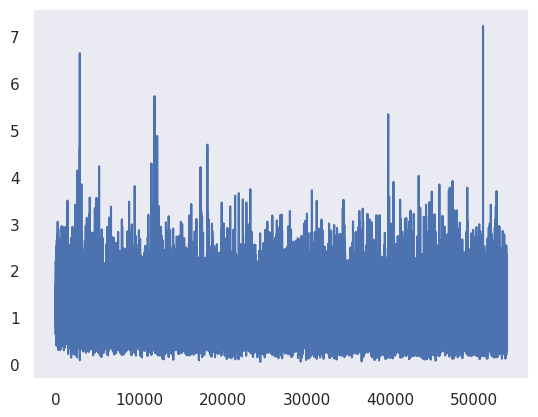

In [26]:
plt.plot(train_losses)

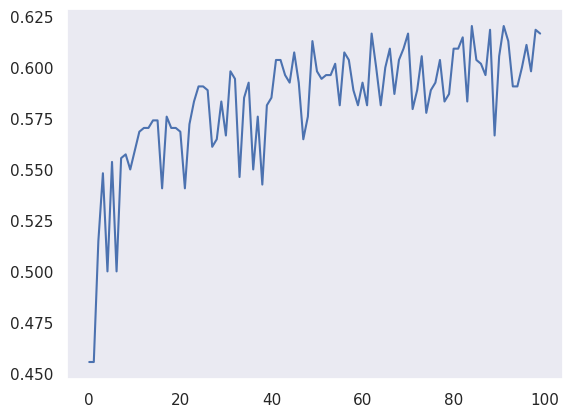

In [27]:
plt.plot(test_accuracy)

In [28]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 333/540 (0.6167)
{'acc_detail': tensor([0.6729, 0.8496, 0.5391, 0.0000], device='cuda:0'),
 'acc_unweighted': tensor(0.5154, device='cuda:0'),
 'acc_weighted': tensor(0.6167, device='cuda:0'),
 'f1s': tensor(0.4935, device='cuda:0'),
 'f1s_detail': tensor([0.7024, 0.6845, 0.5872, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.7347, 0.5731, 0.6449, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.6729, 0.8496, 0.5391, 0.0000], device='cuda:0'),
 'rocauc': tensor([0.8965, 0.7440, 0.8348, 0.6261], device='cuda:0'),
 'uar': tensor(0.5154, device='cuda:0'),
 'wap': tensor(0.5383, device='cuda:0')}


tensor([[ 72,  34,   1,   0],
        [  7, 192,  27,   0],
        [  3,  56,  69,   0],
        [ 16,  53,  10,   0]], device='cuda:0')

In [29]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_iemocap4/iemocap_label4_m18_best_85epoch.pt
Correct: 335/540 (0.6204)
{'acc_detail': tensor([0.6449, 0.8186, 0.6328, 0.0000], device='cuda:0'),
 'acc_unweighted': tensor(0.5241, device='cuda:0'),
 'acc_weighted': tensor(0.6204, device='cuda:0'),
 'f1s': tensor(0.4980, device='cuda:0'),
 'f1s_detail': tensor([0.6900, 0.6929, 0.6090, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.7419, 0.6006, 0.5870, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.6449, 0.8186, 0.6328, 0.0000], device='cuda:0'),
 'rocauc': tensor([0.8775, 0.7458, 0.8422, 0.6226], device='cuda:0'),
 'uar': tensor(0.5241, device='cuda:0'),
 'wap': tensor(0.5375, device='cuda:0')}


tensor([[ 69,  30,   7,   1],
        [  7, 185,  34,   0],
        [  2,  45,  81,   0],
        [ 15,  48,  16,   0]], device='cuda:0')

In [30]:
checkpoint_path = '../models_iemocap4/iemocap4_m18_100epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [34]:
# del model, best_model
# gc.collect()

3955